In [1]:

import pandas as pd 
from catboost import CatBoostClassifier, CatBoostRegressor
from sklearn.model_selection import StratifiedKFold,  GridSearchCV, KFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import swifter
import numpy as np
from tqdm import tqdm
import gc
pd.options.display.max_columns = None



# Базовая модель

WAU = 0.03326775406822866; UpLift at 30% 0.03586663185542682


c:\Users\Kirill\.conda\envs\automl\lib\site-packages\numpy\core\fromnumeric.py:3199: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).ndim


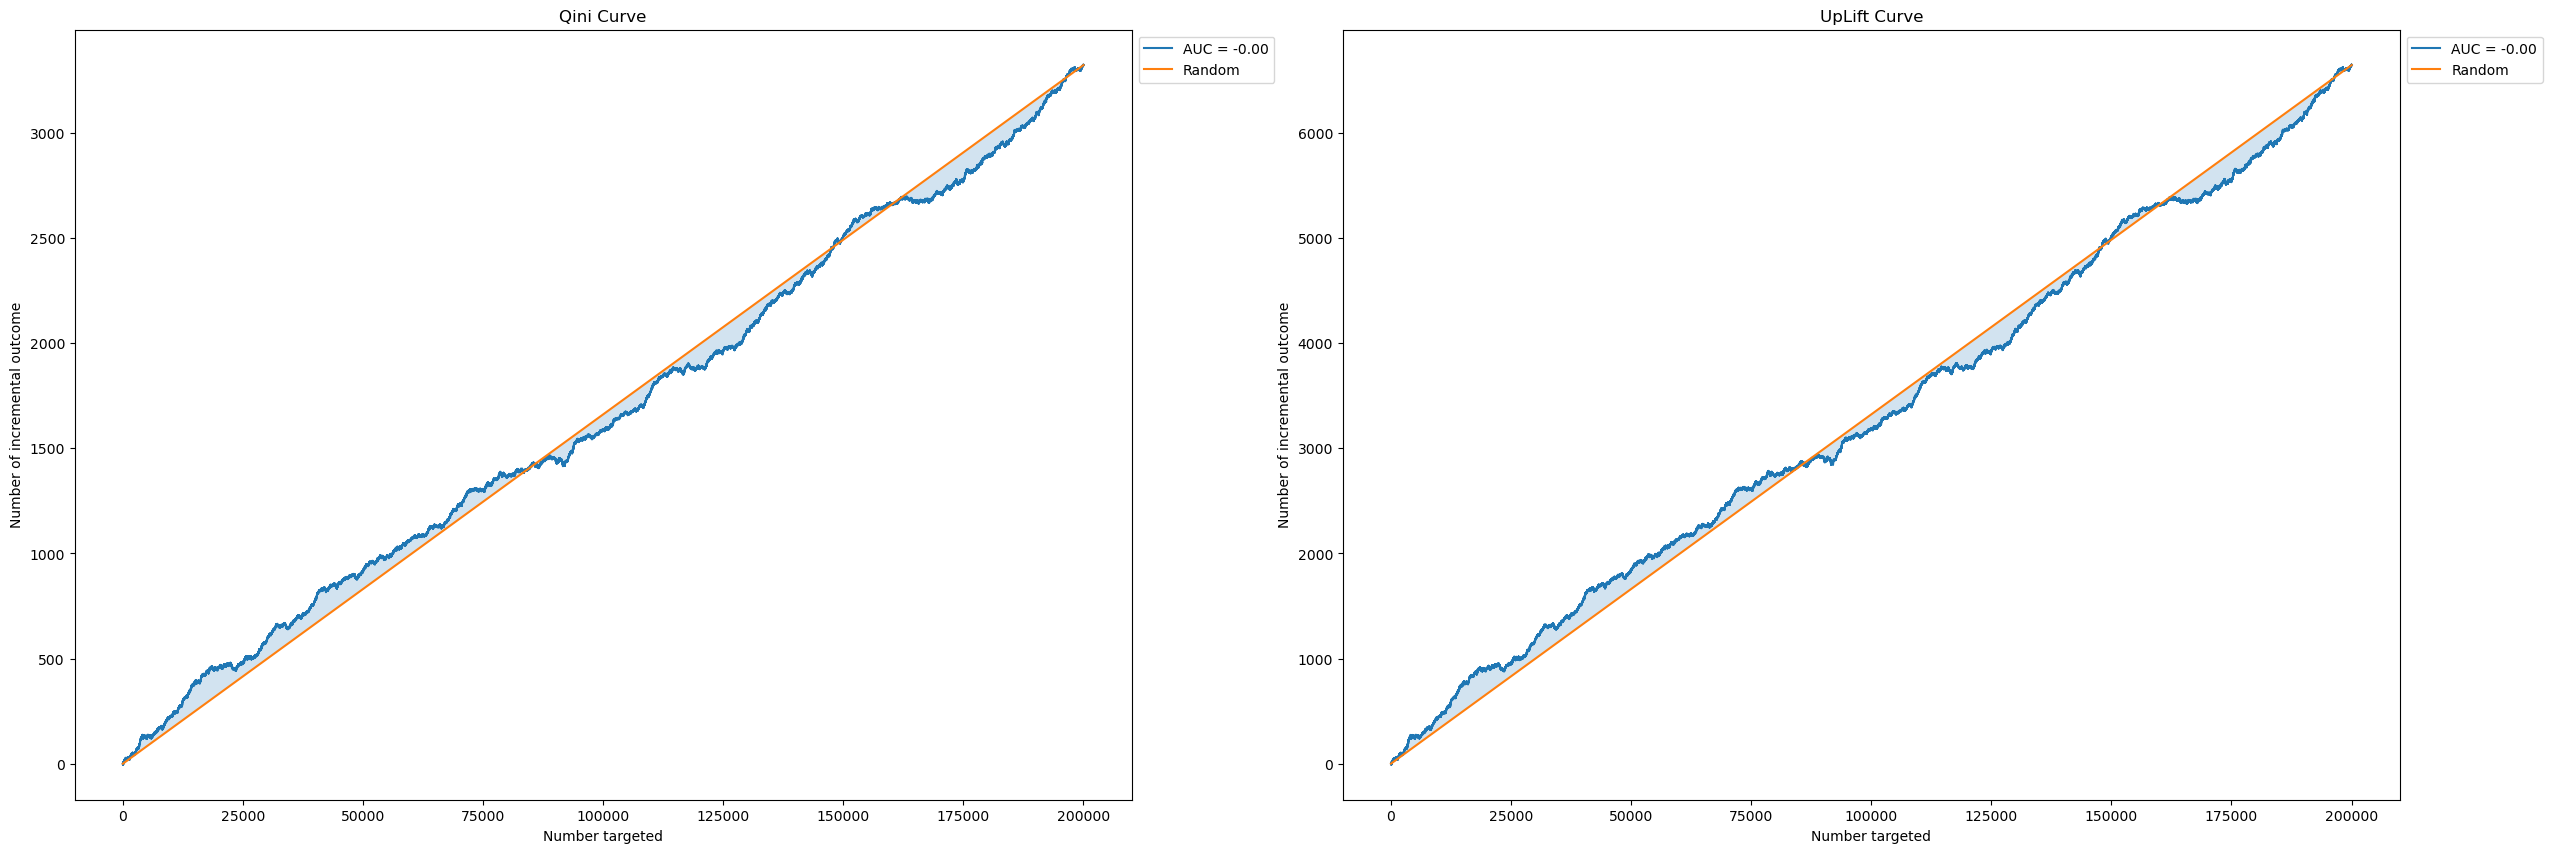

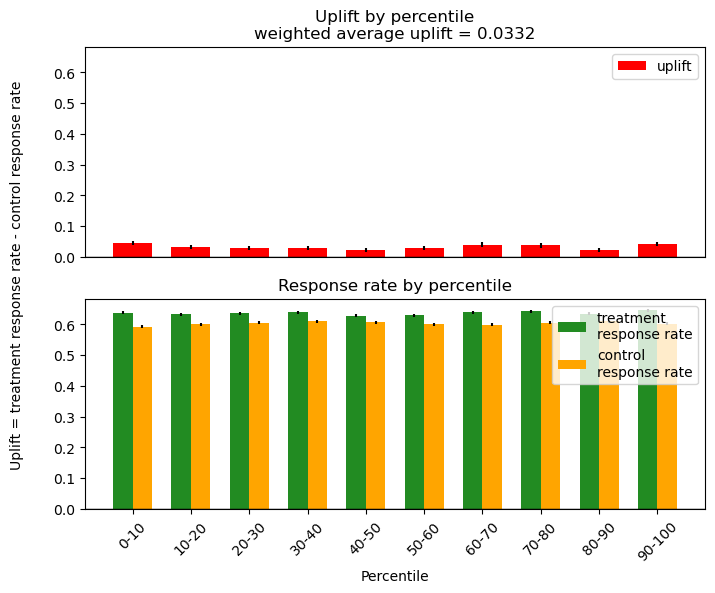

In [2]:


df= pd.read_csv(r'X5_clients_data_train.csv' , sep = ';')
df.describe()
med = df.age.median()
df.age = df.age.apply(lambda x: x if((x >= 16) and (x <= 90)) else med)
df.age = df.age.fillna(med)
df.Mean_diffs = df.Mean_diffs.fillna(df.Mean_diffs.median()) 
df = df.fillna(0)
df.describe()

df = df.drop(['MeanItemCost', 'client_id'
                , 'Mean_TOP_1_BRAND'
                ,	'Mean_TOP_2_BRAND'
                ,	'Mean_TOP_3_BRAND'
                ,	'Mean_TOP_4_BRAND',
                	'Mean_TOP_5_BRAND',
                    'Mean_TOP_1_SEG',
                    'Mean_TOP_2_SEG',
                    'Mean_TOP_3_SEG',
                    'Mean_TOP_4_SEG',
                    'Mean_TOP_5_SEG',
                    'first_order_date'	], axis = 1)
# X = df.iloc[:, 0:-1].set_index('client_id')
# y = df.iloc[:, [0, -1]].set_index('client_id')
# del df
# gc.collect()
treat = df.treatment_flg.values
y = df.iloc[:, -1].values
del df
gc.collect()

from sklift.metrics import (
    uplift_at_k, uplift_auc_score, qini_auc_score, weighted_average_uplift
)

from sklift.viz import plot_qini_curve, plot_uplift_curve, plot_uplift_by_percentile
import matplotlib.pyplot as plt


y_pred = np.random.uniform(-1, 1, len(treat)).tolist()
gc.collect()
wau = weighted_average_uplift(y_true=y , uplift=y_pred,
                        treatment=treat)
uplift_overall = uplift_at_k(y_true=y , uplift=y_pred,
                        treatment=treat, strategy='by_group', k=0.3)

print(f'WAU = {wau}; UpLift at 30% {uplift_overall}')
fig, ax = plt.subplots(1, 2, figsize = (30, 10))
ax[0].set_title('Qini Curve')
ax[1].set_title('UpLift Curve')
plot_qini_curve(y_true=y , uplift=y_pred,
                        treatment=treat, ax = ax[0], perfect=False)
gc.collect()
plot_uplift_curve(y_true=y , uplift=y_pred,
                        treatment=treat, ax = ax[1], perfect=False)
gc.collect()
gc.collect()
gc.collect()
plt.savefig(f"Plots/Base model Split.png")

plot_uplift_by_percentile(y_true=y , uplift=y_pred,
                        treatment=treat, kind='bar')
plt.savefig(f"Plots/Base model Procentile.png")






# Метод одной модели

In [3]:

df= pd.read_csv(r'X5_clients_data_train.csv', sep = ';')
display(df.describe())
display(df.dtypes)

regular_points_received  express_points_received  regular_points_spent  \
count            200039.000000            200039.000000         200039.000000   
mean                 78.022883                 0.796720             73.397088   
std                  98.582251                 7.655577            132.516680   
min                   0.000000                 0.000000              0.000000   
25%                  23.300000                 0.000000              0.000000   
50%                  49.200000                 0.000000             27.000000   
75%                  96.700000                 0.000000             98.000000   
max                8635.000000               310.000000          10131.000000   

       express_points_spent  regular_balance  express_balance   Total_Amount  \
count         200039.000000    200039.000000    200039.000000  200039.000000   
mean               6.454331         4.625795        -5.657612    8597.521955   
std               16.306043        89.682951        17.307266    8914.597077   
min                0.000000     -4919.800000      -210.000000       1.040000   
25%                0.000000       -12.200000         0.000000    3147.615000   
50%                0.000000         9.200000         0.000000    6102.440000   
75%                0.000000        33.100000         0.000000   11094.185000   
max              330.000000      1553.600000       300.000000  504490.380000   

       Amount_BonusDiscount_purchs  BonusDiscount        MeanChk  \
count                200039.000000  200039.000000  200039.000000   
mean                    585.270043       0.112710     495.783222   
std                    1201.394707       0.141952     374.548483   
min                       0.000000       0.000000       1.040000   
25%                       0.000000       0.000000     261.290000   
50%                     183.000000       0.059908     393.999846   
75%                     698.000000       0.173150     608.740000   
max                   78483.850000       0.500000    7694.000000   

       avg_regular_points_received  avg_express_points_received  \
count                200039.000000                200039.000000   
mean                      4.762904                     0.038328   
std                       5.058516                     0.510163   
min                       0.000000                     0.000000   
25%                       1.677460                     0.000000   
50%                       3.200000                     0.000000   
75%                       6.064435                     0.000000   
max                     204.600000                   100.000000   

       avg_regular_points_spent  avg_express_points_spent   MeanItemCost  \
count             200039.000000             200039.000000  200039.000000   
mean                   3.935118                  0.630199      77.096792   
std                    9.145856                  2.550302      35.309049   
min                    0.000000                  0.000000       0.065000   
25%                    0.000000                  0.000000      59.412136   
50%                    1.363636                  0.000000      71.633037   
75%                    4.705882                  0.000000      87.505172   
max                  669.000000                 50.000000    4426.800000   

                Chks  Part_BonusDiscount_purchs  cnt_BonusDiscount_purchs  \
count  200039.000000              200039.000000              200039.00000   
mean       20.120821                   0.071780                   1.25780   
std        17.732130                   0.104964                   1.68463   
min         1.000000                   0.000000                   0.00000   
25%         8.000000                   0.000000                   0.00000   
50%        15.000000                   0.041667                   1.00000   
75%        27.000000                   0.100000                   2.00000   
max       320.000000                  

client_id                       object
regular_points_received        float64
express_points_received        float64
regular_points_spent           float64
express_points_spent           float64
regular_balance                float64
express_balance                float64
Total_Amount                   float64
Amount_BonusDiscount_purchs    float64
BonusDiscount                  float64
MeanChk                        float64
avg_regular_points_received    float64
avg_express_points_received    float64
avg_regular_points_spent       float64
avg_express_points_spent       float64
MeanItemCost                   float64
Chks                             int64
Part_BonusDiscount_purchs      float64
cnt_BonusDiscount_purchs         int64
last_chk_ago                     int64
Mean_TOP_1_BRAND               float64
Mean_TOP_2_BRAND               float64
Mean_TOP_3_BRAND               float64
Mean_TOP_4_BRAND               float64
Mean_TOP_5_BRAND               float64
Mean_TOP_1_SEG           

In [4]:
med = df.age.median()
df.age = df.age.apply(lambda x: x if((x >= 16) and (x <= 90)) else med)
df.age = df.age.fillna(med)
df.Mean_diffs = df.Mean_diffs.fillna(df.Mean_diffs.median()) 
df = df.fillna(0)

In [5]:
df.describe()

regular_points_received  express_points_received  regular_points_spent  \
count            200039.000000            200039.000000         200039.000000   
mean                 78.022883                 0.796720             73.397088   
std                  98.582251                 7.655577            132.516680   
min                   0.000000                 0.000000              0.000000   
25%                  23.300000                 0.000000              0.000000   
50%                  49.200000                 0.000000             27.000000   
75%                  96.700000                 0.000000             98.000000   
max                8635.000000               310.000000          10131.000000   

       express_points_spent  regular_balance  express_balance   Total_Amount  \
count         200039.000000    200039.000000    200039.000000  200039.000000   
mean               6.454331         4.625795        -5.657612    8597.521955   
std               16.306043        89.682951        17.307266    8914.597077   
min                0.000000     -4919.800000      -210.000000       1.040000   
25%                0.000000       -12.200000         0.000000    3147.615000   
50%                0.000000         9.200000         0.000000    6102.440000   
75%                0.000000        33.100000         0.000000   11094.185000   
max              330.000000      1553.600000       300.000000  504490.380000   

       Amount_BonusDiscount_purchs  BonusDiscount        MeanChk  \
count                200039.000000  200039.000000  200039.000000   
mean                    585.270043       0.112710     495.783222   
std                    1201.394707       0.141952     374.548483   
min                       0.000000       0.000000       1.040000   
25%                       0.000000       0.000000     261.290000   
50%                     183.000000       0.059908     393.999846   
75%                     698.000000       0.173150     608.740000   
max                   78483.850000       0.500000    7694.000000   

       avg_regular_points_received  avg_express_points_received  \
count                200039.000000                200039.000000   
mean                      4.762904                     0.038328   
std                       5.058516                     0.510163   
min                       0.000000                     0.000000   
25%                       1.677460                     0.000000   
50%                       3.200000                     0.000000   
75%                       6.064435                     0.000000   
max                     204.600000                   100.000000   

       avg_regular_points_spent  avg_express_points_spent   MeanItemCost  \
count             200039.000000             200039.000000  200039.000000   
mean                   3.935118                  0.630199      77.096792   
std                    9.145856                  2.550302      35.309049   
min                    0.000000                  0.000000       0.065000   
25%                    0.000000                  0.000000      59.412136   
50%                    1.363636                  0.000000      71.633037   
75%                    4.705882                  0.000000      87.505172   
max                  669.000000                 50.000000    4426.800000   

                Chks  Part_BonusDiscount_purchs  cnt_BonusDiscount_purchs  \
count  200039.000000              200039.000000              200039.00000   
mean       20.120821                   0.071780                   1.25780   
std        17.732130                   0.104964                   1.68463   
min         1.000000                   0.000000                   0.00000   
25%         8.000000                   0.000000                   0.00000   
50%        15.000000                   0.041667                   1.00000   
75%        27.000000                   0.100000                   2.00000   
max       320.000000                  

In [6]:
df = df.drop(['MeanItemCost', 'client_id'
                , 'Mean_TOP_1_BRAND'
                ,	'Mean_TOP_2_BRAND'
                ,	'Mean_TOP_3_BRAND'
                ,	'Mean_TOP_4_BRAND',
                	'Mean_TOP_5_BRAND',
                    'Mean_TOP_1_SEG',
                    'Mean_TOP_2_SEG',
                    'Mean_TOP_3_SEG',
                    'Mean_TOP_4_SEG',
                    'Mean_TOP_5_SEG',
                    'first_order_date'
                    ,'Mean_alc'
                    ,'Mean_CTM'	
                    ,'Part_alc_purchs'	
                    ,'PArt_CTM_purchs'	
                    ,'cnt_alc_purchs'
                    ,'cnt_CTM_purchs'	], axis = 1)

In [7]:
df.iloc[:, 0:-1].head()

regular_points_received  express_points_received  regular_points_spent  \
0                     17.1                      0.0                   0.0   
1                     21.2                      0.0                   6.0   
2                     26.2                      0.0                   0.0   
3                     13.7                      0.0                   0.0   
4                     90.4                      0.0                 149.0   

   express_points_spent  regular_balance  express_balance  Total_Amount  \
0                   0.0             17.1              0.0       2950.17   
1                   0.0             15.2              0.0       2334.64   
2                   0.0             26.2              0.0       4534.55   
3                   0.0             13.7              0.0       2359.99   
4                   0.0            -58.6              0.0       8259.32   

   Amount_BonusDiscount_purchs  BonusDiscount     MeanChk  \
0                         0.00       0.000000  268.197273   
1                       190.75       0.030496  466.928000   
2                         0.00       0.000000  251.919444   
3                         0.00       0.000000  181.537692   
4                      1014.49       0.128063  485.842353   

   avg_regular_points_received  avg_express_points_received  \
0                     1.554545                          0.0   
1                     4.240000                          0.0   
2                     1.455556                          0.0   
3                     1.053846                          0.0   
4                     5.317647                          0.0   

   avg_regular_points_spent  avg_express_points_spent  Chks  \
0                  0.000000                       0.0    11   
1                  1.200000                       0.0     5   
2                  0.000000                       0.0    18   
3                  0.000000                       0.0    13   
4                  8.764706                       0.0    17   

   Part_BonusDiscount_purchs  cnt_BonusDiscount_purchs  last_chk_ago  \
0                   0.000000                         0             7   
1                   0.200000                         1             7   
2                   0.000000                         0             3   
3                   0.000000                         0             0   
4                   0.117647                         2             0   

   Mean_diffs   age  LoveBonuses  Gender  treatment_flg  
0        10.0  26.0            0      -1              0  
1        19.0  35.0            0      -1              1  
2         6.0  23.0            2       0              1  
3         5.0  69.0            0      -1              1  
4         6.0  23.0            0      -1              1

In [8]:
# X = df.iloc[:, 0:-1].set_index('client_id')
# y = df.iloc[:, [0, -1]].set_index('client_id')
# del df
# gc.collect()
treat = df.treatment_flg.values
X = df.iloc[:, 0:-1].values
X = (X - X.mean()) / X.std()
y = df.iloc[:, -1].values
del df
gc.collect()

8535

In [9]:
t_0 = np.argwhere(treat == 0)
t_1 = np.argwhere(treat == 1)
y_c = y[t_0]
len(y_c[y_c == 1]) / len(y_c)

0.6032800975434248

In [10]:
from sklift.metrics import (
    uplift_at_k, uplift_auc_score, qini_auc_score, weighted_average_uplift
)

from sklift.viz import plot_qini_curve, plot_uplift_curve, plot_uplift_by_percentile
import matplotlib.pyplot as plt



Split 1; WAU = 0.03310461997824927; UpLift at 30% 0.0386833957145285


c:\Users\Kirill\.conda\envs\automl\lib\site-packages\numpy\core\fromnumeric.py:3199: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).ndim


Split 2; WAU = 0.03251776774321422; UpLift at 30% 0.029628169995142506


c:\Users\Kirill\.conda\envs\automl\lib\site-packages\numpy\core\fromnumeric.py:3199: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).ndim


Split 3; WAU = 0.029692423820155446; UpLift at 30% 0.026324190561810346


c:\Users\Kirill\.conda\envs\automl\lib\site-packages\numpy\core\fromnumeric.py:3199: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).ndim


Split 4; WAU = 0.03515098540062246; UpLift at 30% 0.037233207277446945


c:\Users\Kirill\.conda\envs\automl\lib\site-packages\numpy\core\fromnumeric.py:3199: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).ndim


Split 5; WAU = 0.035321029286935375; UpLift at 30% 0.027732368376615302


c:\Users\Kirill\.conda\envs\automl\lib\site-packages\numpy\core\fromnumeric.py:3199: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).ndim


Mean WAU = 0.0332; Mean UpLift 30% = 0.0319


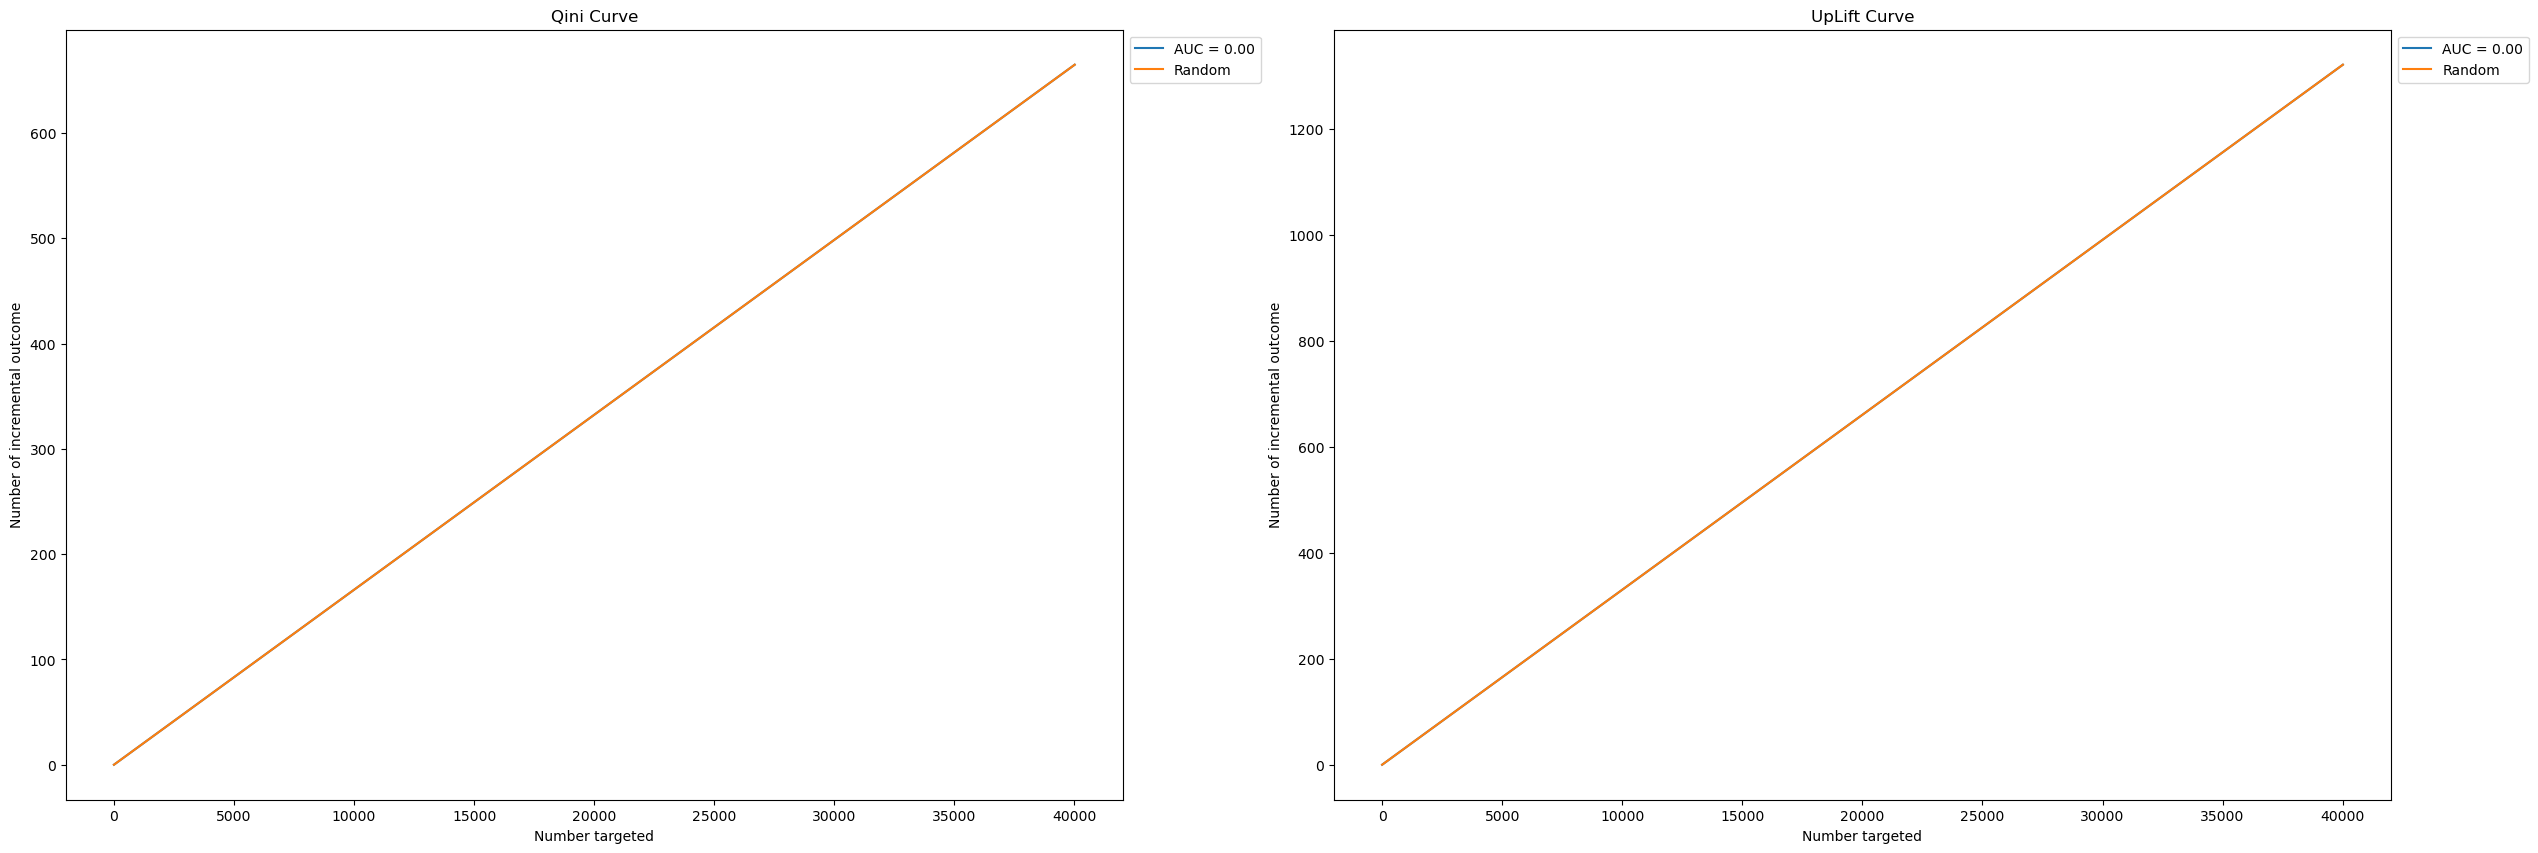

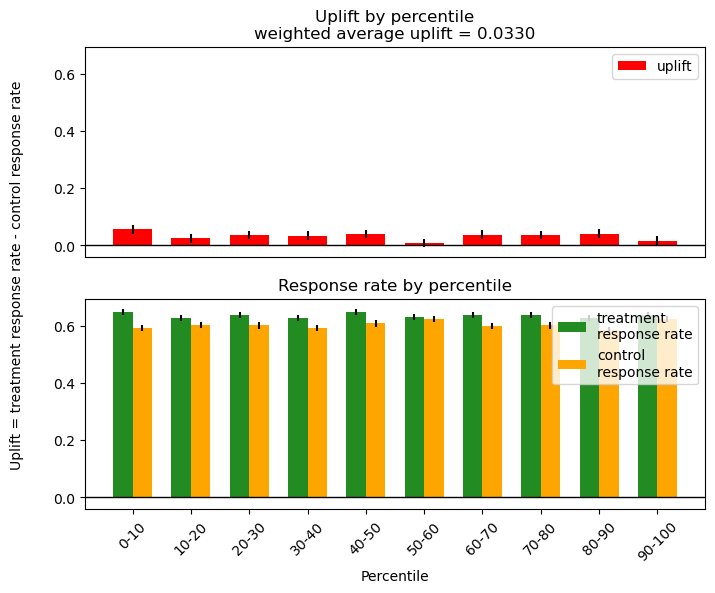

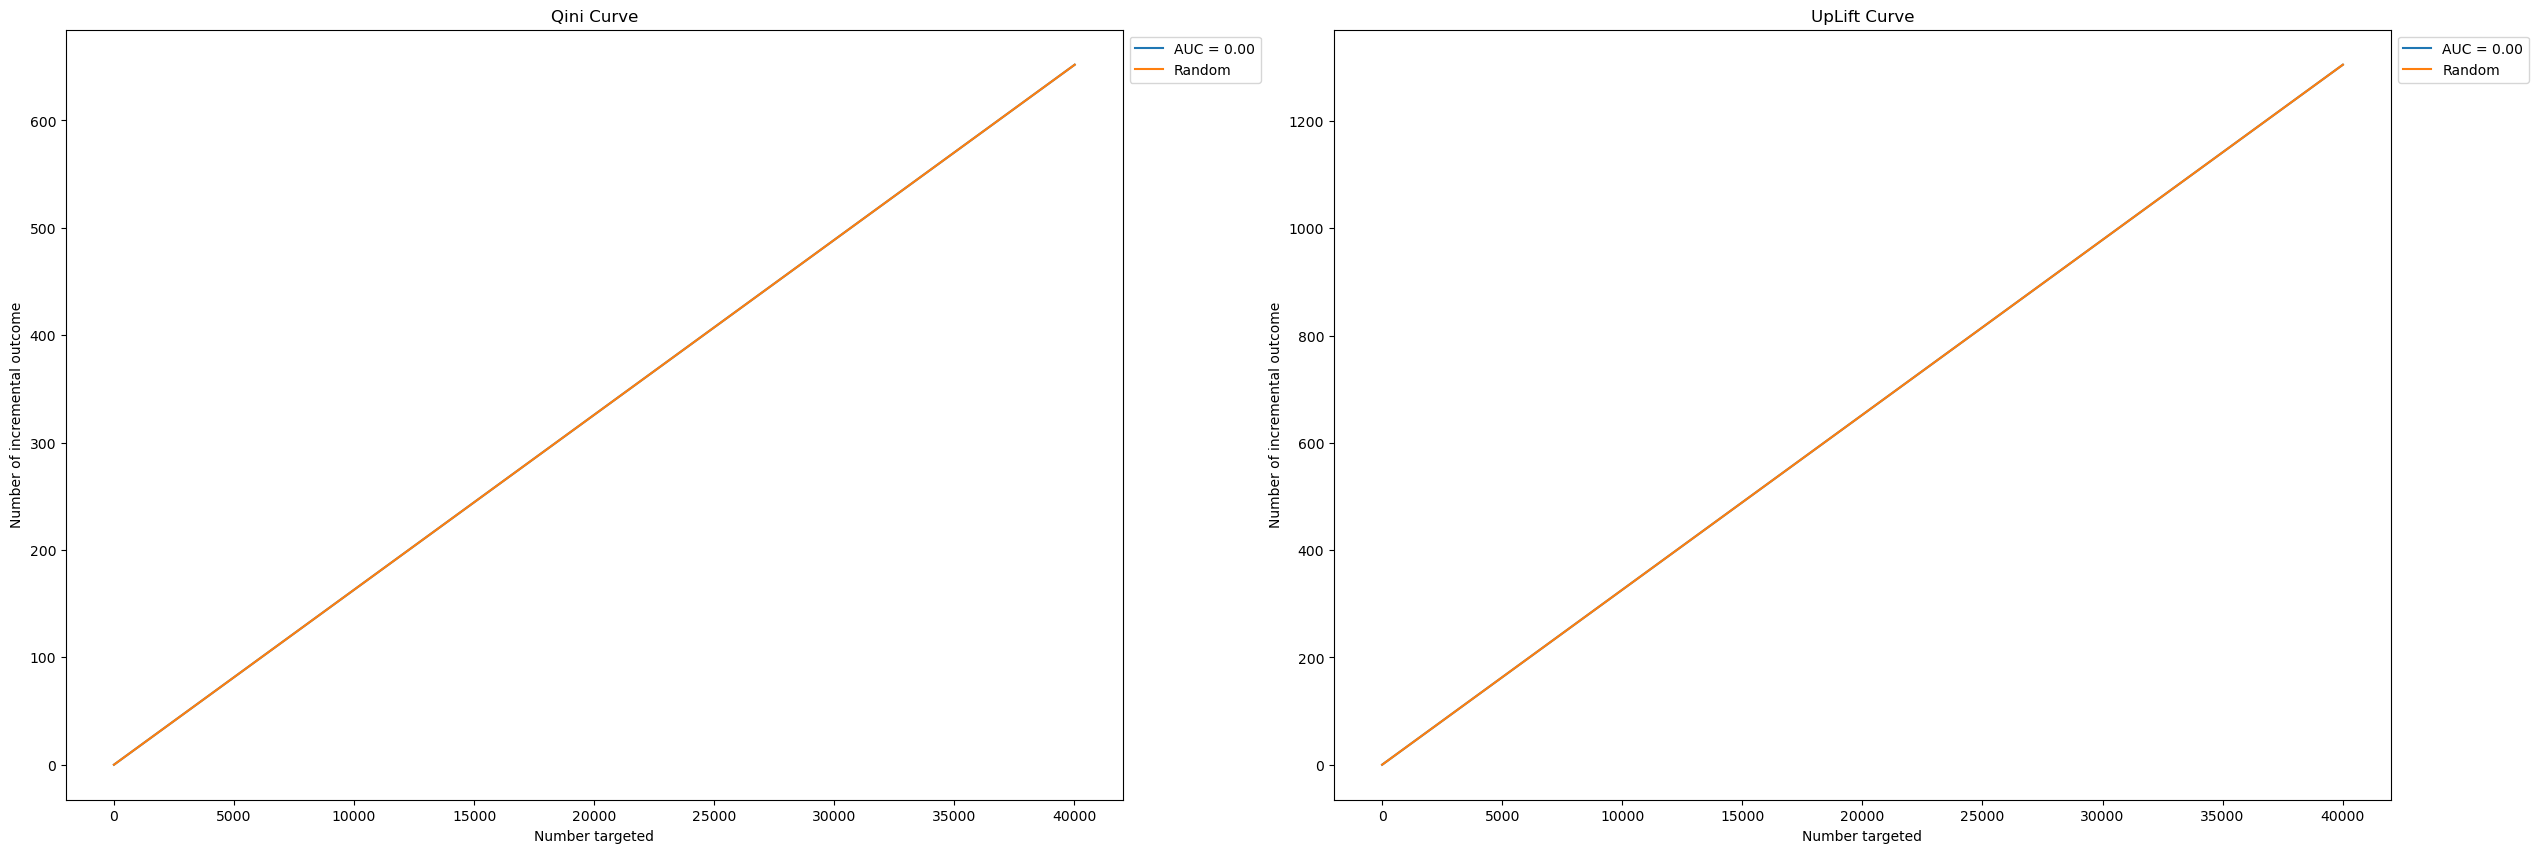

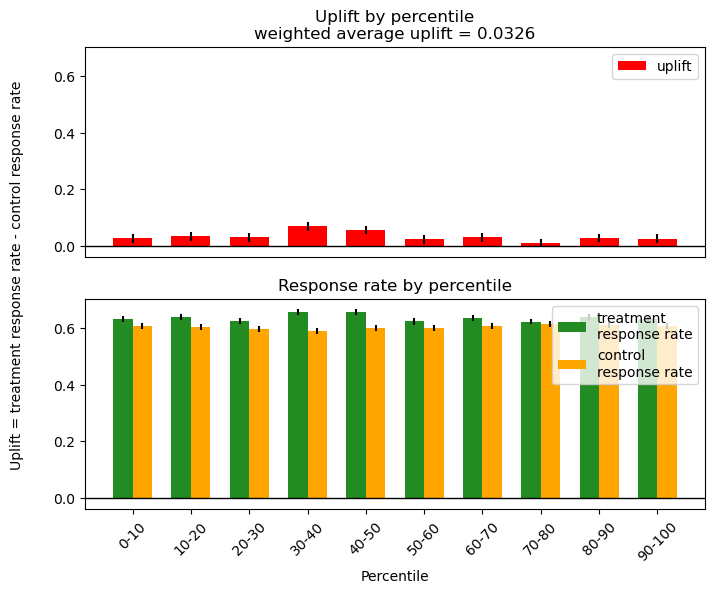

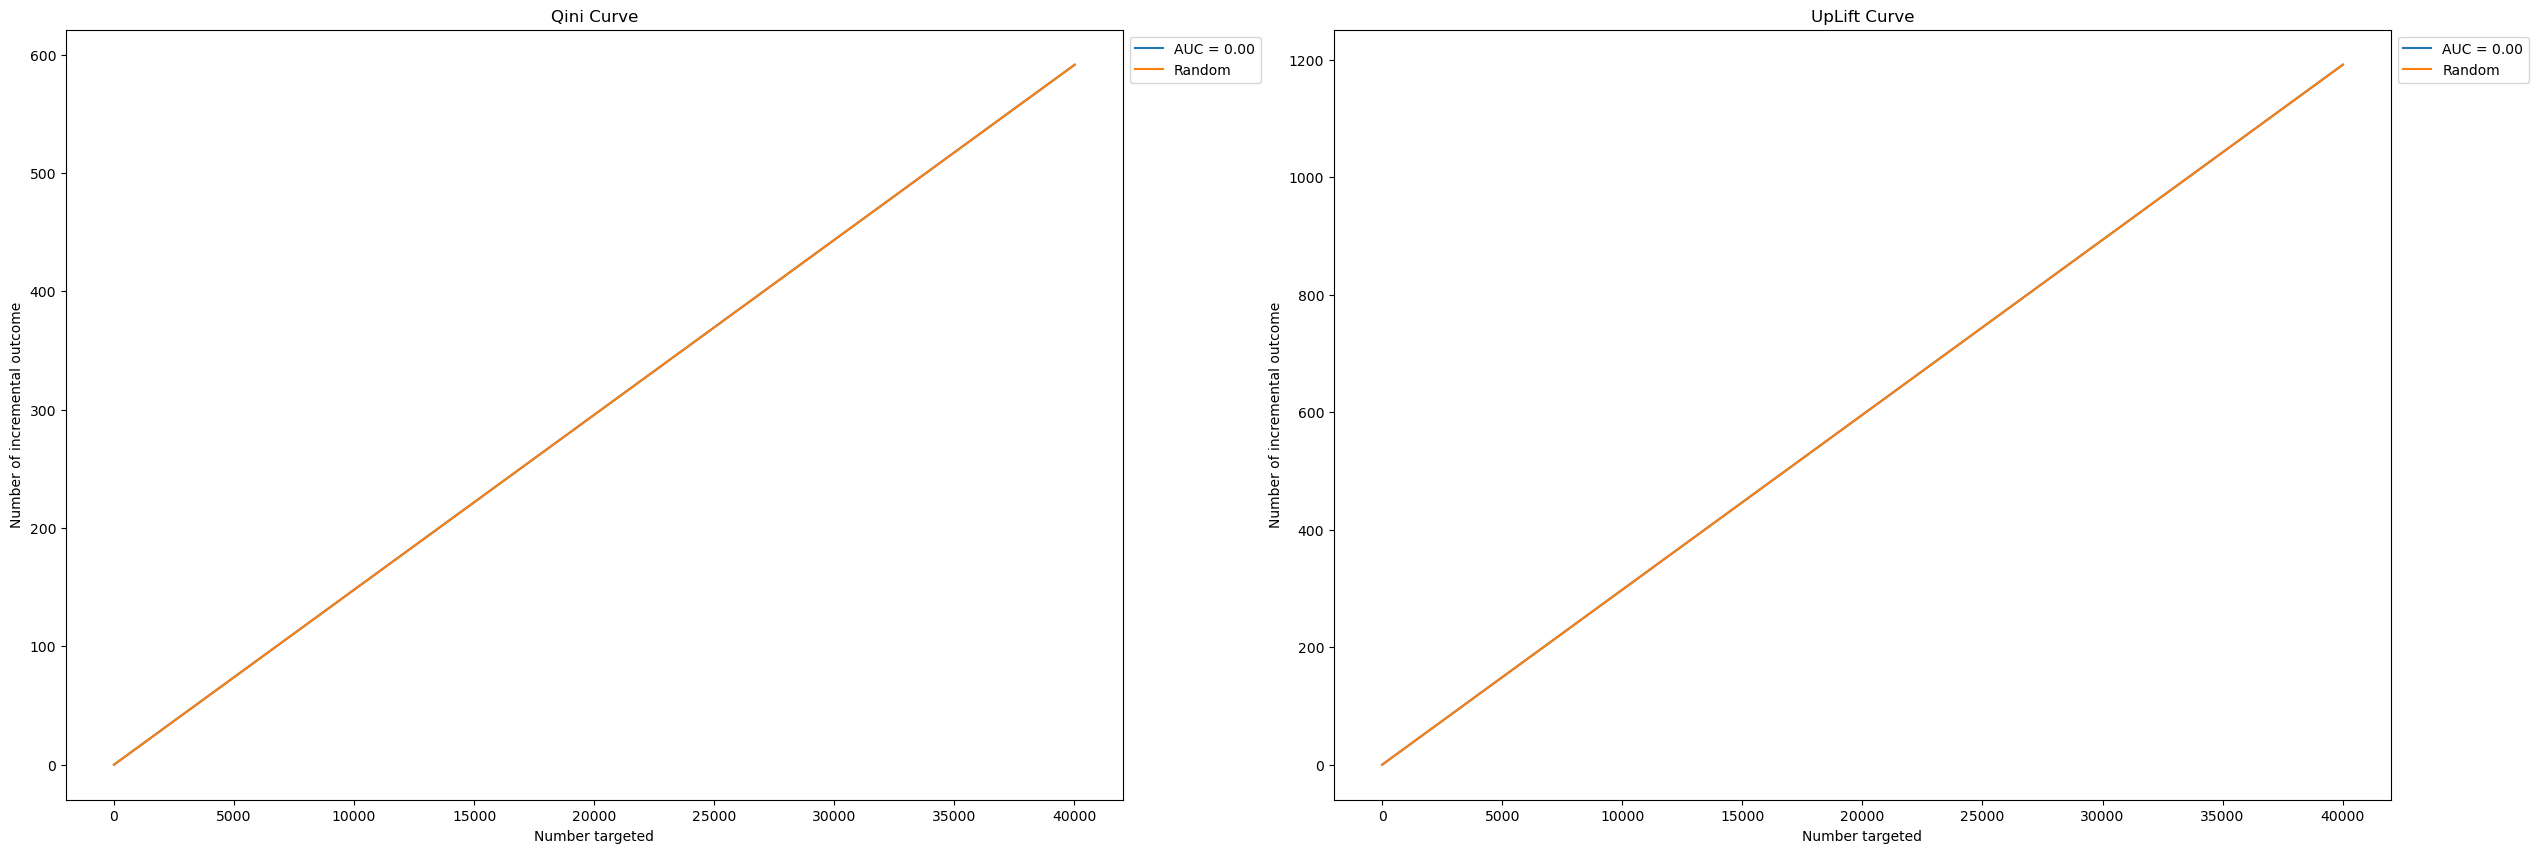

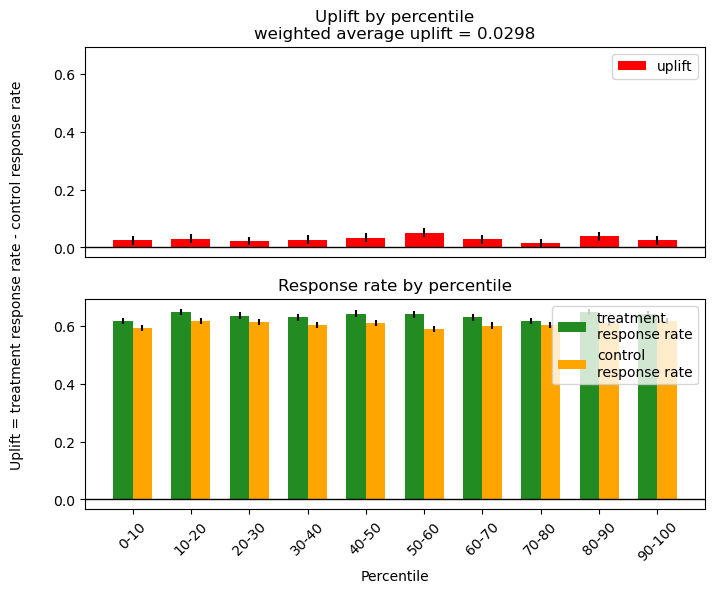

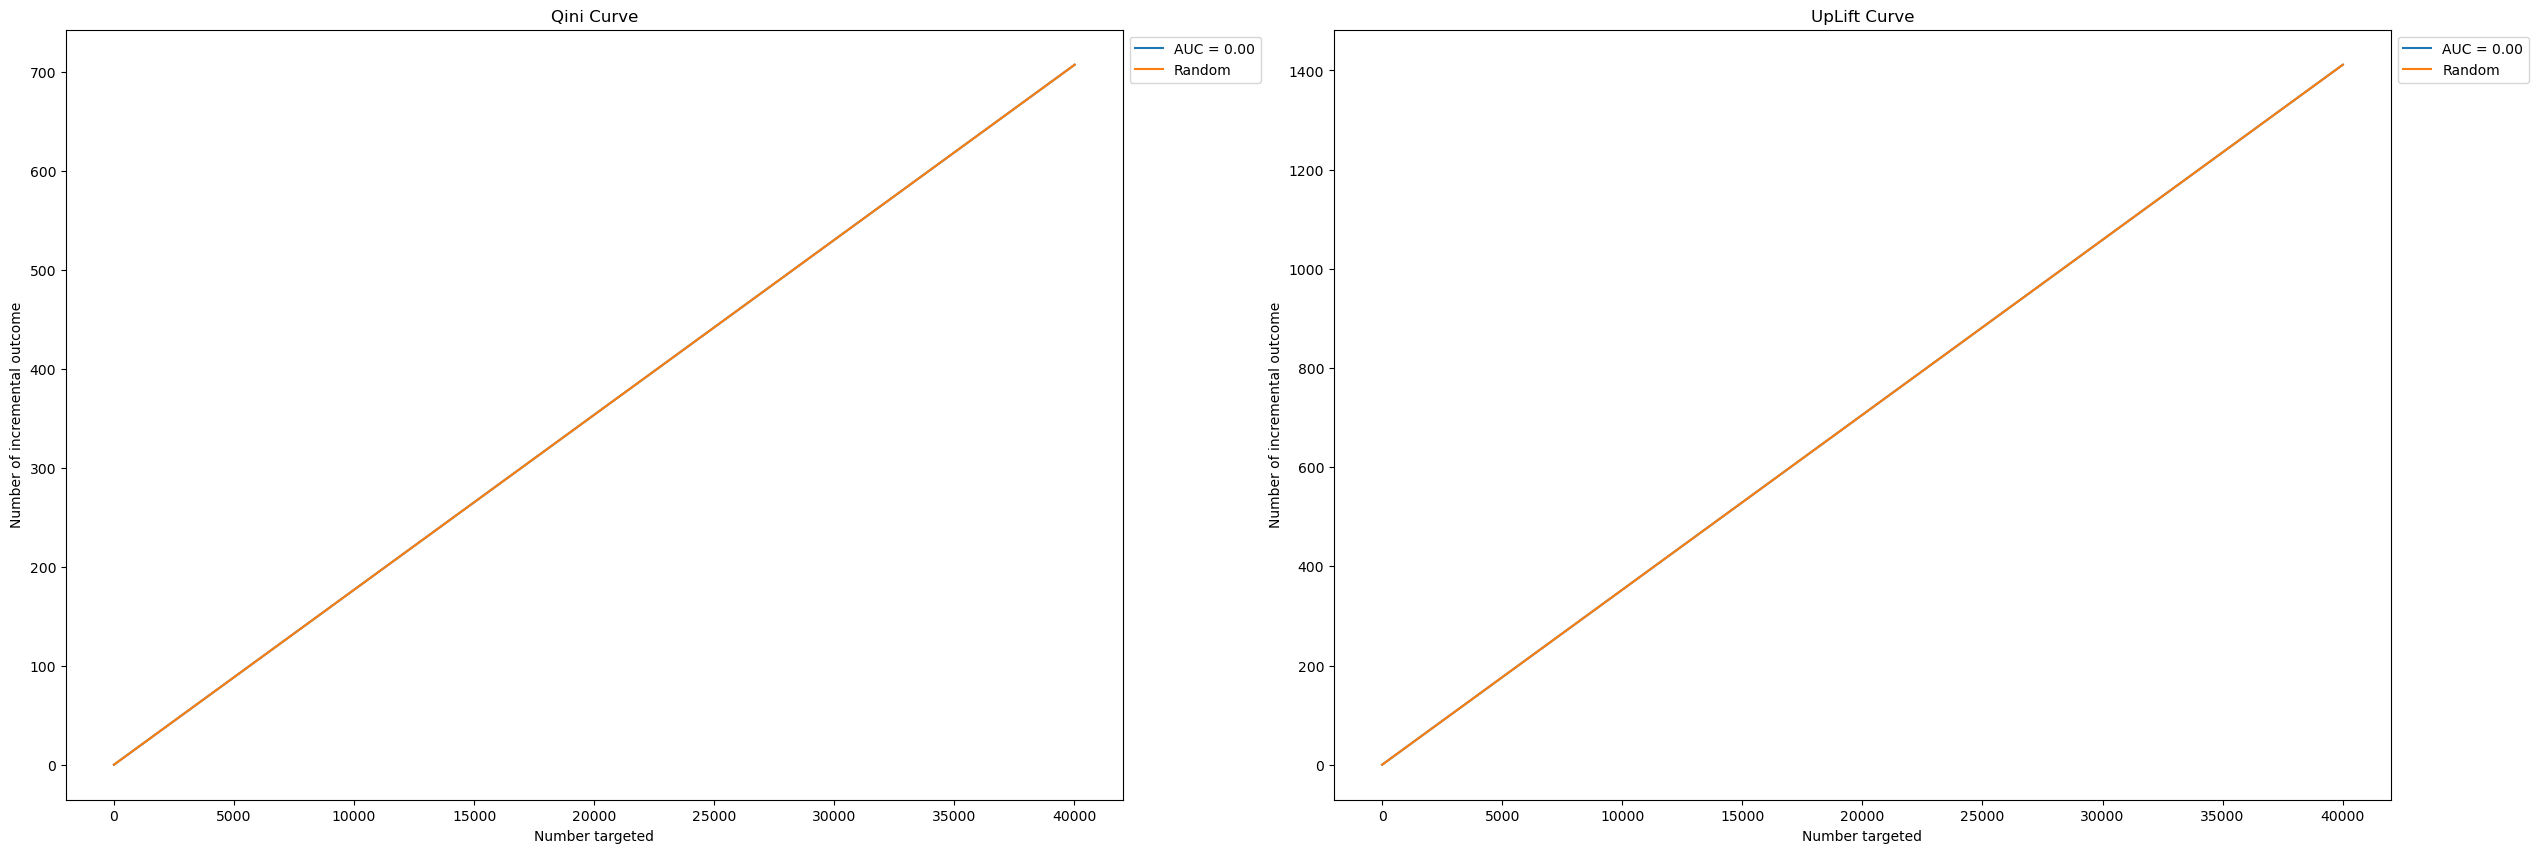

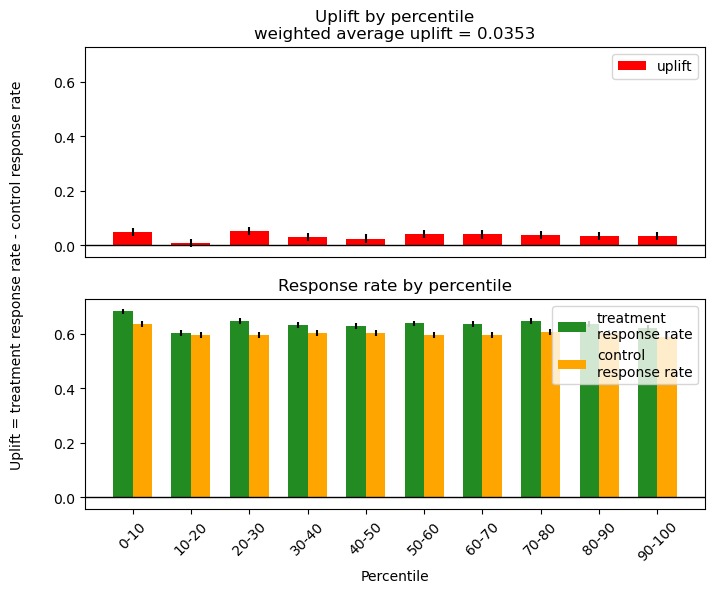

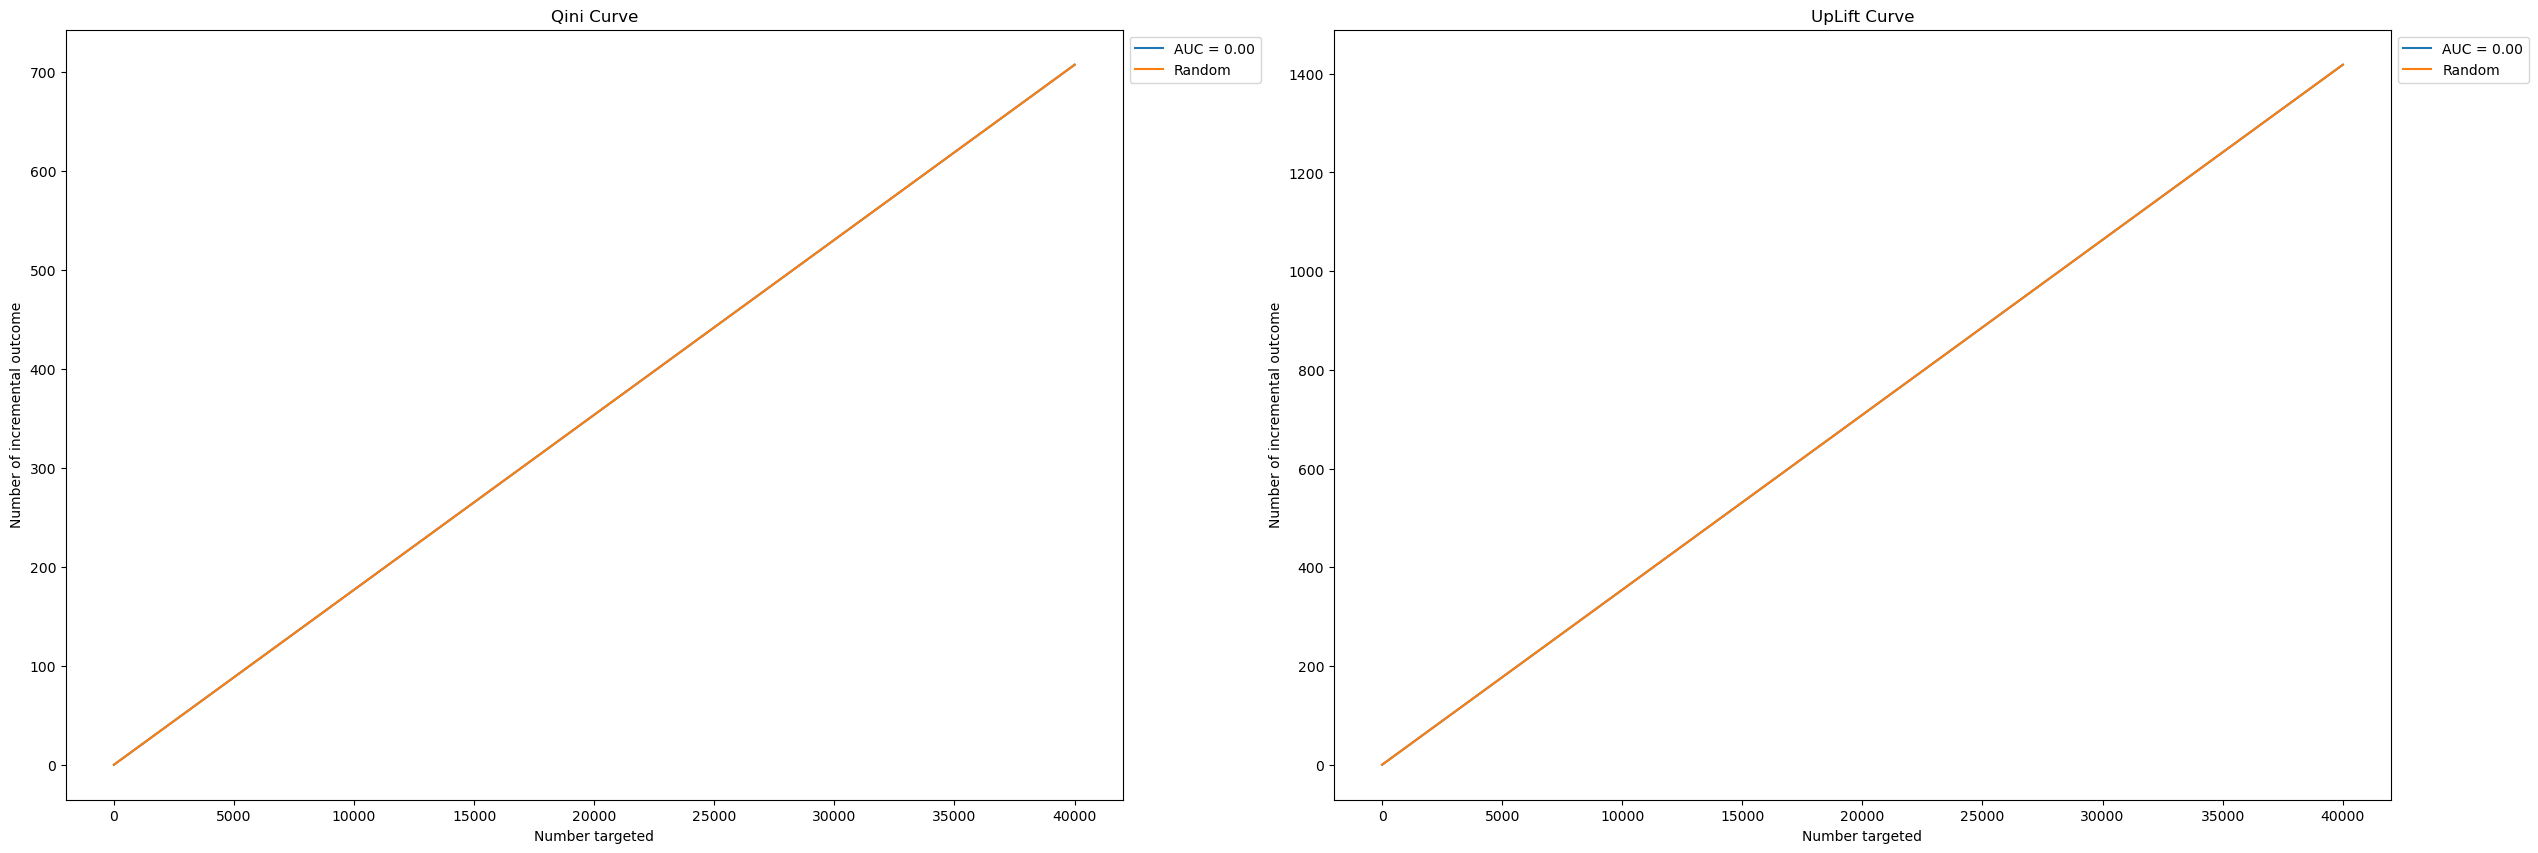

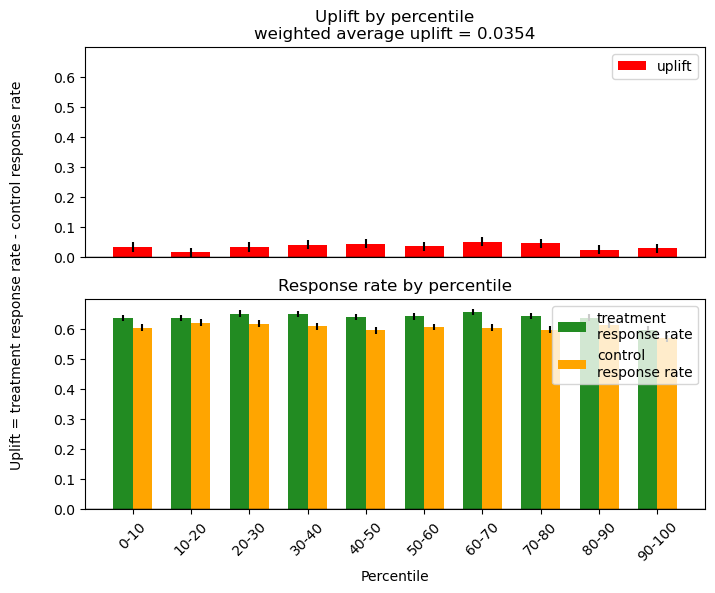

In [11]:
#Default data
skf = StratifiedKFold(n_splits=5)
skf.get_n_splits(X, y)
metrics = {'wau':[], 'uplift_k':[]}
i = 0


for train_index, test_index in skf.split(X, y):
      gc.collect()
      X_train_, X_test_ = X[train_index], X[test_index]
      y_train_, y_test_ = y[train_index], y[test_index]
      clf = CatBoostClassifier(verbose = 0)
      clf.fit(X_train_, y_train_)
      X_test_[:, -1] = 1#np.ones(len(test_index))
      y_pred1 = clf.predict_proba(X_test_).T[1]
      X_test_[:, -1] = 0#np.ones(len(test_index))
      y_pred0 = clf.predict_proba(X_test_).T[1]
      y_pred = y_pred1 - y_pred0
      del clf
      del X_train_
      del y_train_
      del X_test_
      gc.collect()
      wau = weighted_average_uplift(y_true=y_test_ , uplift=y_pred,
                              treatment=treat[test_index])
      uplift_overall = uplift_at_k(y_true=y_test_ , uplift=y_pred,
                              treatment=treat[test_index], strategy='by_group', k=0.3)
      metrics['wau'].append(wau)
      metrics['uplift_k'].append(uplift_overall)
      i += 1
      print(f'Split {i}; WAU = {wau}; UpLift at 30% {uplift_overall}')
      fig, ax = plt.subplots(1, 2, figsize = (30, 10))
      ax[0].set_title('Qini Curve')
      ax[1].set_title('UpLift Curve')
      plot_qini_curve(y_true=y_test_ , uplift=y_pred,
                              treatment=treat[test_index], ax = ax[0], perfect=False)
      gc.collect()
      plot_uplift_curve(y_true=y_test_ , uplift=y_pred,
                              treatment=treat[test_index], ax = ax[1], perfect=False)
      gc.collect()
      gc.collect()
      gc.collect()
      plt.savefig(f"Plots/One model Split {i}.png")

      plot_uplift_by_percentile(y_true=y_test_ , uplift=y_pred,
                              treatment=treat[test_index], kind='bar')
      plt.savefig(f"Plots/One model Procentile Split {i}.png")


wau = np.round(np.mean(metrics['wau']), 4)
uplift_overall = np.round(np.mean(metrics['uplift_k']), 4)
print(f'Mean WAU = {wau}; Mean UpLift 30% = {uplift_overall}')

In [12]:
wau = np.round(np.mean(metrics['wau']), 4)
uplift_overall = np.round(np.mean(metrics['uplift_k']), 4)
print(f'Mean WAU = {wau}; Mean UpLift 30% = {uplift_overall}')

Mean WAU = 0.0332; Mean UpLift 30% = 0.0319


In [13]:
gc.collect()

70604

# Метод двух моделей

In [14]:


df= pd.read_csv(r'X5_clients_data_train.csv', sep = ';')
df.describe()
med = df.age.median()
df.age = df.age.apply(lambda x: x if((x >= 16) and (x <= 90)) else med)
df.age = df.age.fillna(med)
df.Mean_diffs = df.Mean_diffs.fillna(df.Mean_diffs.median()) 
df = df.fillna(0)
df.describe()

df = df.drop(['MeanItemCost', 'client_id'
                , 'Mean_TOP_1_BRAND'
                ,	'Mean_TOP_2_BRAND'
                ,	'Mean_TOP_3_BRAND'
                ,	'Mean_TOP_4_BRAND',
                	'Mean_TOP_5_BRAND',
                    'Mean_TOP_1_SEG',
                    'Mean_TOP_2_SEG',
                    'Mean_TOP_3_SEG',
                    'Mean_TOP_4_SEG',
                    'Mean_TOP_5_SEG',
                    'first_order_date'
                    ,'Mean_alc'
                    ,'Mean_CTM'	
                    ,'Part_alc_purchs'	
                    ,'PArt_CTM_purchs'	
                    ,'cnt_alc_purchs'
                    ,'cnt_CTM_purchs'], axis = 1)
# X = df.iloc[:, 0:-1].set_index('client_id')
# y = df.iloc[:, [0, -1]].set_index('client_id')
# del df
# gc.collect()
treat = df.treatment_flg.values
X = df.iloc[:, 0:-1].values
X = (X - X.mean()) / X.std()
y = df.iloc[:, -1].values
del df
gc.collect()
X
y
# X_train, X_test, y_train, y_test = train_test_split(X, y)
# output.enable_custom_widget_manager()
# grid = {'learning_rate':  np.linspace(0, 0.05, 10)[1:-1],
#         'depth': [4, 6, 10],
#         'l2_leaf_reg': [1, 3, 5, 7, 9]}
# clf = CatBoostClassifier(verbose = 0)  
# grid_search_result = clf.grid_search(grid, 
#                                        X=X_train, 
#                                        y=y_train, 
#                                        plot=True)
from sklift.metrics import (
    uplift_at_k, uplift_auc_score, qini_auc_score, weighted_average_uplift
)

from sklift.viz import plot_qini_curve, plot_uplift_curve, plot_uplift_by_percentile
import matplotlib.pyplot as plt







In [15]:

indxs = np.argwhere(X.T[-1] == 0)
indxs

array([], shape=(0, 1), dtype=int64)

Split 1; WAU = 0.03224123564521461; UpLift 30% 0.06259964048878419


c:\Users\Kirill\.conda\envs\automl\lib\site-packages\numpy\core\fromnumeric.py:3199: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).ndim


Split 2; WAU = 0.03179907769597101; UpLift 30% 0.03201416320682371


c:\Users\Kirill\.conda\envs\automl\lib\site-packages\numpy\core\fromnumeric.py:3199: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).ndim


Split 3; WAU = 0.02982800953513284; UpLift 30% 0.05253306094960053


c:\Users\Kirill\.conda\envs\automl\lib\site-packages\numpy\core\fromnumeric.py:3199: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).ndim


Split 4; WAU = 0.033910866516586244; UpLift 30% 0.04695068742041664


c:\Users\Kirill\.conda\envs\automl\lib\site-packages\numpy\core\fromnumeric.py:3199: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).ndim


Split 5; WAU = 0.035160475935916646; UpLift 30% 0.04466315945004362


c:\Users\Kirill\.conda\envs\automl\lib\site-packages\numpy\core\fromnumeric.py:3199: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).ndim


Mean WAU = 0.0326; Mean UpLift 30% = 0.0478


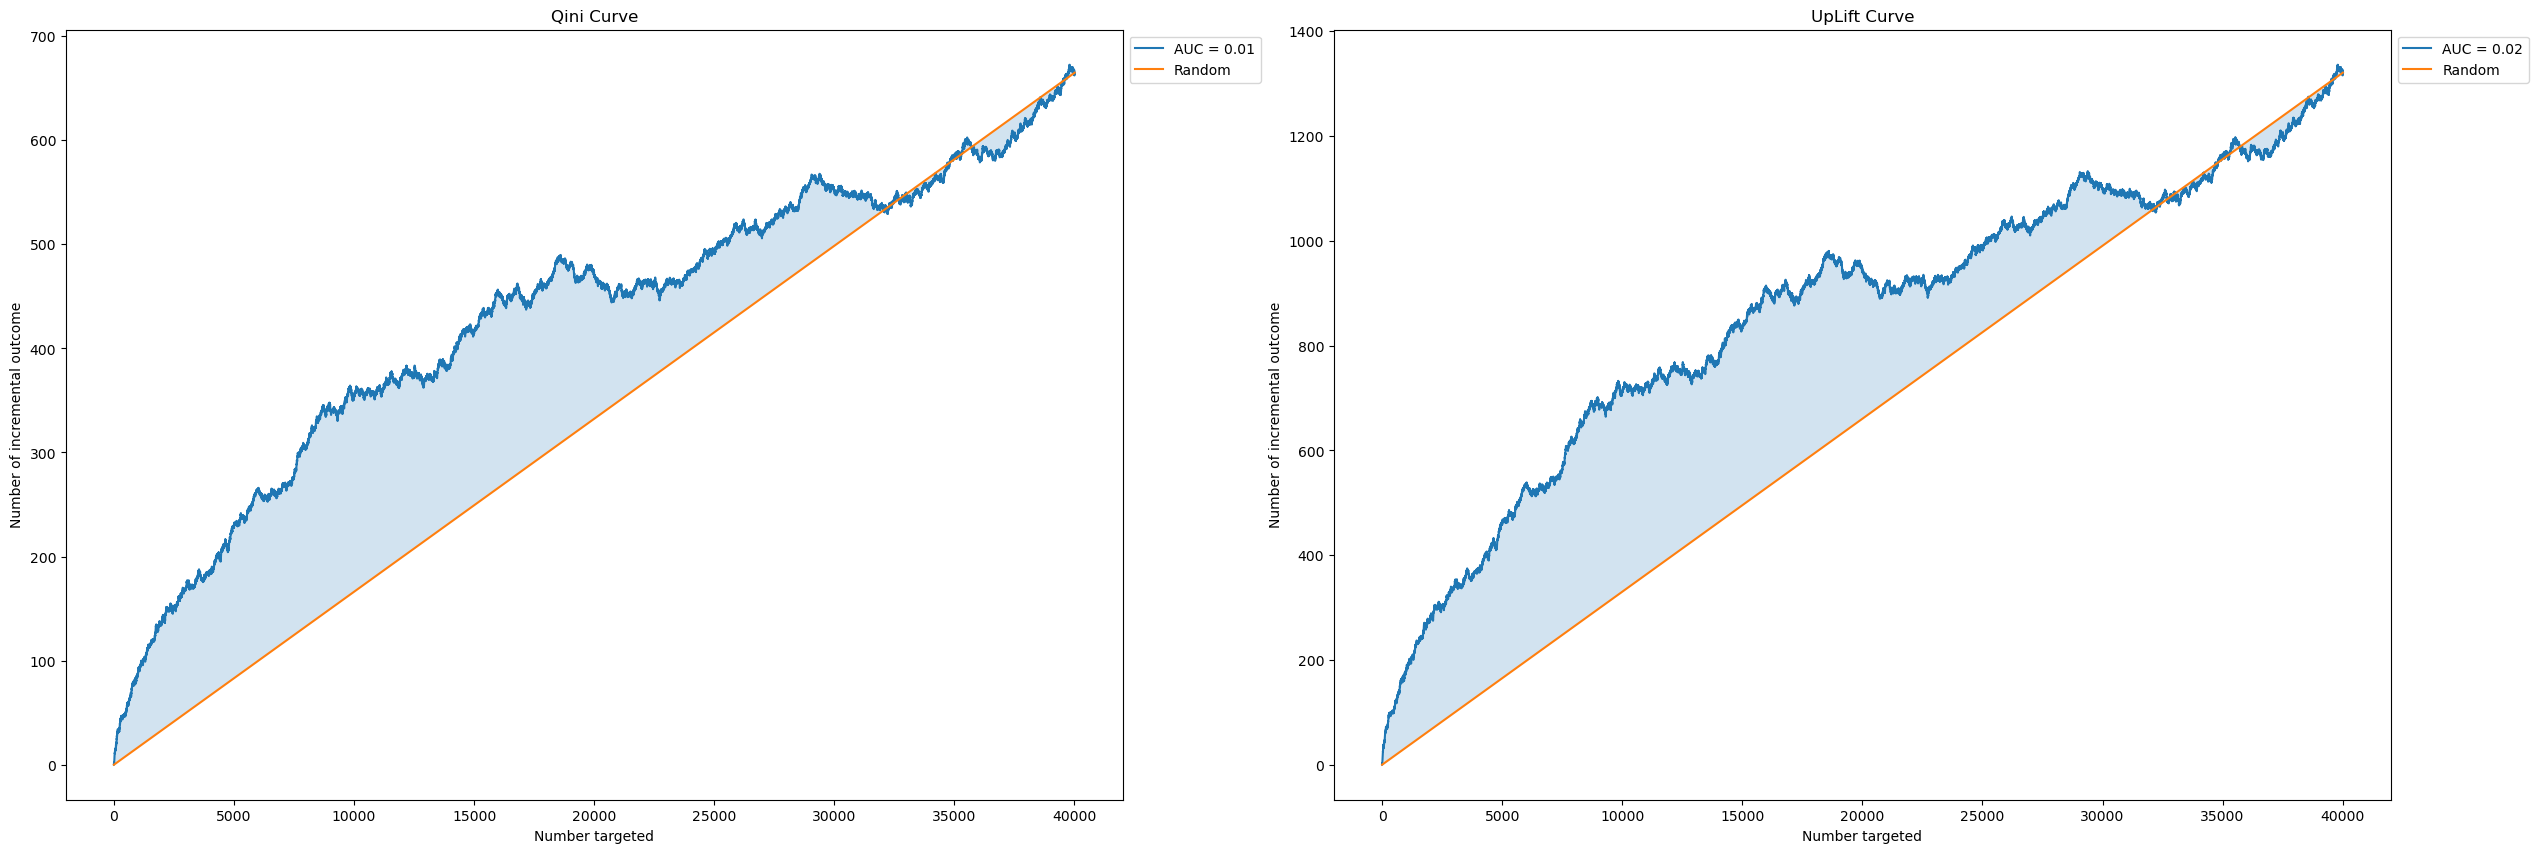

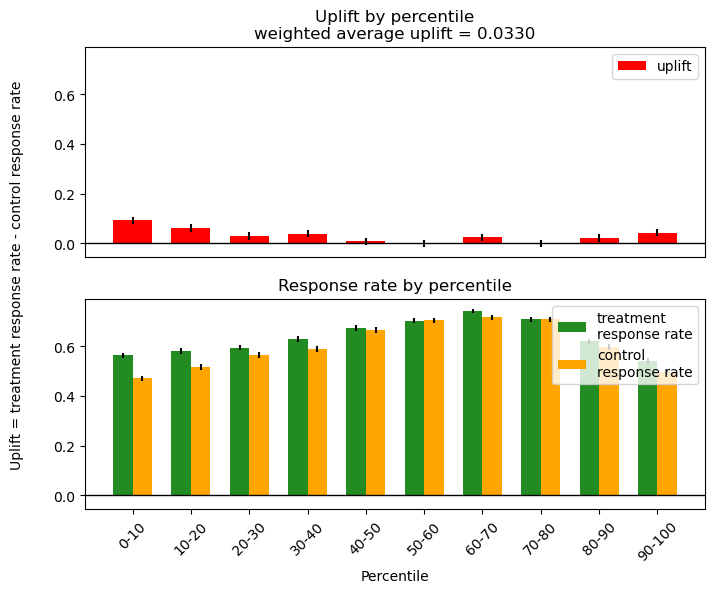

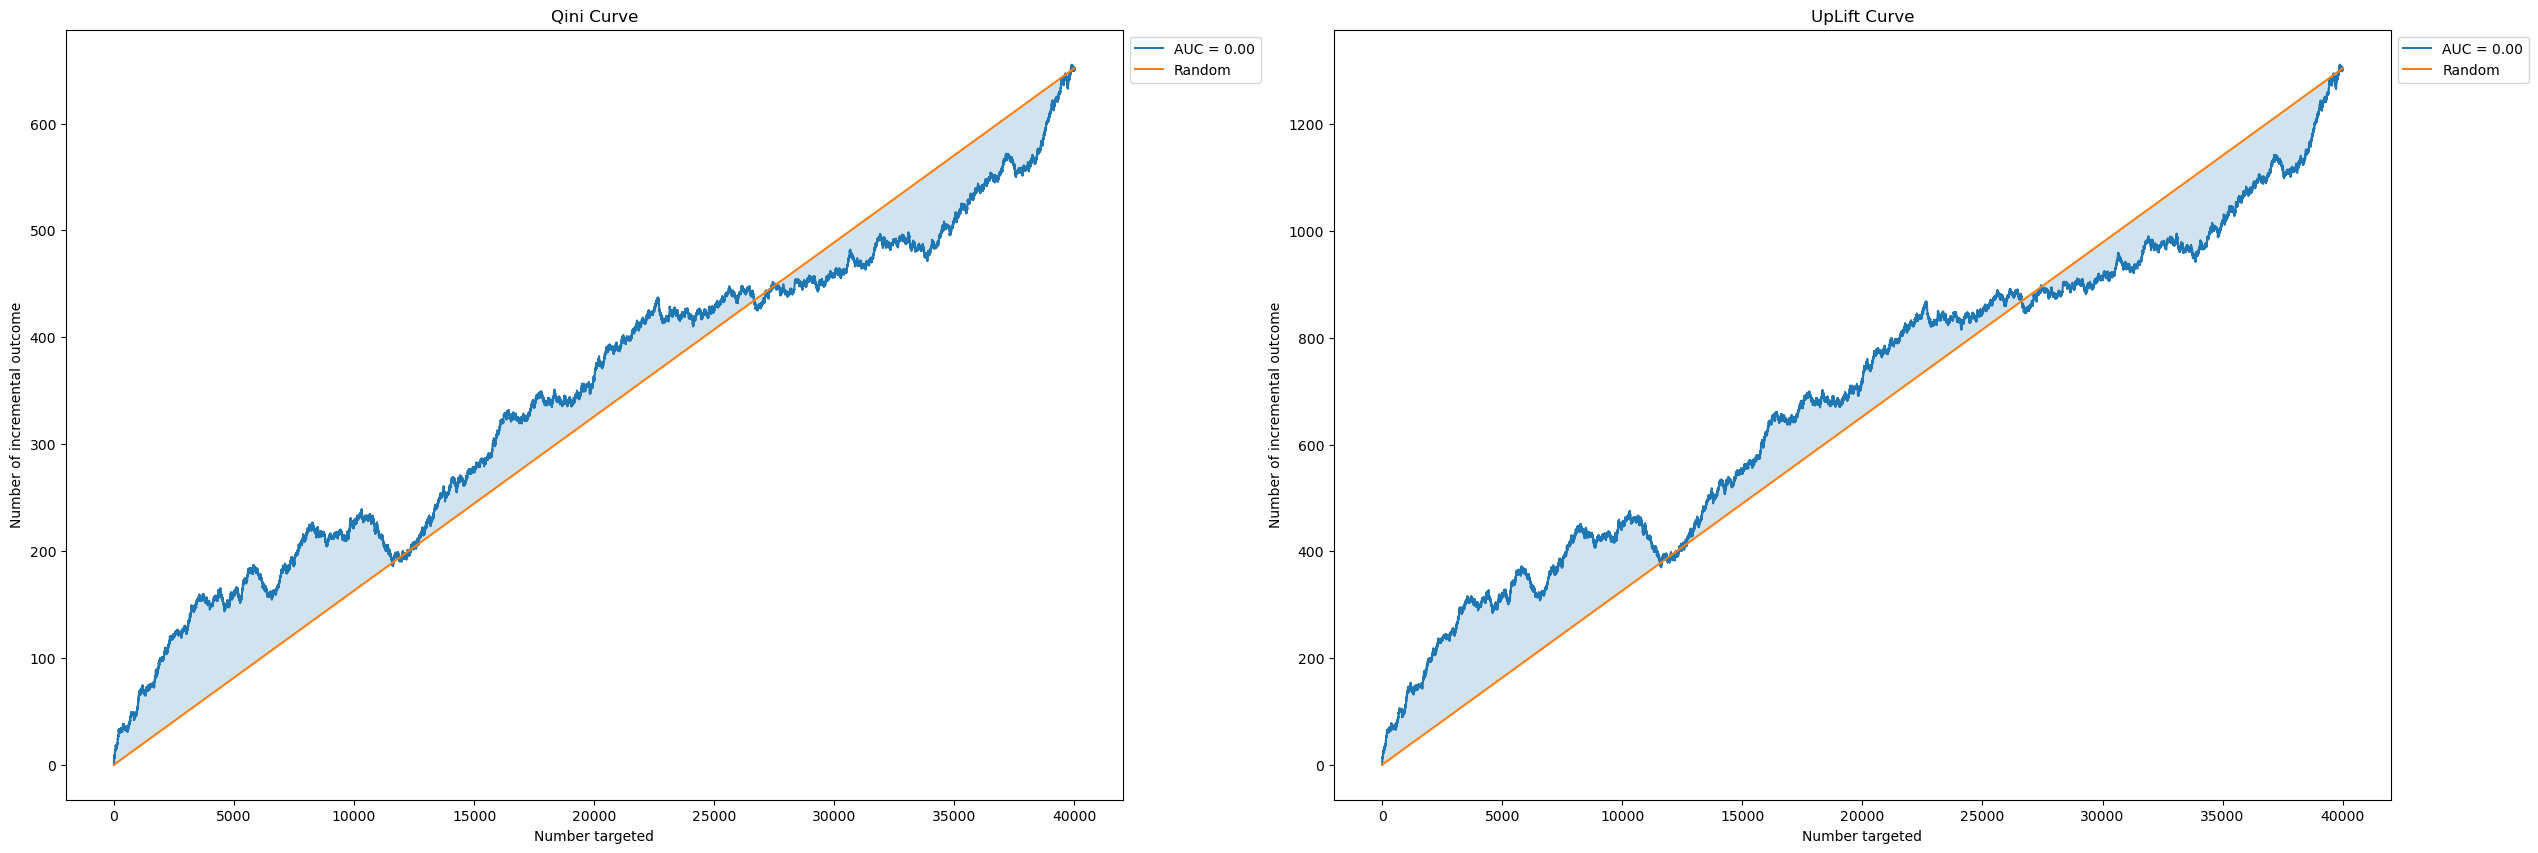

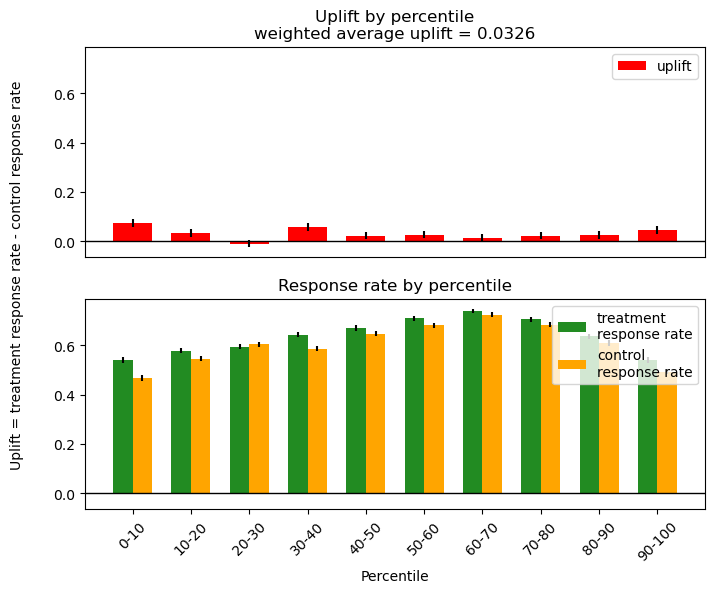

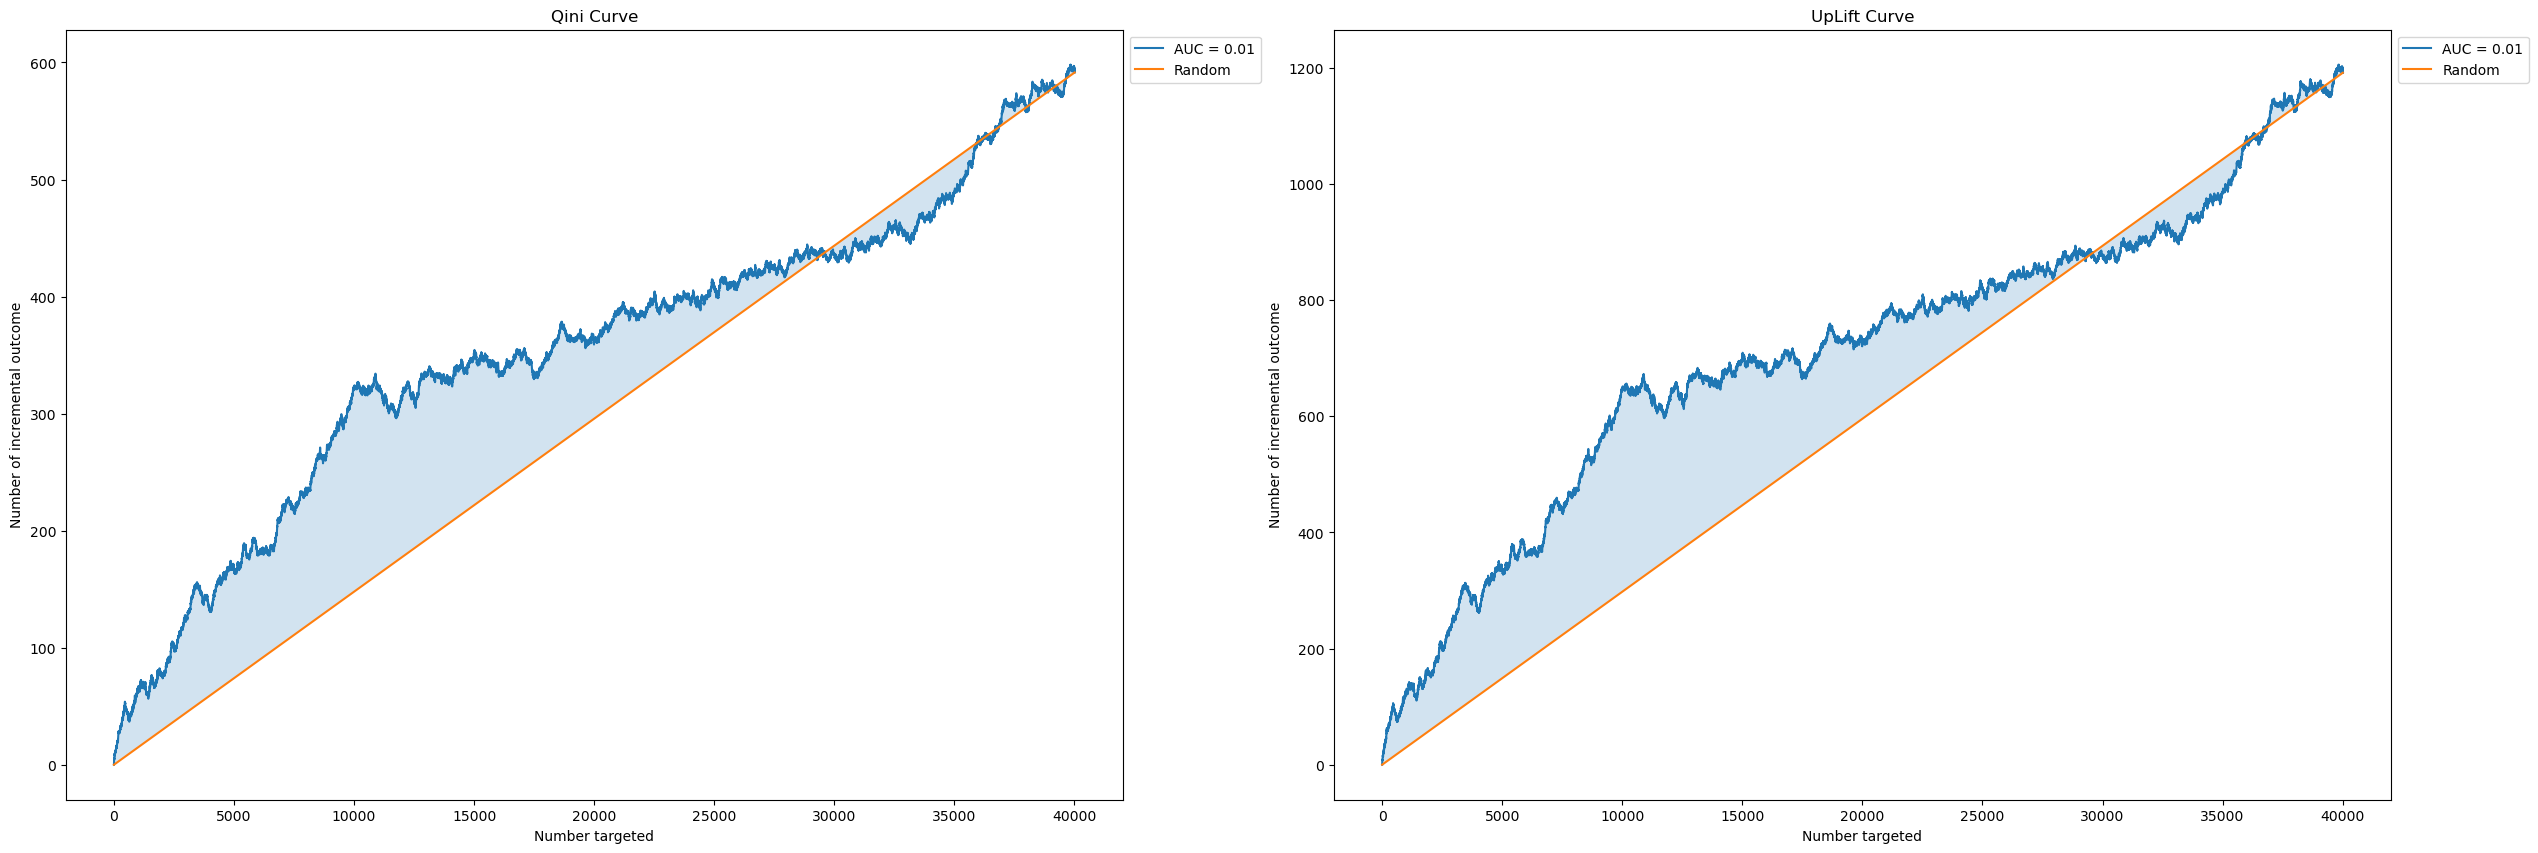

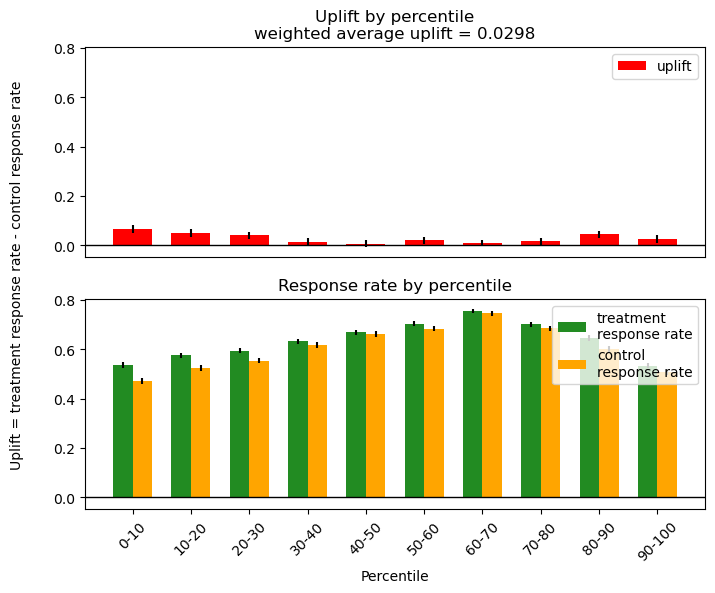

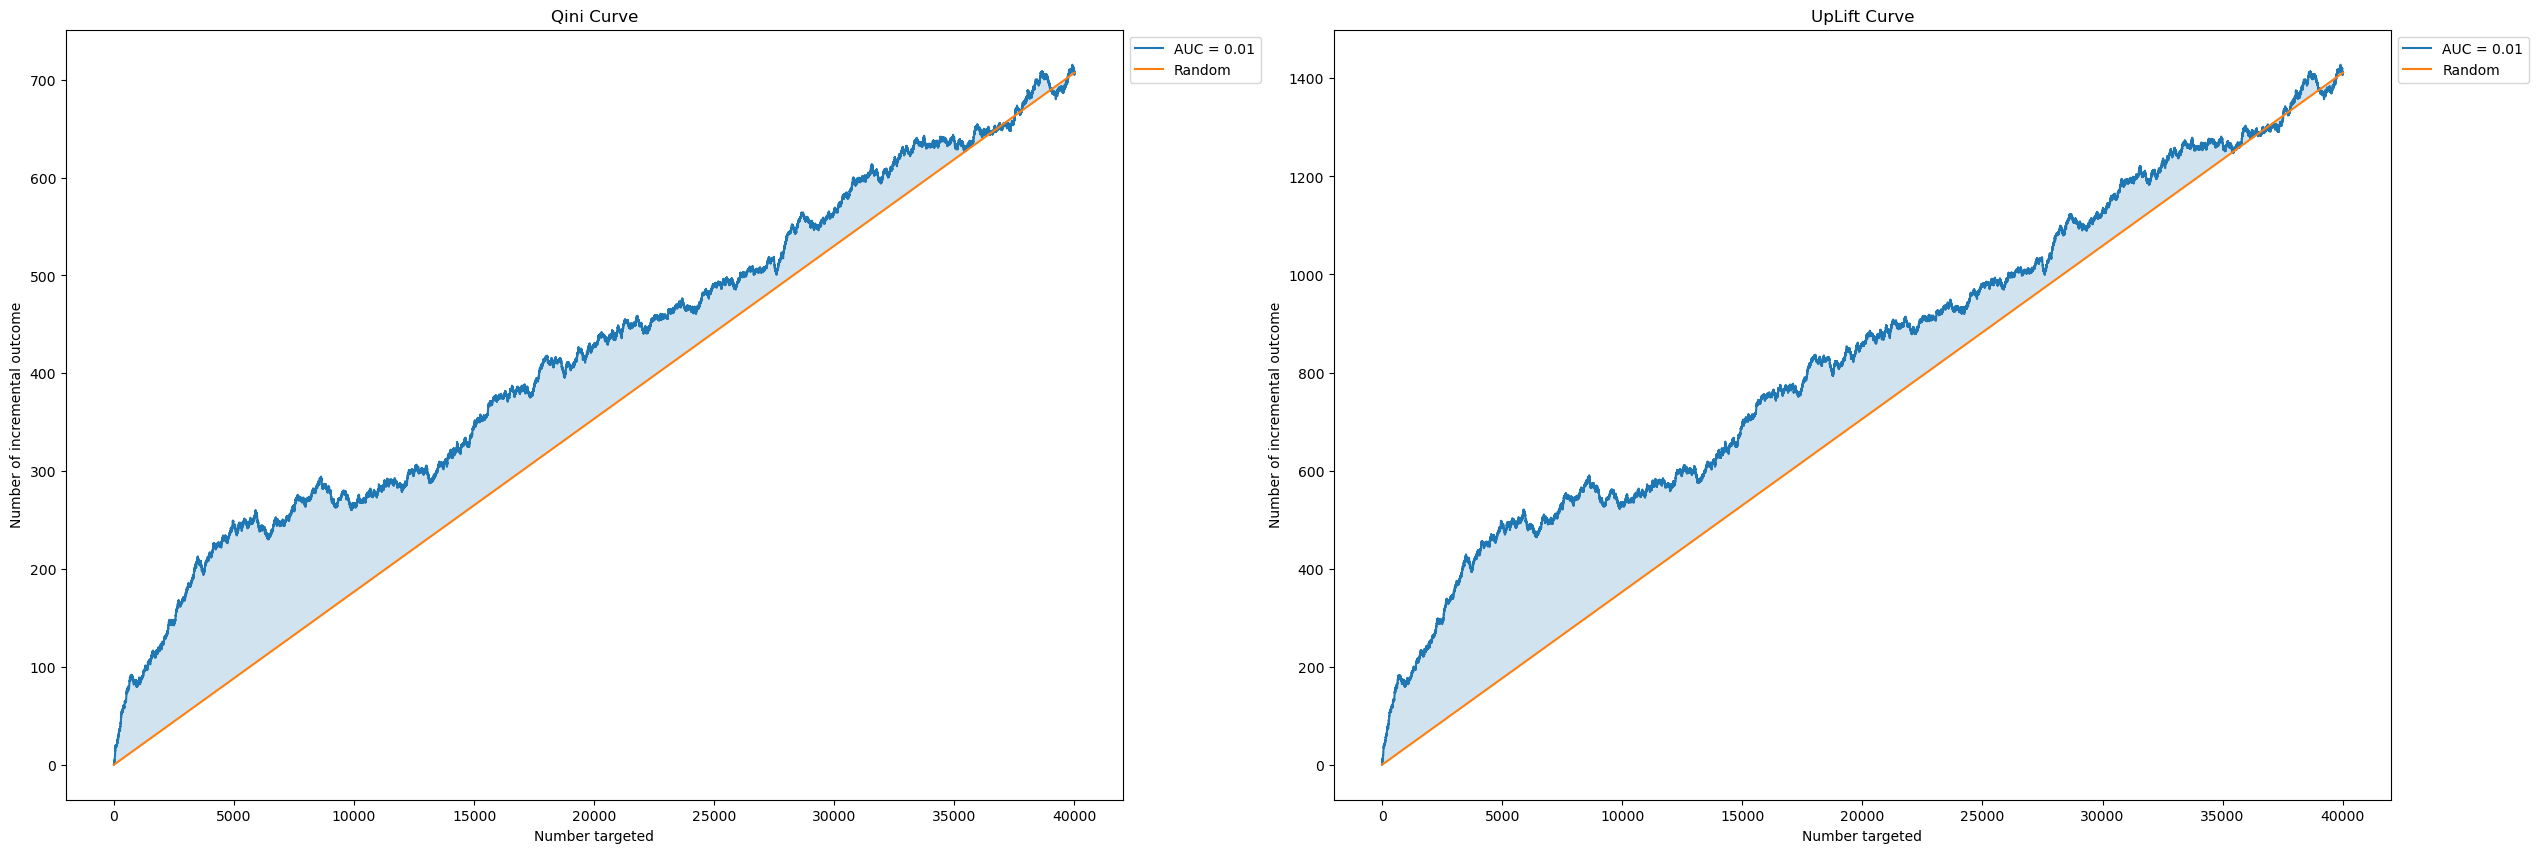

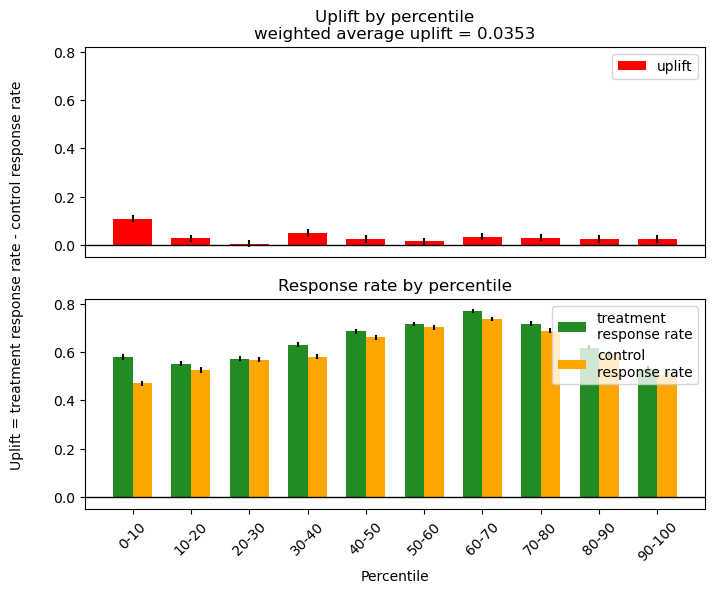

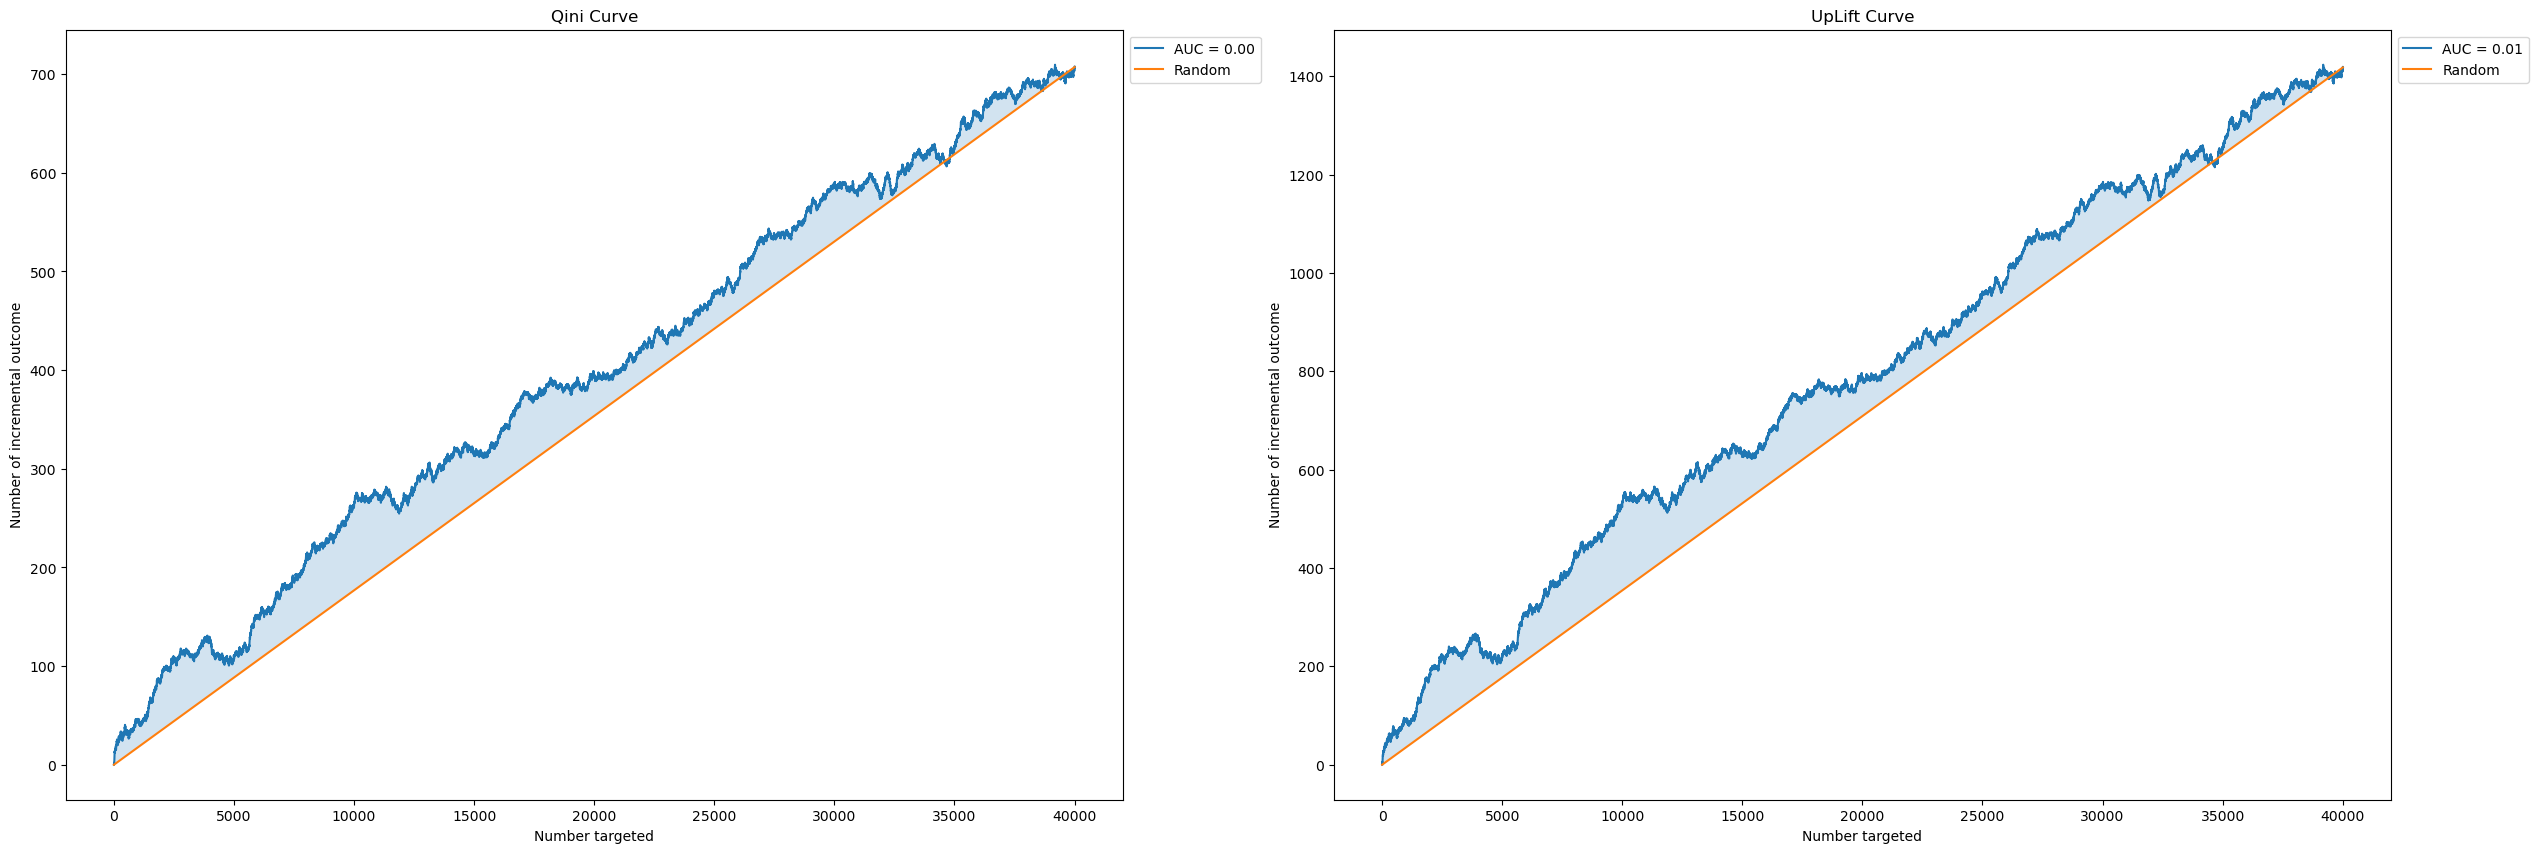

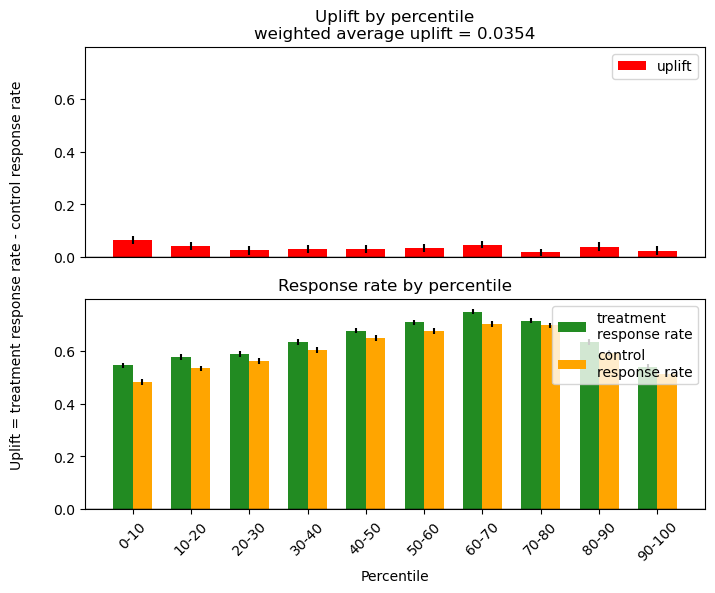

In [16]:
#Default data
skf = StratifiedKFold(n_splits=5)
skf.get_n_splits(X, y)
metrics = {'wau':[], 'uplift_k':[]}
i = 0

for train_index, test_index in skf.split(X, y):
      gc.collect()
      X_train_, X_test_ = X[train_index], X[test_index]
      y_train_, y_test_ = y[train_index], y[test_index]
      t_0 = np.argwhere(treat[train_index] == 0)
      t_1 = np.argwhere(treat[train_index] == 1)
      clf0 = CatBoostClassifier(verbose = 0, class_weights= [0.5, 0.5] )
      clf0.fit(np.squeeze(X_train_[t_0]), np.squeeze(y_train_[t_0]))
      clf1 = CatBoostClassifier(verbose = 0, class_weights= [0.5, 0.5] )
      clf1.fit(np.squeeze(X_train_[t_1]), np.squeeze(y_train_[t_1]))
      y_pred1 = clf1.predict_proba(X_test_).T[1]
      y_pred0 = clf0.predict_proba(X_test_).T[1]
      y_pred = y_pred1 - y_pred0
      del clf0
      del clf1
      del X_train_
      del y_train_
      del X_test_
      gc.collect()
      wau = weighted_average_uplift(y_true=y_test_ , uplift=y_pred,
                              treatment=treat[test_index])
      uplift_overall = uplift_at_k(y_true=y_test_ , uplift=y_pred,
                              treatment=treat[test_index], strategy='by_group', k=0.3)
      metrics['wau'].append(wau)
      metrics['uplift_k'].append(uplift_overall)
      i += 1
      print(f'Split {i}; WAU = {wau}; UpLift 30% {uplift_overall}')
      fig, ax = plt.subplots(1, 2, figsize = (30, 10))
      ax[0].set_title('Qini Curve')
      ax[1].set_title('UpLift Curve')
      plot_qini_curve(y_true=y_test_ , uplift=y_pred,
                              treatment=treat[test_index], ax = ax[0], perfect=False)
      gc.collect()
      plot_uplift_curve(y_true=y_test_ , uplift=y_pred,
                              treatment=treat[test_index], ax = ax[1], perfect=False)
      gc.collect()
      gc.collect()
      gc.collect()
      plt.savefig(f"Plots/Two model Split {i}.png")

      plot_uplift_by_percentile(y_true=y_test_ , uplift=y_pred,
                              treatment=treat[test_index], kind='bar')
      plt.savefig(f"Plots/Two model Procentile Split {i}.png")


wau = np.round(np.mean(metrics['wau']), 4)
uplift_overall = np.round(np.mean(metrics['uplift_k']), 4)
print(f'Mean WAU = {wau}; Mean UpLift 30% = {uplift_overall}')

In [17]:
gc.collect()

70620

# Метод трансформации класса

In [6]:


df= pd.read_csv(r'X5_clients_data_train.csv', sep = ';')
med = df.age.median()
df.age = df.age.apply(lambda x: x if((x >= 16) and (x <= 90)) else med)
df.age = df.age.fillna(med)
df.Mean_diffs = df.Mean_diffs.fillna(df.Mean_diffs.median()) 
df.first_order_date = df.first_order_date.swifter.apply(lambda x:  (pd.to_datetime('2019-03-19 00:00:00') - pd.to_datetime(x)) / np.timedelta64(1, 'D') )
df = df.fillna(0)
df.describe()
display(df)







client_id  regular_points_received  express_points_received  \
0       27159c9807                     17.1                      0.0   
1       b1b5ea0726                     21.2                      0.0   
2       8399c72ebf                     26.2                      0.0   
3       d5b8aff1ad                     13.7                      0.0   
4       a6fd598f71                     90.4                      0.0   
...            ...                      ...                      ...   
200034  fecd01be95                      6.4                      0.0   
200035  929c68106b                     12.9                      0.0   
200036  f183f1a613                     19.9                      0.0   
200037  226757e95c                     12.1                      0.0   
200038  72bf787388                     73.4                      0.0   

        regular_points_spent  express_points_spent  regular_balance  \
0                        0.0                   0.0             17.1   
1                        6.0                   0.0             15.2   
2                        0.0                   0.0             26.2   
3                        0.0                   0.0             13.7   
4                      149.0                   0.0            -58.6   
...                      ...                   ...              ...   
200034                   0.0                   0.0              6.4   
200035                   0.0                   0.0             12.9   
200036                  36.0                  40.0            -16.1   
200037                   0.0                   0.0             12.1   
200038                   0.0                   0.0             73.4   

        express_balance  Total_Amount  Amount_BonusDiscount_purchs  \
0                   0.0       2950.17                         0.00   
1                   0.0       2334.64                       190.75   
2                   0.0       4534.55                         0.00   
3                   0.0       2359.99                         0.00   
4                   0.0       8259.32                      1014.49   
...                 ...           ...                          ...   
200034              0.0       1398.80                         0.00   
200035              0.0       2051.93                         0.00   
200036            -40.0       4271.41                       426.61   
200037              0.0       2737.92                         0.00   
200038              0.0       6262.80                         0.00   

        BonusDiscount     MeanChk  avg_regular_points_received  \
0            0.000000  268.197273                     1.554545   
1            0.030496  466.928000                     4.240000   
2            0.000000  251.919444                     1.455556   
3            0.000000  181.537692                     1.053846   
4            0.128063  485.842353                     5.317647   
...               ...         ...                          ...   
200034       0.000000  155.422222                     0.711111   
200035       0.000000  512.982500                     3.225000   
200036       0.151211  328.570000                     1.530769   
200037       0.000000  210.609231                     0.930769   
200038       0.000000  782.850000                     9.175000   

        avg_express_points_received  avg_regular_points_spent  \
0                               0.0                  0.000000   
1                               0.0                  1.200000   
2                               0.0                  0.000000   
3                               0.0                  0.000000   
4                               0.0                  8.764706   
...                             ...                       ...   
200034                          0.0                  0.000000   
200035                          0.0                  0.000000   
200036                          0.0                  2.769231   
200037 

In [7]:
df = df.drop(['MeanItemCost', 'client_id'
                , 'Mean_TOP_1_BRAND'
                ,	'Mean_TOP_2_BRAND'
                ,	'Mean_TOP_3_BRAND'
                ,	'Mean_TOP_4_BRAND',
                	'Mean_TOP_5_BRAND',
                    'Mean_TOP_1_SEG',
                    'Mean_TOP_2_SEG',
                    'Mean_TOP_3_SEG',
                    'Mean_TOP_4_SEG',
                    'Mean_TOP_5_SEG',
                    #'first_order_date',
                    'Mean_alc'
                    ,'Mean_CTM'	
                    ,'Part_alc_purchs'	
                    ,'PArt_CTM_purchs'	
                    ,'cnt_alc_purchs'
                    ,'cnt_CTM_purchs'	], axis = 1)
# X = df.iloc[:, 0:-1].set_index('client_id')
# y = df.iloc[:, [0, -1]].set_index('client_id')
# del df
# gc.collect()
display(df.head())
treat = df.treatment_flg.values
targ = df.target.values
treat

regular_points_received  express_points_received  regular_points_spent  \
0                     17.1                      0.0                   0.0   
1                     21.2                      0.0                   6.0   
2                     26.2                      0.0                   0.0   
3                     13.7                      0.0                   0.0   
4                     90.4                      0.0                 149.0   

   express_points_spent  regular_balance  express_balance  Total_Amount  \
0                   0.0             17.1              0.0       2950.17   
1                   0.0             15.2              0.0       2334.64   
2                   0.0             26.2              0.0       4534.55   
3                   0.0             13.7              0.0       2359.99   
4                   0.0            -58.6              0.0       8259.32   

   Amount_BonusDiscount_purchs  BonusDiscount     MeanChk  \
0                         0.00       0.000000  268.197273   
1                       190.75       0.030496  466.928000   
2                         0.00       0.000000  251.919444   
3                         0.00       0.000000  181.537692   
4                      1014.49       0.128063  485.842353   

   avg_regular_points_received  avg_express_points_received  \
0                     1.554545                          0.0   
1                     4.240000                          0.0   
2                     1.455556                          0.0   
3                     1.053846                          0.0   
4                     5.317647                          0.0   

   avg_regular_points_spent  avg_express_points_spent  Chks  \
0                  0.000000                       0.0    11   
1                  1.200000                       0.0     5   
2                  0.000000                       0.0    18   
3                  0.000000                       0.0    13   
4                  8.764706                       0.0    17   

   Part_BonusDiscount_purchs  cnt_BonusDiscount_purchs  last_chk_ago  \
0                   0.000000                         0             7   
1                   0.200000                         1             7   
2                   0.000000                         0             3   
3                   0.000000                         0             0   
4                   0.117647                         2             0   

   Mean_diffs  first_order_date   age  LoveBonuses  Gender  treatment_flg  \
0        10.0        112.451586  26.0            0      -1              0   
1        19.0         86.568773  35.0            0      -1              1   
2         6.0        113.590799  23.0            2       0              1   
3         5.0         62.583831  69.0            0      -1              1   
4         6.0        111.589722  23.0            0      -1              1   

   target  
0       1  
1       0  
2       0  
3       1  
4       0

array([0, 1, 1, ..., 0, 1, 0], dtype=int64)

In [8]:

p = df[df.treatment_flg == 1].shape[0] / df.shape[0]
X = df.iloc[:, 0:-2].values
X = (X - X.mean()) / X.std()
y = df.target * (df.treatment_flg - p) / (1- p) / p
y = y.values
del df
gc.collect()
print(X)
print(y)
print(p)
# X_train, X_test, y_train, y_test = train_test_split(X, y)
# output.enable_custom_widget_manager()
# grid = {'learning_rate':  np.linspace(0, 0.05, 10)[1:-1],
#         'depth': [4, 6, 10],
#         'l2_leaf_reg': [1, 3, 5, 7, 9]}
# clf = CatBoostClassifier(verbose = 0)  
# grid_search_result = clf.grid_search(grid, 
#                                        X=X_train, 
#                                        y=y_train, 
#                                        plot=True)
from sklift.metrics import (
    uplift_at_k, uplift_auc_score, qini_auc_score, weighted_average_uplift
)

from sklift.viz import plot_qini_curve, plot_uplift_curve, plot_uplift_by_percentile
import matplotlib.pyplot as plt


[[-0.16332485 -0.16999312 -0.16999312 ... -0.15985423 -0.16999312
  -0.17038307]
 [-0.16172603 -0.16999312 -0.16765337 ... -0.15634462 -0.16999312
  -0.17038307]
 [-0.15977624 -0.16999312 -0.16999312 ... -0.1610241  -0.1692132
  -0.16999312]
 ...
 [-0.16223297 -0.16999312 -0.15595466 ... -0.15322496 -0.16999312
  -0.17038307]
 [-0.16527464 -0.16999312 -0.16999312 ... -0.15868436 -0.16999312
  -0.16999312]
 [-0.14137027 -0.16999312 -0.16999312 ... -0.16024419 -0.16999312
  -0.17038307]]
[-1.99923045  0.          0.         ... -1.99923045  0.
 -1.99923045]
0.4998075375301816


Split 1; WAU = 0.03364686223521897; UpLift 30% = 0.05824544969660295


c:\Users\Kirill\.conda\envs\automl\lib\site-packages\numpy\core\fromnumeric.py:3199: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).ndim


Split 2; WAU = 0.033039119558824534; UpLift 30% = 0.04297032944467205


c:\Users\Kirill\.conda\envs\automl\lib\site-packages\numpy\core\fromnumeric.py:3199: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).ndim


Split 3; WAU = 0.028614904573192042; UpLift 30% = 0.0410709886392957


c:\Users\Kirill\.conda\envs\automl\lib\site-packages\numpy\core\fromnumeric.py:3199: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).ndim


Split 4; WAU = 0.03432140992700286; UpLift 30% = 0.04057977607652841


c:\Users\Kirill\.conda\envs\automl\lib\site-packages\numpy\core\fromnumeric.py:3199: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).ndim


Split 5; WAU = 0.03580770668907162; UpLift 30% = 0.04485395045412022


c:\Users\Kirill\.conda\envs\automl\lib\site-packages\numpy\core\fromnumeric.py:3199: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).ndim


Mean WAU = 0.0331; Mean UpLift 30% = 0.0455


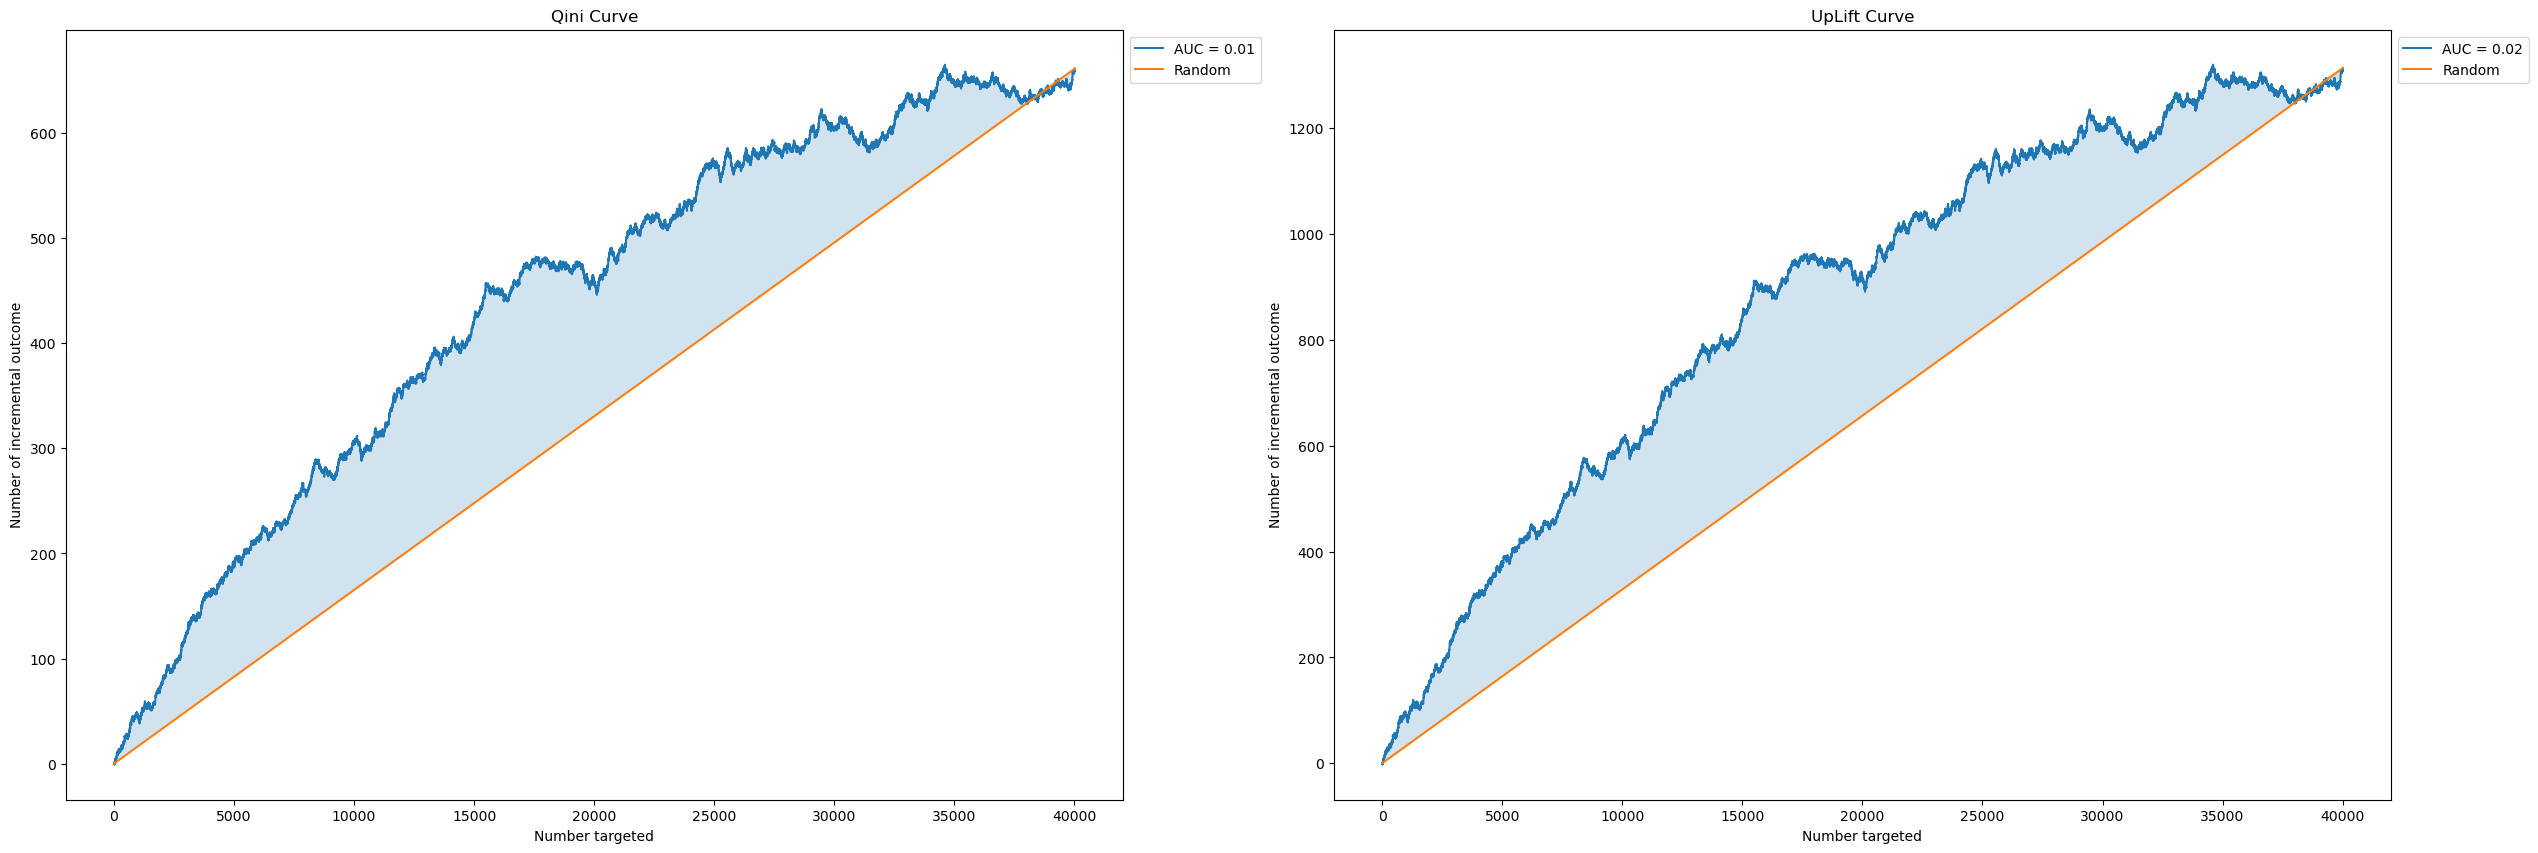

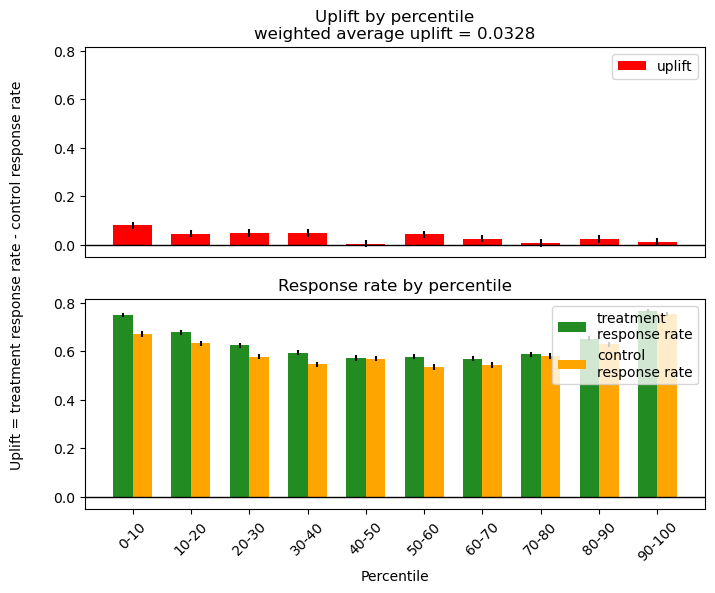

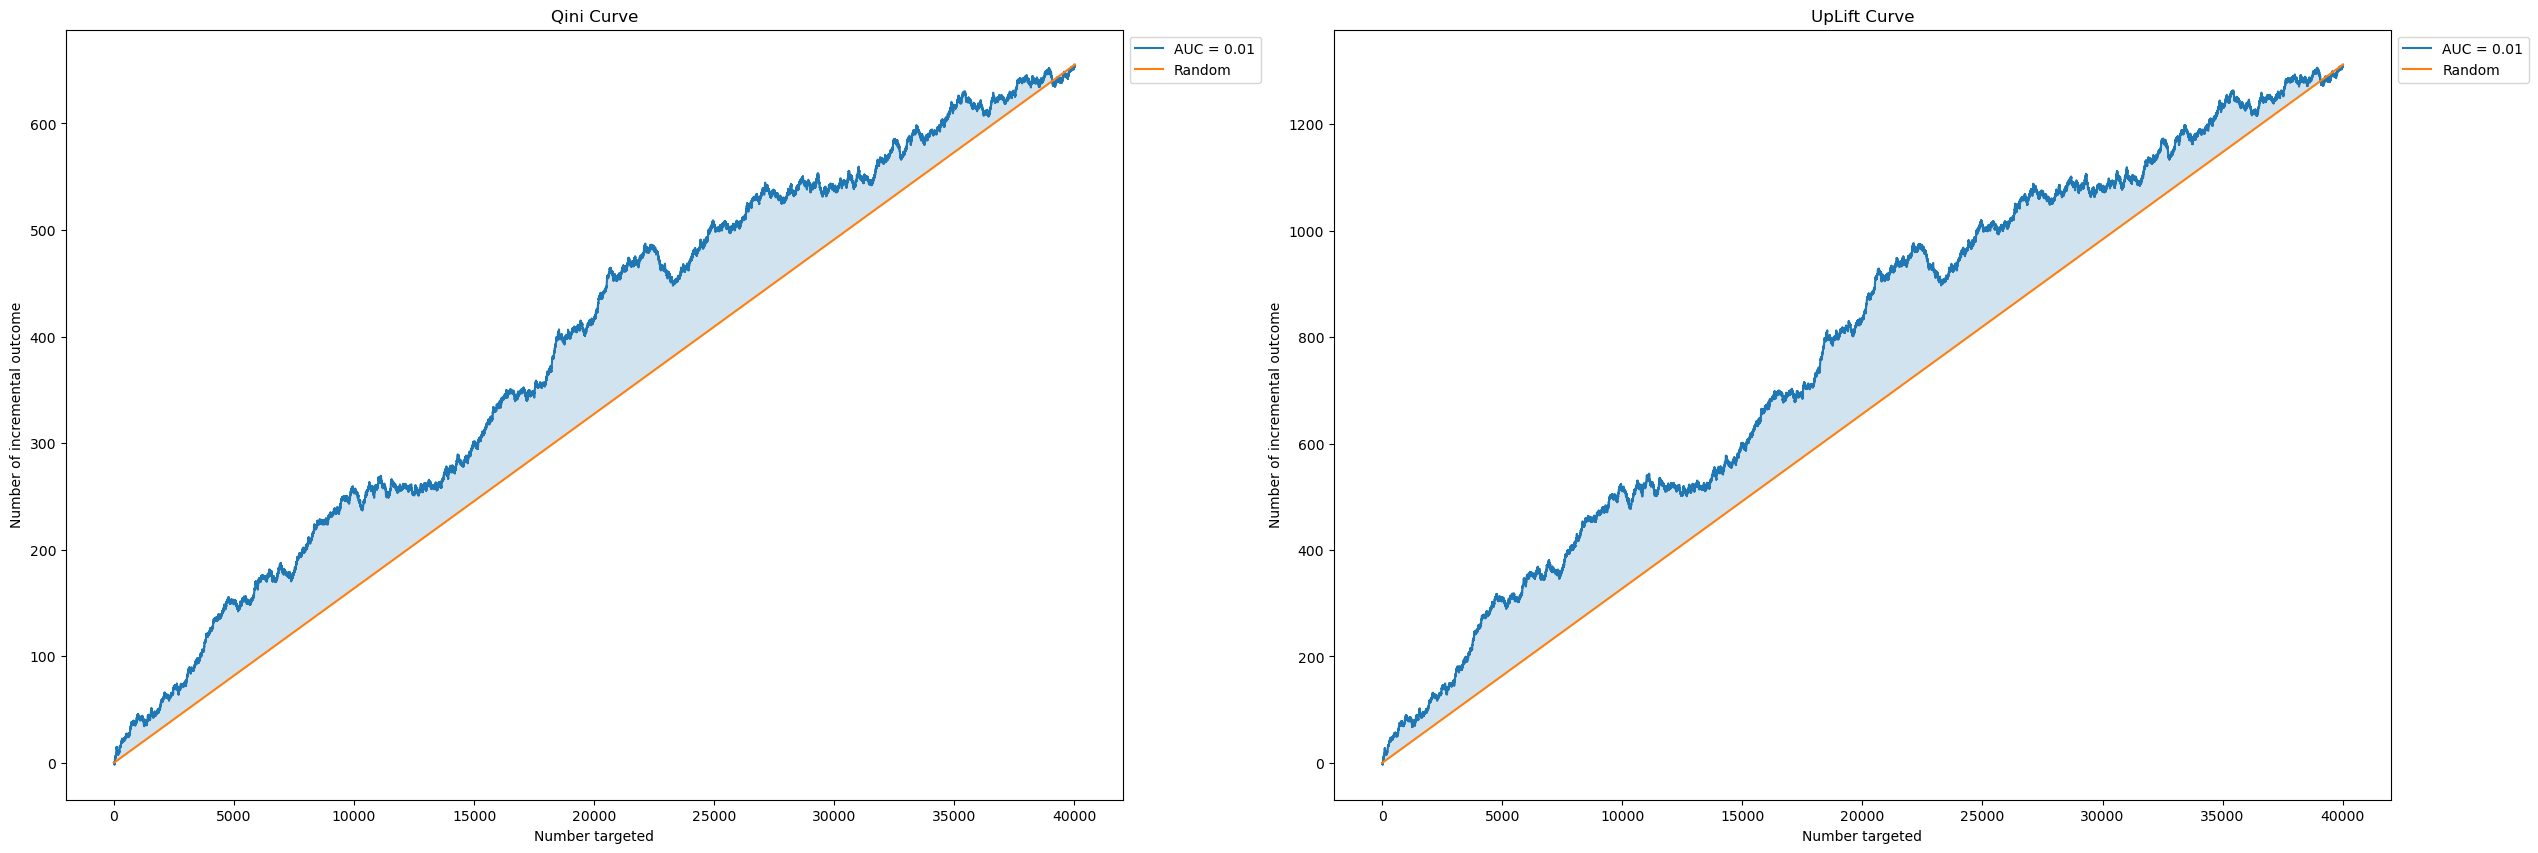

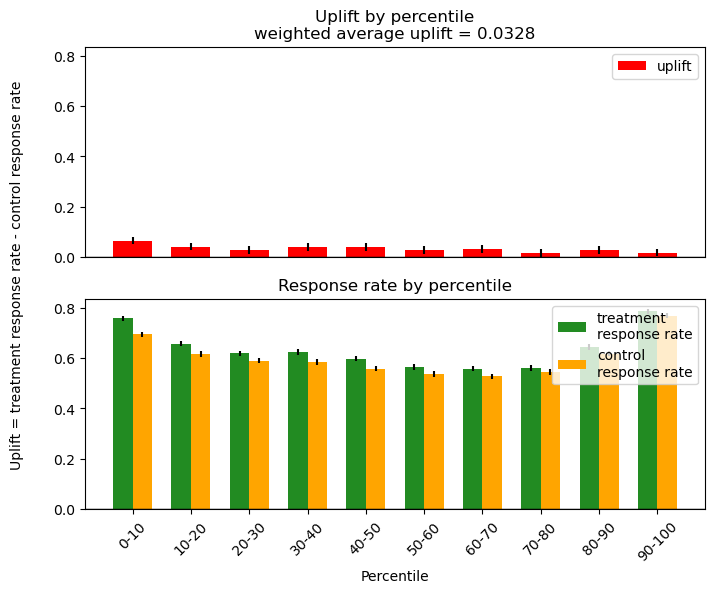

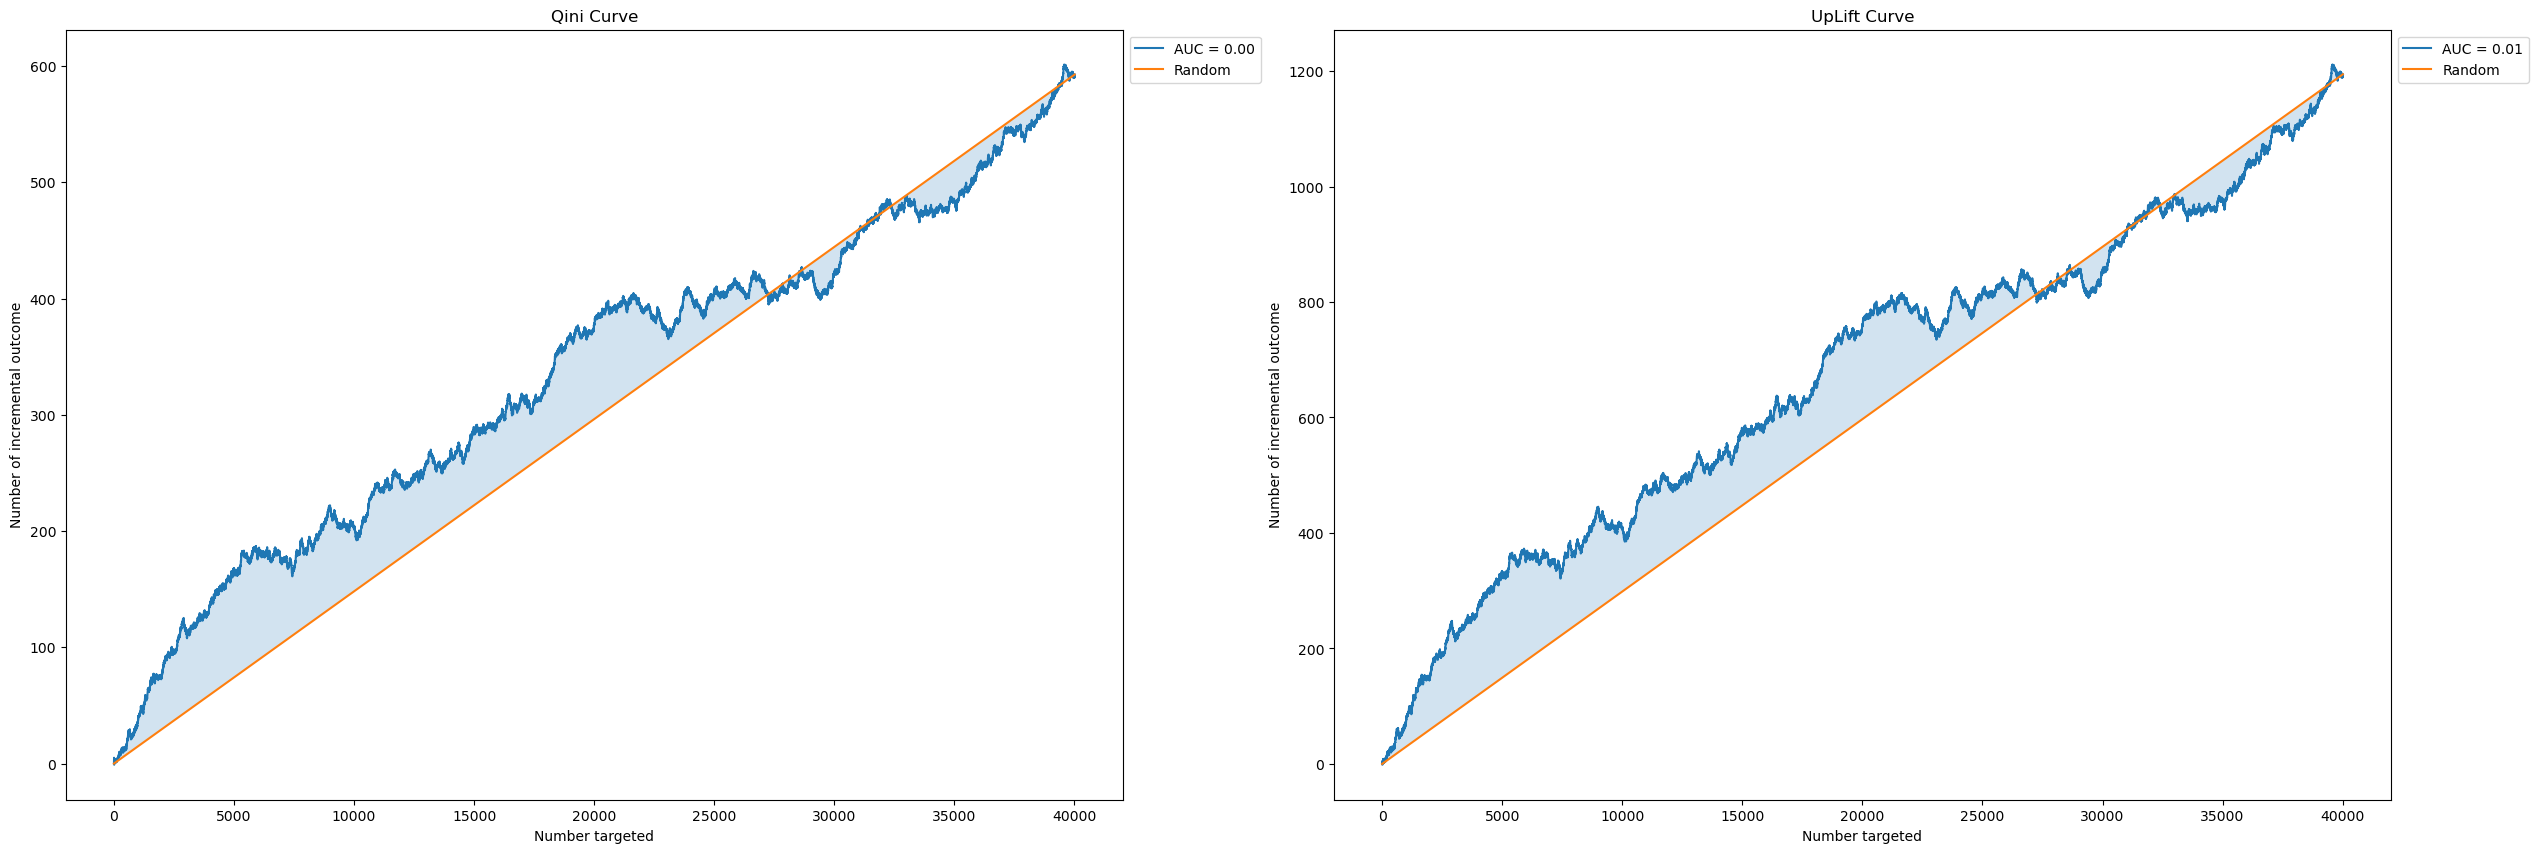

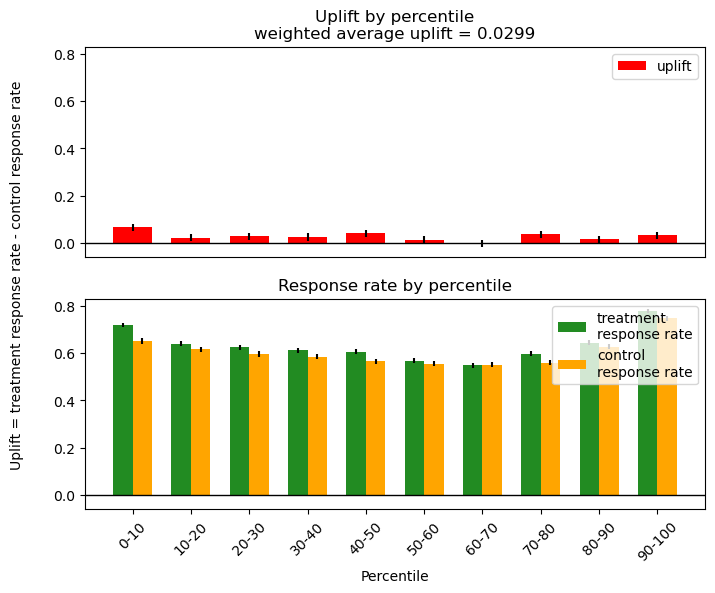

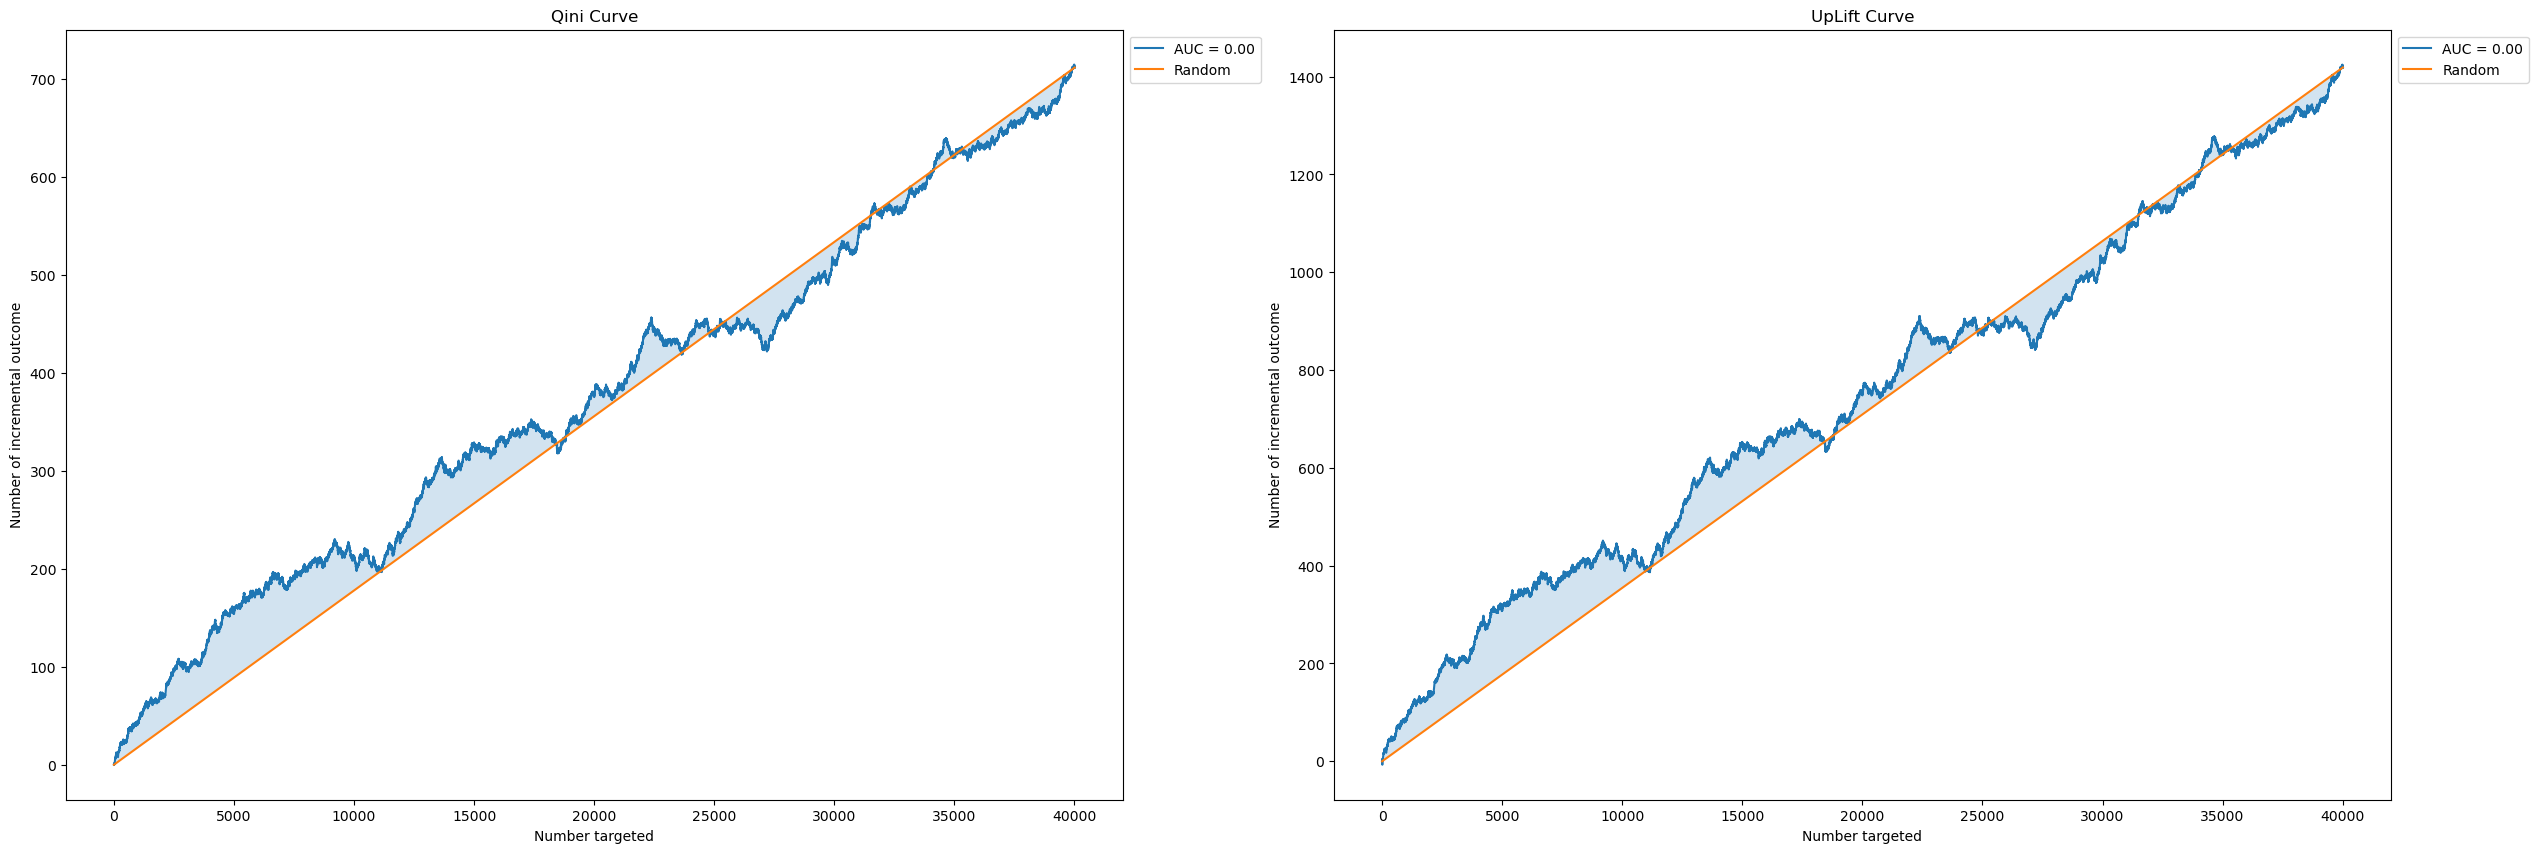

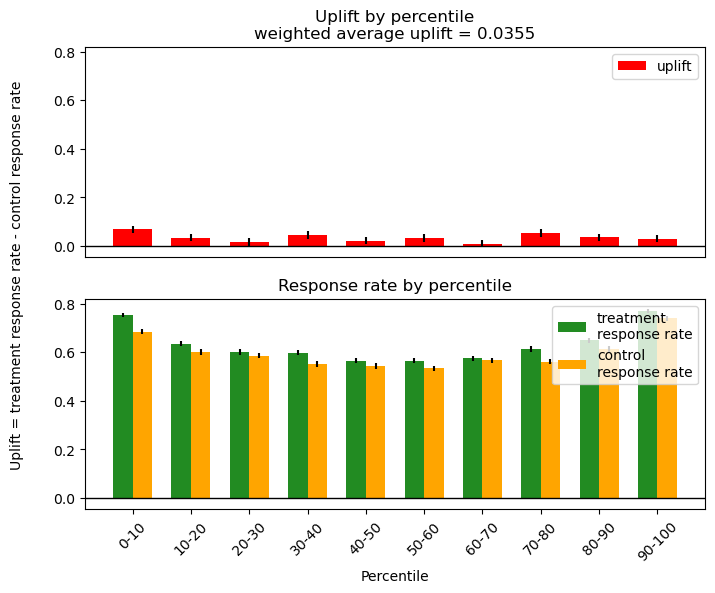

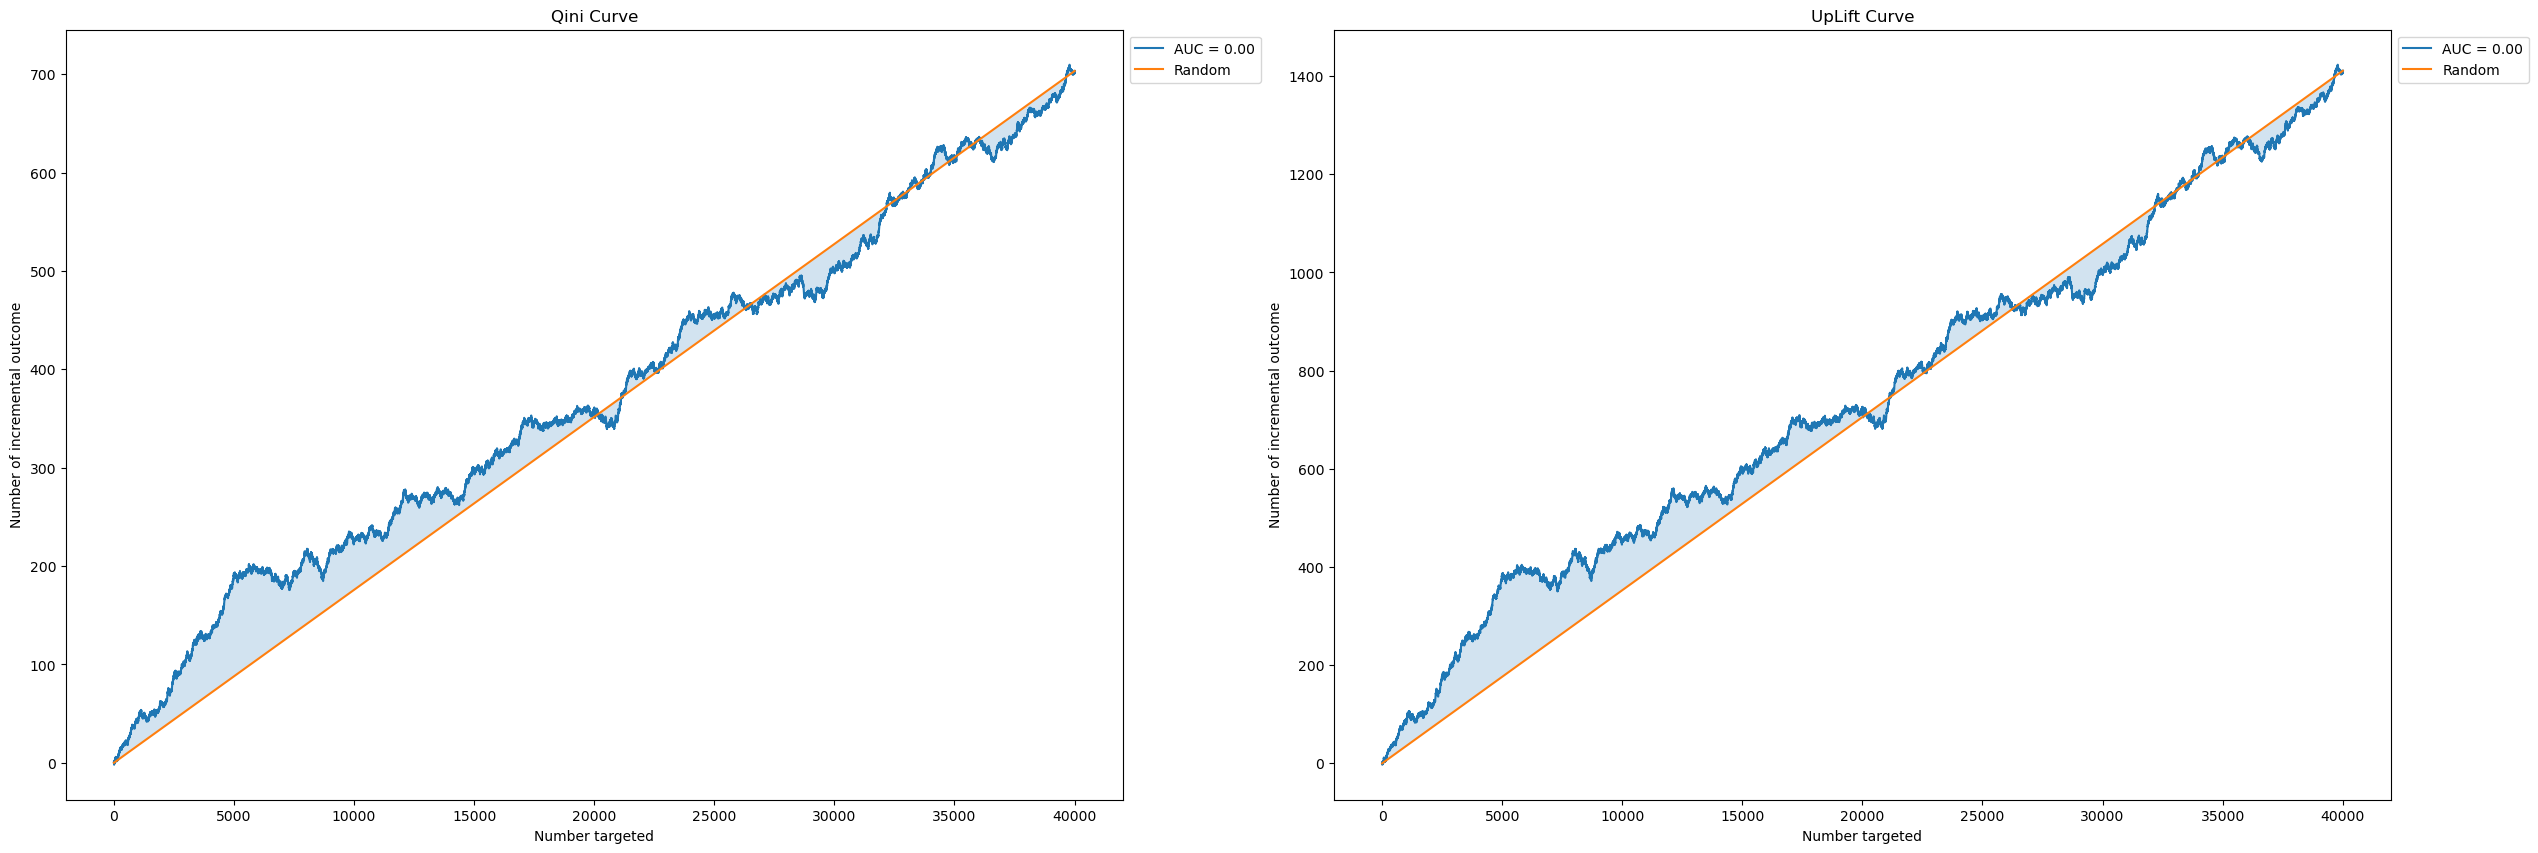

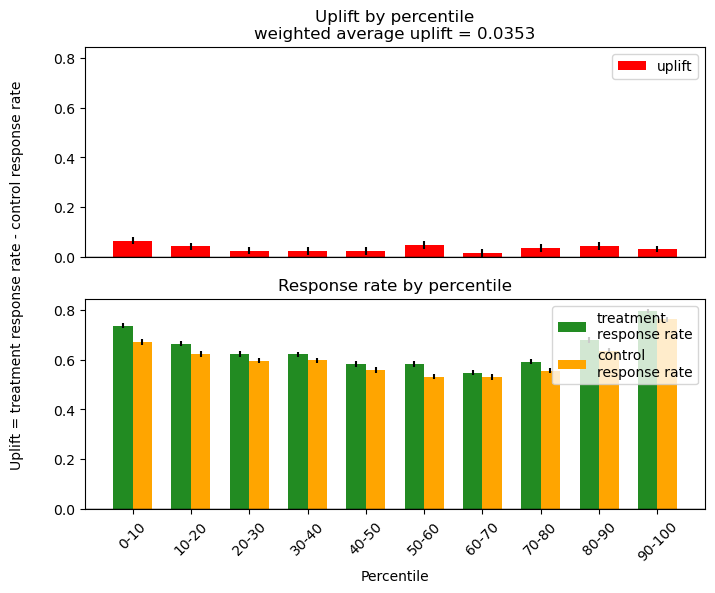

In [9]:
# Метод двух моделей
#Default data
skf = KFold(n_splits=5)
skf.get_n_splits(X, y)
metrics = {'wau':[], 'uplift_k':[]}
i = 0

for train_index, test_index in skf.split(X, y):
      gc.collect()
      X_train_, X_test_ = X[train_index], X[test_index]
      y_train_, y_test_ = y[train_index], y[test_index]
      reg = CatBoostRegressor(verbose=0)
      reg.fit(X_train_, y_train_)
      y_pred = reg.predict(X_test_)
      del reg
      del X_train_
      del y_train_
      del X_test_
      gc.collect()
      wau = weighted_average_uplift(y_true=targ[test_index] , uplift=y_pred,
                              treatment=treat[test_index])
      uplift_overall = uplift_at_k(y_true=targ[test_index] , uplift=y_pred,
                              treatment=treat[test_index], strategy='by_group', k=0.3)
      metrics['wau'].append(wau)
      metrics['uplift_k'].append(uplift_overall)
      i += 1
      print(f'Split {i}; WAU = {wau}; UpLift 30% = {uplift_overall}')
      fig, ax = plt.subplots(1, 2, figsize = (30, 10))
      ax[0].set_title('Qini Curve')
      ax[1].set_title('UpLift Curve')
      plot_qini_curve(y_true=targ[test_index] , uplift=y_pred,
                              treatment=treat[test_index], ax = ax[0], perfect=False)
      gc.collect()
      plot_uplift_curve(y_true=targ[test_index] , uplift=y_pred,
                              treatment=treat[test_index], ax = ax[1], perfect=False)
      gc.collect()
      gc.collect()
      gc.collect()
      plt.savefig(f"Plots/Regression model Split {i}.png")

      plot_uplift_by_percentile(y_true=targ[test_index], uplift=y_pred,
                              treatment=treat[test_index], kind='bar')
      plt.savefig(f"Plots/Regression model Procentile Split {i}.png")


wau = np.round(np.mean(metrics['wau']), 4)
uplift_overall = np.round(np.mean(metrics['uplift_k']), 4)
print(f'Mean WAU = {wau}; Mean UpLift 30% = {uplift_overall}')


In [42]:
gc.collect()

70278

# AutoML

In [10]:




df= pd.read_csv(r'X5_clients_data_train.csv', sep = ';')
med = df.age.median()
df.age = df.age.apply(lambda x: x if((x >= 16) and (x <= 90)) else med)
df.age = df.age.fillna(med)
df.Mean_diffs = df.Mean_diffs.fillna(df.Mean_diffs.median()) 
df.first_order_date = df.first_order_date.swifter.apply(lambda x:  (pd.to_datetime('2019-03-19 00:00:00') - pd.to_datetime(x)) / np.timedelta64(1, 'D') )
df = df.fillna(0)
df.describe()
display(df)











df = df.drop(['MeanItemCost', 'client_id'
                , 'Mean_TOP_1_BRAND'
                ,	'Mean_TOP_2_BRAND'
                ,	'Mean_TOP_3_BRAND'
                ,	'Mean_TOP_4_BRAND',
                	'Mean_TOP_5_BRAND',
                    'Mean_TOP_1_SEG',
                    'Mean_TOP_2_SEG',
                    'Mean_TOP_3_SEG',
                    'Mean_TOP_4_SEG',
                    'Mean_TOP_5_SEG',
                    #'first_order_date',
                    'Mean_alc'
                    ,'Mean_CTM'	
                    ,'Part_alc_purchs'	
                    ,'PArt_CTM_purchs'	
                    ,'cnt_alc_purchs'
                    ,'cnt_CTM_purchs'	], axis = 1)
# X = df.iloc[:, 0:-1].set_index('client_id')
# y = df.iloc[:, [0, -1]].set_index('client_id')
# del df
# gc.collect()
treat = df.treatment_flg.values
targ = df.target.values
treat

p = df[df.treatment_flg == 1].shape[0] / df.shape[0]
X = df.iloc[:, 0:-2].values
#X = (X - X.mean()) / X.std()
y = df.target * (df.treatment_flg - p) / (1- p) / p
y = y.values
features = df.columns.tolist()
del df
gc.collect()
print(X)
print(y)
print(p)
# X_train, X_test, y_train, y_test = train_test_split(X, y)
# output.enable_custom_widget_manager()
# grid = {'learning_rate':  np.linspace(0, 0.05, 10)[1:-1],
#         'depth': [4, 6, 10],
#         'l2_leaf_reg': [1, 3, 5, 7, 9]}
# clf = CatBoostClassifier(verbose = 0)  
# grid_search_result = clf.grid_search(grid, 
#                                        X=X_train, 
#                                        y=y_train, 
#                                        plot=True)
from sklift.metrics import (
    uplift_at_k, uplift_auc_score, qini_auc_score, weighted_average_uplift
)

from sklift.viz import plot_qini_curve, plot_uplift_curve, plot_uplift_by_percentile
import matplotlib.pyplot as plt


client_id  regular_points_received  express_points_received  \
0       27159c9807                     17.1                      0.0   
1       b1b5ea0726                     21.2                      0.0   
2       8399c72ebf                     26.2                      0.0   
3       d5b8aff1ad                     13.7                      0.0   
4       a6fd598f71                     90.4                      0.0   
...            ...                      ...                      ...   
200034  fecd01be95                      6.4                      0.0   
200035  929c68106b                     12.9                      0.0   
200036  f183f1a613                     19.9                      0.0   
200037  226757e95c                     12.1                      0.0   
200038  72bf787388                     73.4                      0.0   

        regular_points_spent  express_points_spent  regular_balance  \
0                        0.0                   0.0             17.1   
1                        6.0                   0.0             15.2   
2                        0.0                   0.0             26.2   
3                        0.0                   0.0             13.7   
4                      149.0                   0.0            -58.6   
...                      ...                   ...              ...   
200034                   0.0                   0.0              6.4   
200035                   0.0                   0.0             12.9   
200036                  36.0                  40.0            -16.1   
200037                   0.0                   0.0             12.1   
200038                   0.0                   0.0             73.4   

        express_balance  Total_Amount  Amount_BonusDiscount_purchs  \
0                   0.0       2950.17                         0.00   
1                   0.0       2334.64                       190.75   
2                   0.0       4534.55                         0.00   
3                   0.0       2359.99                         0.00   
4                   0.0       8259.32                      1014.49   
...                 ...           ...                          ...   
200034              0.0       1398.80                         0.00   
200035              0.0       2051.93                         0.00   
200036            -40.0       4271.41                       426.61   
200037              0.0       2737.92                         0.00   
200038              0.0       6262.80                         0.00   

        BonusDiscount     MeanChk  avg_regular_points_received  \
0            0.000000  268.197273                     1.554545   
1            0.030496  466.928000                     4.240000   
2            0.000000  251.919444                     1.455556   
3            0.000000  181.537692                     1.053846   
4            0.128063  485.842353                     5.317647   
...               ...         ...                          ...   
200034       0.000000  155.422222                     0.711111   
200035       0.000000  512.982500                     3.225000   
200036       0.151211  328.570000                     1.530769   
200037       0.000000  210.609231                     0.930769   
200038       0.000000  782.850000                     9.175000   

        avg_express_points_received  avg_regular_points_spent  \
0                               0.0                  0.000000   
1                               0.0                  1.200000   
2                               0.0                  0.000000   
3                               0.0                  0.000000   
4                               0.0                  8.764706   
...                             ...                       ...   
200034                          0.0                  0.000000   
200035                          0.0                  0.000000   
200036                          0.0                  2.769231   
200037 

[[17.1  0.   0.  ... 26.   0.  -1. ]
 [21.2  0.   6.  ... 35.   0.  -1. ]
 [26.2  0.   0.  ... 23.   2.   0. ]
 ...
 [19.9  0.  36.  ... 43.   0.  -1. ]
 [12.1  0.   0.  ... 29.   0.   0. ]
 [73.4  0.   0.  ... 25.   0.  -1. ]]
[-1.99923045  0.          0.         ... -1.99923045  0.
 -1.99923045]
0.4998075375301816


In [11]:
import evalml
from evalml import AutoMLSearch

In [12]:
X_train,X_test,y_train,y_test=evalml.preprocessing.split_data(X, y,problem_type='regression')

In [13]:
automl=AutoMLSearch(X_train = X_train
                    , y_train = y_train
                    , n_jobs = -1
                    , problem_type='regression'
                    , verbose = True
                    , allow_long_running_models = True
                    , max_batches = 50
                    , objective = 'Root Mean Squared Error'
                    #, optimize_thresholds=True
                    , train_best_pipeline= True
                    , ensembling=True
                    , max_iterations = 50
                    
                    
                    #, allowed_model_families = evalml.pipelines.components.utils.allowed_model_families('binary')
                    )


automl.search()

AutoMLSearch will use mean CV score to rank pipelines.

*****************************
* Beginning pipeline search *
*****************************

Optimizing for Root Mean Squared Error. 
Lower score is better.

Using SequentialEngine to train and score pipelines.
Searching up to 50 batches for a total of 50 pipelines. 
Allowed model families: 



FigureWidget({
    'data': [{'mode': 'lines+markers',
              'name': 'Best Score',
              'type'…

Evaluating Baseline Pipeline: Mean Baseline Regression Pipeline
Mean Baseline Regression Pipeline:
	Starting cross validation
	Finished cross validation - mean Root Mean Squared Error: 1.575

*****************************
* Evaluating Batch Number 1 *
*****************************

Elastic Net Regressor w/ Replace Nullable Types Transformer + Imputer + Standard Scaler:
	Starting cross validation
	Finished cross validation - mean Root Mean Squared Error: 1.575
Random Forest Regressor w/ Replace Nullable Types Transformer + Imputer:
	Starting cross validation
	Finished cross validation - mean Root Mean Squared Error: 1.575

*****************************
* Evaluating Batch Number 2 *
*****************************

Elastic Net Regressor w/ Replace Nullable Types Transformer + Imputer + Standard Scaler + RF Regressor Select From Model:
	Starting cross validation
	Finished cross validation - mean Root Mean Squared Error: 1.575
Random Forest Regressor w/ Replace Nullable Types Transformer + I

{1: {'Elastic Net Regressor w/ Replace Nullable Types Transformer + Imputer + Standard Scaler': '00:01',
  'Random Forest Regressor w/ Replace Nullable Types Transformer + Imputer': '00:03',
  'Total time of batch': '00:05'},
 2: {'Elastic Net Regressor w/ Replace Nullable Types Transformer + Imputer + Standard Scaler + RF Regressor Select From Model': '00:02',
  'Random Forest Regressor w/ Replace Nullable Types Transformer + Imputer + RF Regressor Select From Model': '00:04',
  'Total time of batch': '00:07'},
 3: {'Decision Tree Regressor w/ Replace Nullable Types Transformer + Imputer + Select Columns Transformer': '00:00',
  'Extra Trees Regressor w/ Replace Nullable Types Transformer + Imputer + Select Columns Transformer': '00:01',
  'XGBoost Regressor w/ Replace Nullable Types Transformer + Imputer + Select Columns Transformer': '00:02',
  'CatBoost Regressor w/ Replace Nullable Types Transformer + Imputer + Select Columns Transformer': '00:00',
  'LightGBM Regressor w/ Replace

In [14]:
automl.save('automl_big_searching.cloudpickle')

## Train Best Pipeline

In [15]:
import evalml
from evalml import AutoMLSearch
automl = AutoMLSearch.load('automl_big_searching.cloudpickle')


In [16]:
ranks = automl.rankings
ranks = ranks.drop(['id', 'search_order'	,'mean_cv_score'	,'standard_deviation_cv_score', 'high_variance_cv'], axis = 1)

In [17]:
ranks.to_csv('evalml_res.csv', index = False)

In [18]:
ranks.head()

pipeline_name  validation_score  \
0   CatBoost Regressor w/ Replace Nullable Types T...          1.574493   
1   Extra Trees Regressor w/ Replace Nullable Type...          1.574533   
2                   Mean Baseline Regression Pipeline          1.574535   
3   Elastic Net Regressor w/ Replace Nullable Type...          1.574535   
26  Elastic Net Regressor w/ Replace Nullable Type...          1.574668   

    percent_better_than_baseline  \
0                       0.002634   
1                       0.000135   
2                       0.000000   
3                       0.000000   
26                     -0.008450   

                                           parameters  
0   {'Imputer': {'categorical_impute_strategy': 'm...  
1   {'Imputer': {'categorical_impute_strategy': 'm...  
2        {'Baseline Regressor': {'strategy': 'mean'}}  
3   {'Imputer': {'categorical_impute_strategy': 'm...  
26  {'Imputer': {'categorical_impute_strategy': 'm...

In [19]:
ranks.shape

(12, 4)

In [20]:

ranks.head(4).to_excel('res.xlsx')

In [21]:
ranks.iloc[0, :].parameters

{'Imputer': {'categorical_impute_strategy': 'most_frequent',
  'numeric_impute_strategy': 'mean',
  'boolean_impute_strategy': 'most_frequent',
  'categorical_fill_value': None,
  'numeric_fill_value': None,
  'boolean_fill_value': None},
 'Select Columns Transformer': {'columns': [0,
   4,
   6,
   7,
   8,
   9,
   10,
   12,
   14,
   17,
   19,
   20]},
 'CatBoost Regressor': {'n_estimators': 10,
  'eta': 0.03,
  'max_depth': 6,
  'bootstrap_type': None,
  'silent': False,
  'allow_writing_files': False,
  'n_jobs': -1}}

In [22]:
ctbst  = automl.best_pipeline
type(ctbst)

evalml.pipelines.regression_pipeline.RegressionPipeline

In [23]:
best_features = ctbst.feature_importance.copy()
best_features = best_features[best_features.importance > .01]
best_features

feature  importance
0        20   20.495870
1         8   13.406594
2        10   10.214334
3         9    9.620307
4        14    8.800532
5        19    8.504523
6         0    8.063039
7         7    7.588954
8        12    5.002728
9         6    3.895416
10        4    2.525082
11       17    1.882620

In [24]:
best_features['Name'] = best_features.feature.apply(lambda x: features[x])
best_features

feature  importance                         Name
0        20   20.495870                          age
1         8   13.406594                BonusDiscount
2        10   10.214334  avg_regular_points_received
3         9    9.620307                      MeanChk
4        14    8.800532                         Chks
5        19    8.504523             first_order_date
6         0    8.063039      regular_points_received
7         7    7.588954  Amount_BonusDiscount_purchs
8        12    5.002728     avg_regular_points_spent
9         6    3.895416                 Total_Amount
10        4    2.525082              regular_balance
11       17    1.882620                 last_chk_ago

In [25]:


df= pd.read_csv(r'X5_clients_data_train.csv', sep = ';')
med = df.age.median()
df.age = df.age.apply(lambda x: x if((x >= 16) and (x <= 90)) else med)
df.age = df.age.fillna(med)
df.Mean_diffs = df.Mean_diffs.fillna(df.Mean_diffs.median()) 
df.first_order_date = df.first_order_date.swifter.apply(lambda x:  (pd.to_datetime('2019-03-19 00:00:00') - pd.to_datetime(x)) / np.timedelta64(1, 'D') )
df = df.fillna(0)
df.describe()
display(df)







client_id  regular_points_received  express_points_received  \
0       27159c9807                     17.1                      0.0   
1       b1b5ea0726                     21.2                      0.0   
2       8399c72ebf                     26.2                      0.0   
3       d5b8aff1ad                     13.7                      0.0   
4       a6fd598f71                     90.4                      0.0   
...            ...                      ...                      ...   
200034  fecd01be95                      6.4                      0.0   
200035  929c68106b                     12.9                      0.0   
200036  f183f1a613                     19.9                      0.0   
200037  226757e95c                     12.1                      0.0   
200038  72bf787388                     73.4                      0.0   

        regular_points_spent  express_points_spent  regular_balance  \
0                        0.0                   0.0             17.1   
1                        6.0                   0.0             15.2   
2                        0.0                   0.0             26.2   
3                        0.0                   0.0             13.7   
4                      149.0                   0.0            -58.6   
...                      ...                   ...              ...   
200034                   0.0                   0.0              6.4   
200035                   0.0                   0.0             12.9   
200036                  36.0                  40.0            -16.1   
200037                   0.0                   0.0             12.1   
200038                   0.0                   0.0             73.4   

        express_balance  Total_Amount  Amount_BonusDiscount_purchs  \
0                   0.0       2950.17                         0.00   
1                   0.0       2334.64                       190.75   
2                   0.0       4534.55                         0.00   
3                   0.0       2359.99                         0.00   
4                   0.0       8259.32                      1014.49   
...                 ...           ...                          ...   
200034              0.0       1398.80                         0.00   
200035              0.0       2051.93                         0.00   
200036            -40.0       4271.41                       426.61   
200037              0.0       2737.92                         0.00   
200038              0.0       6262.80                         0.00   

        BonusDiscount     MeanChk  avg_regular_points_received  \
0            0.000000  268.197273                     1.554545   
1            0.030496  466.928000                     4.240000   
2            0.000000  251.919444                     1.455556   
3            0.000000  181.537692                     1.053846   
4            0.128063  485.842353                     5.317647   
...               ...         ...                          ...   
200034       0.000000  155.422222                     0.711111   
200035       0.000000  512.982500                     3.225000   
200036       0.151211  328.570000                     1.530769   
200037       0.000000  210.609231                     0.930769   
200038       0.000000  782.850000                     9.175000   

        avg_express_points_received  avg_regular_points_spent  \
0                               0.0                  0.000000   
1                               0.0                  1.200000   
2                               0.0                  0.000000   
3                               0.0                  0.000000   
4                               0.0                  8.764706   
...                             ...                       ...   
200034                          0.0                  0.000000   
200035                          0.0                  0.000000   
200036                          0.0                  2.769231   
200037 

In [26]:
df = df.drop(['MeanItemCost', 'client_id'
                , 'Mean_TOP_1_BRAND'
                ,	'Mean_TOP_2_BRAND'
                ,	'Mean_TOP_3_BRAND'
                ,	'Mean_TOP_4_BRAND',
                	'Mean_TOP_5_BRAND',
                    'Mean_TOP_1_SEG',
                    'Mean_TOP_2_SEG',
                    'Mean_TOP_3_SEG',
                    'Mean_TOP_4_SEG',
                    'Mean_TOP_5_SEG',
                    #'first_order_date',
                    'Mean_alc'
                    ,'Mean_CTM'	
                    ,'Part_alc_purchs'	
                    ,'PArt_CTM_purchs'	
                    ,'cnt_alc_purchs'
                    ,'cnt_CTM_purchs'], axis = 1)
# X = df.iloc[:, 0:-1].set_index('client_id')
# y = df.iloc[:, [0, -1]].set_index('client_id')
# del df
# gc.collect()
treat = df.treatment_flg.values
targ = df.target.values
treat

array([0, 1, 1, ..., 0, 1, 0], dtype=int64)

In [27]:

p = df[df.treatment_flg == 1].shape[0] / df.shape[0]
X = df.iloc[:, 0:-2].values
X = (X - X.mean()) / X.std()
y = df.target * (df.treatment_flg - p) / (1- p) / p
y = y.values
del df
gc.collect()
print(X)
print(y)
print(p)
# X_train, X_test, y_train, y_test = train_test_split(X, y)
# output.enable_custom_widget_manager()
# grid = {'learning_rate':  np.linspace(0, 0.05, 10)[1:-1],
#         'depth': [4, 6, 10],
#         'l2_leaf_reg': [1, 3, 5, 7, 9]}
# clf = CatBoostClassifier(verbose = 0)  
# grid_search_result = clf.grid_search(grid, 
#                                        X=X_train, 
#                                        y=y_train, 
#                                        plot=True)
from sklift.metrics import (
    uplift_at_k, uplift_auc_score, qini_auc_score, weighted_average_uplift
)

from sklift.viz import plot_qini_curve, plot_uplift_curve, plot_uplift_by_percentile
import matplotlib.pyplot as plt


[[-0.16332485 -0.16999312 -0.16999312 ... -0.15985423 -0.16999312
  -0.17038307]
 [-0.16172603 -0.16999312 -0.16765337 ... -0.15634462 -0.16999312
  -0.17038307]
 [-0.15977624 -0.16999312 -0.16999312 ... -0.1610241  -0.1692132
  -0.16999312]
 ...
 [-0.16223297 -0.16999312 -0.15595466 ... -0.15322496 -0.16999312
  -0.17038307]
 [-0.16527464 -0.16999312 -0.16999312 ... -0.15868436 -0.16999312
  -0.16999312]
 [-0.14137027 -0.16999312 -0.16999312 ... -0.16024419 -0.16999312
  -0.17038307]]
[-1.99923045  0.          0.         ... -1.99923045  0.
 -1.99923045]
0.4998075375301816


Split 1; WAU = 0.03291525518187859; UpLift 30% = 0.03789341307251759


c:\Users\Kirill\.conda\envs\automl\lib\site-packages\numpy\core\fromnumeric.py:3199: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.



Split 2; WAU = 0.03263520985815804; UpLift 30% = 0.029399756442060276


c:\Users\Kirill\.conda\envs\automl\lib\site-packages\numpy\core\fromnumeric.py:3199: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.



Split 3; WAU = 0.02980274844153351; UpLift 30% = 0.026427142814687166


c:\Users\Kirill\.conda\envs\automl\lib\site-packages\numpy\core\fromnumeric.py:3199: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.



Split 4; WAU = 0.03560810955534685; UpLift 30% = 0.03792114102841626


c:\Users\Kirill\.conda\envs\automl\lib\site-packages\numpy\core\fromnumeric.py:3199: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.



Split 5; WAU = 0.03526440712761391; UpLift 30% = 0.02785898260767794


c:\Users\Kirill\.conda\envs\automl\lib\site-packages\numpy\core\fromnumeric.py:3199: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.



Mean WAU = 0.0332; Mean UpLift 30% = 0.0319


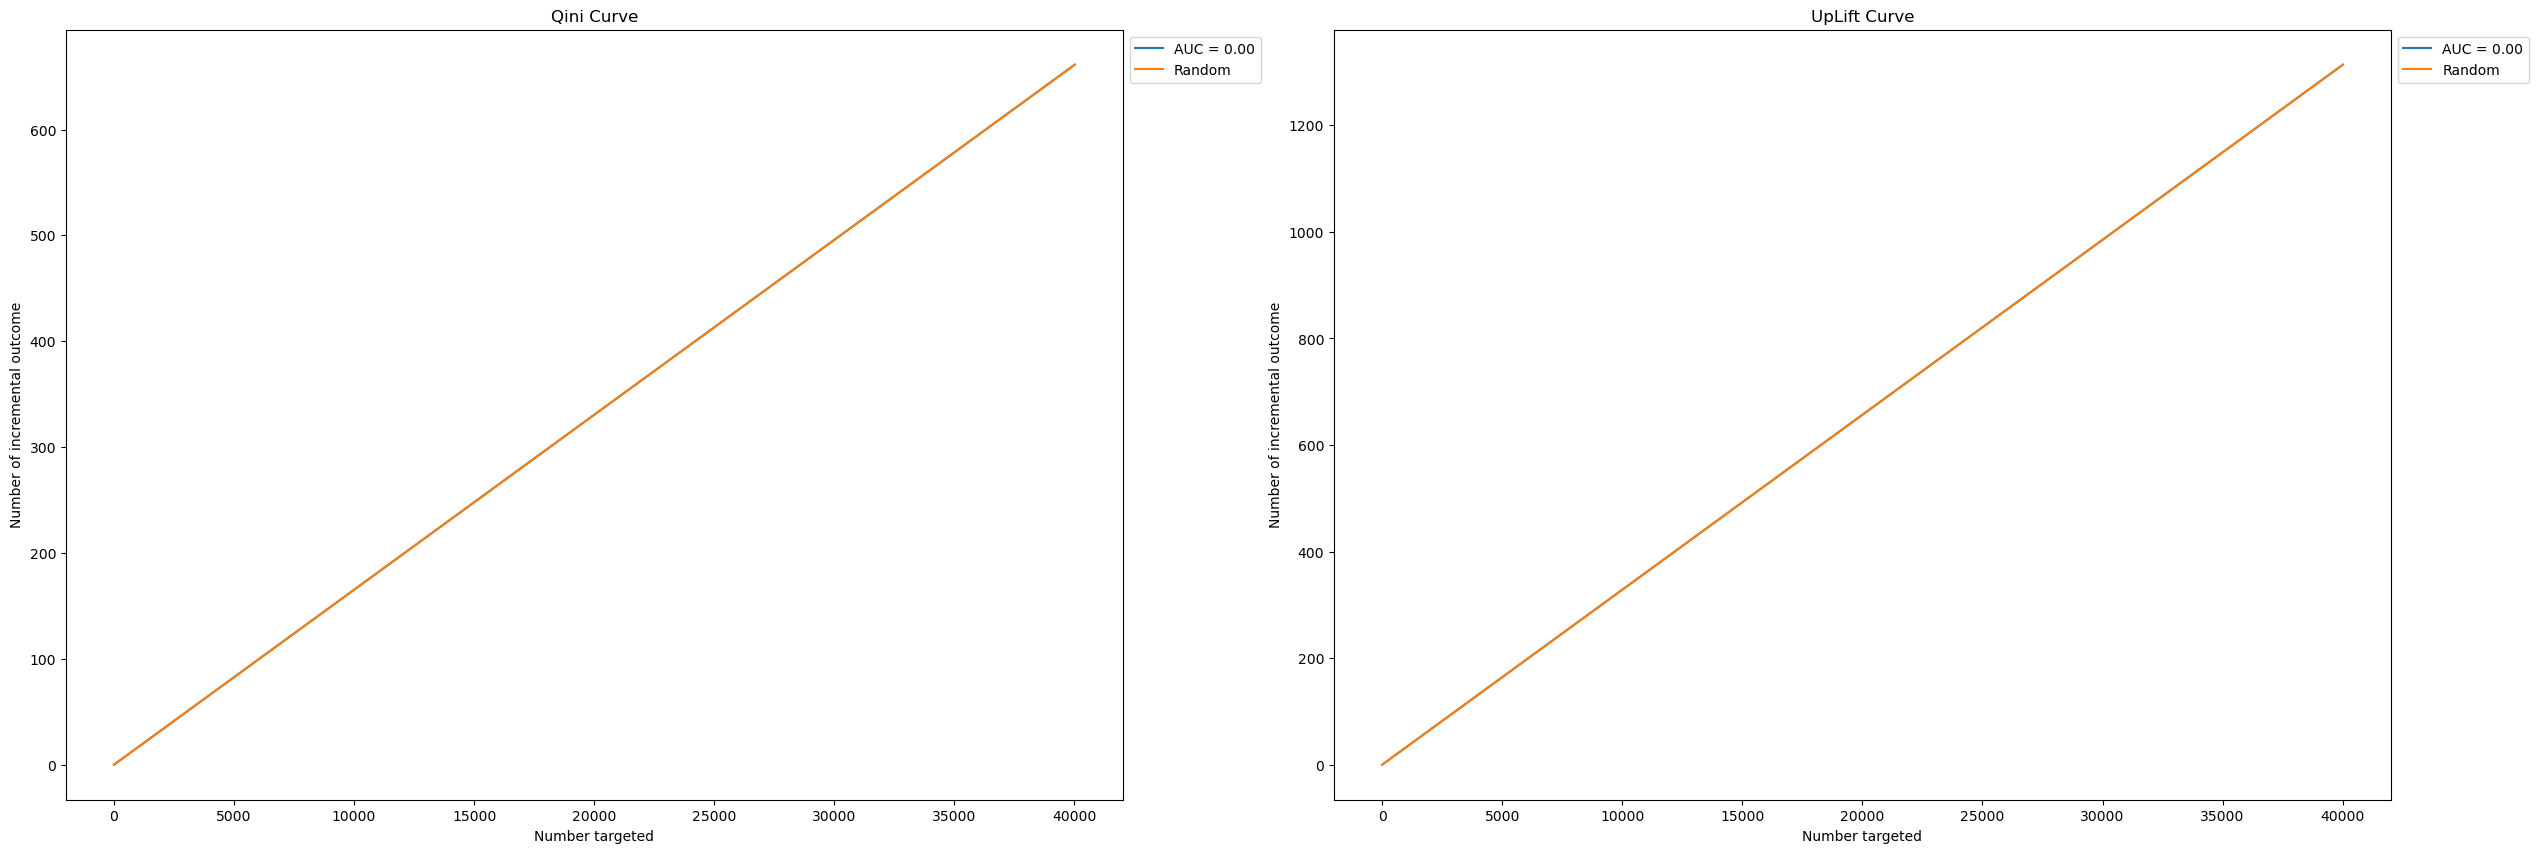

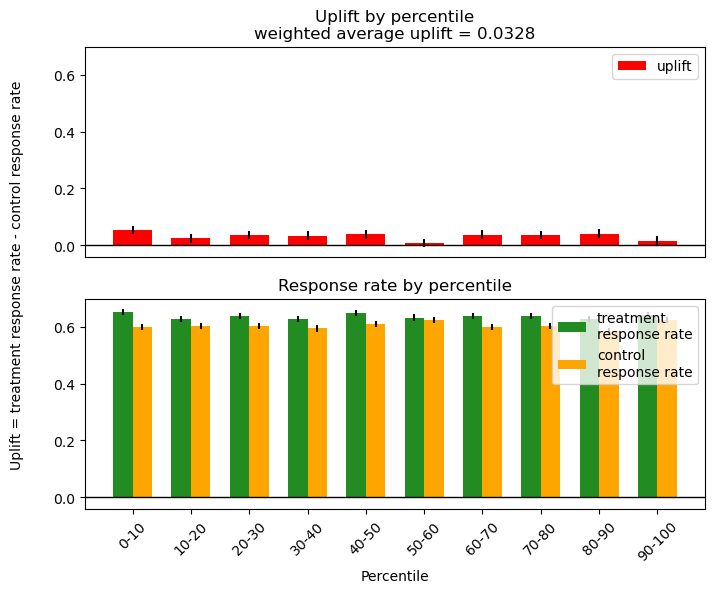

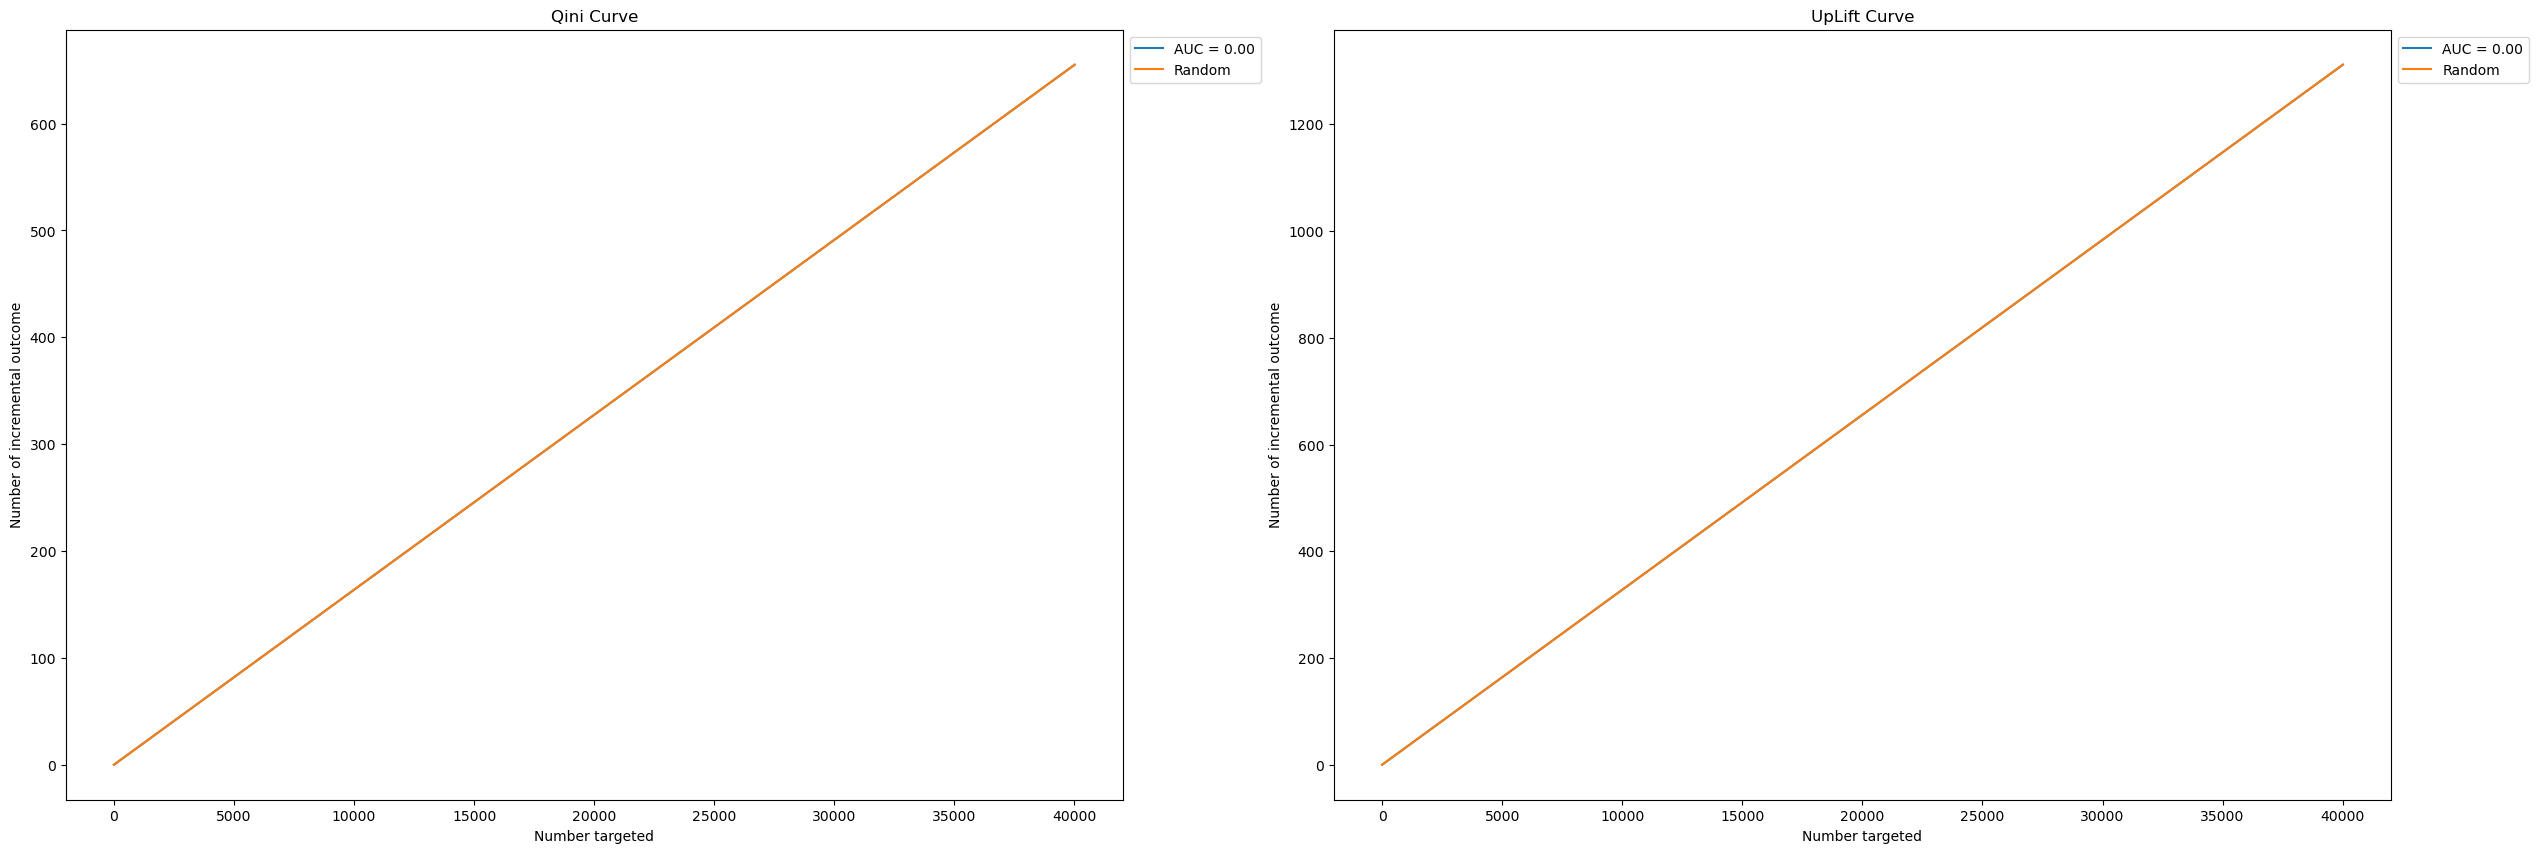

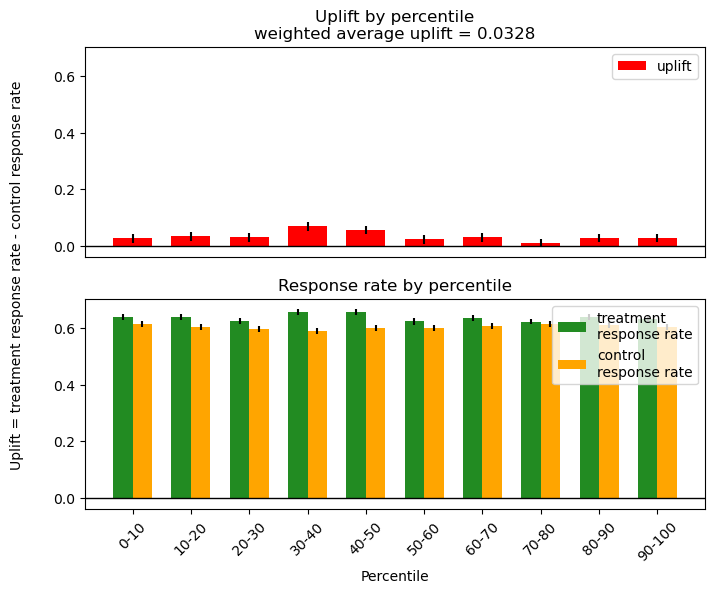

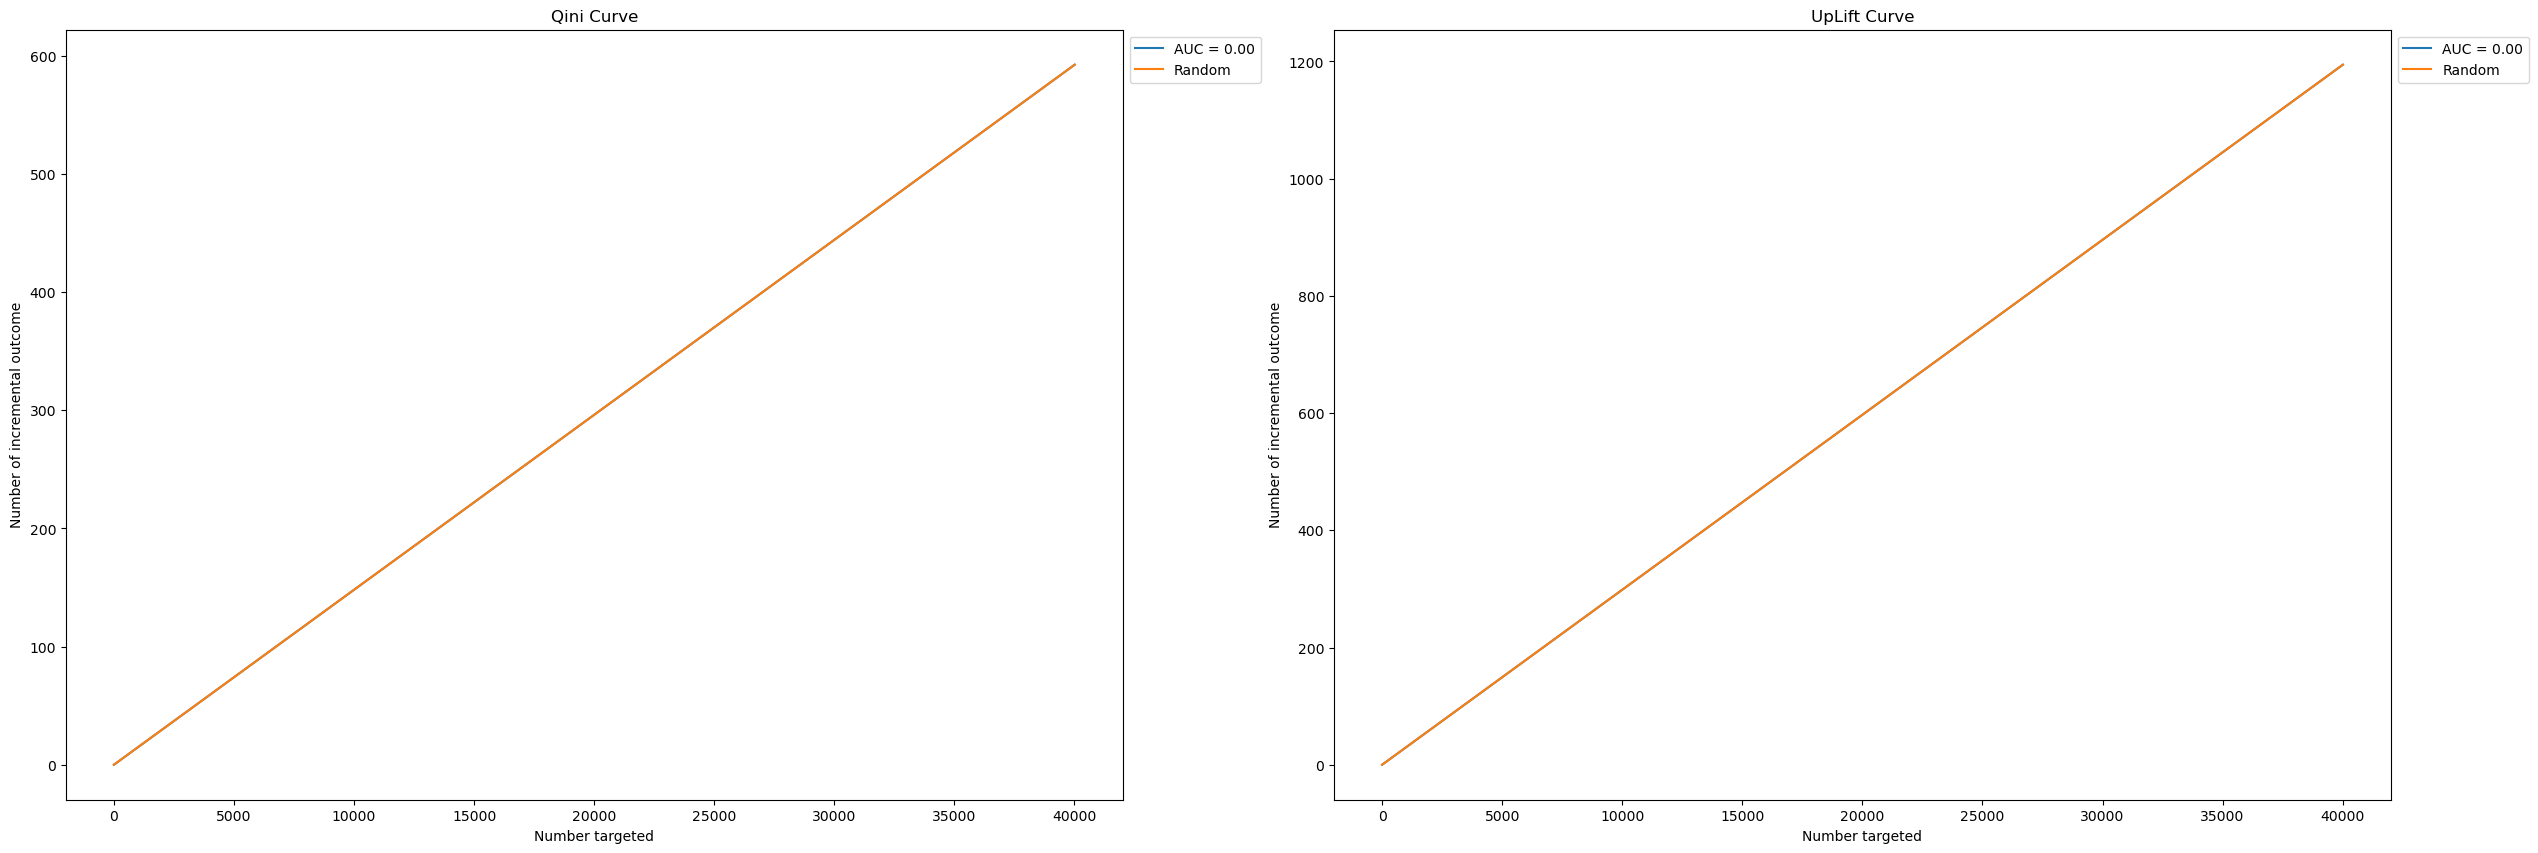

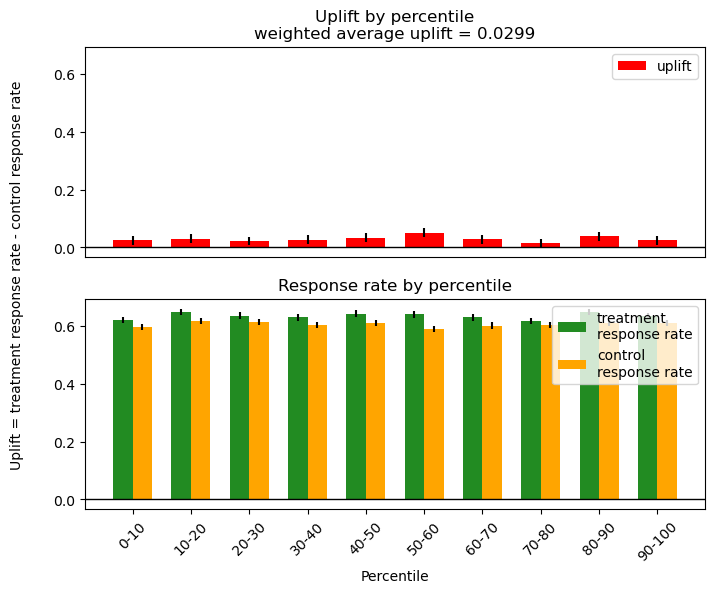

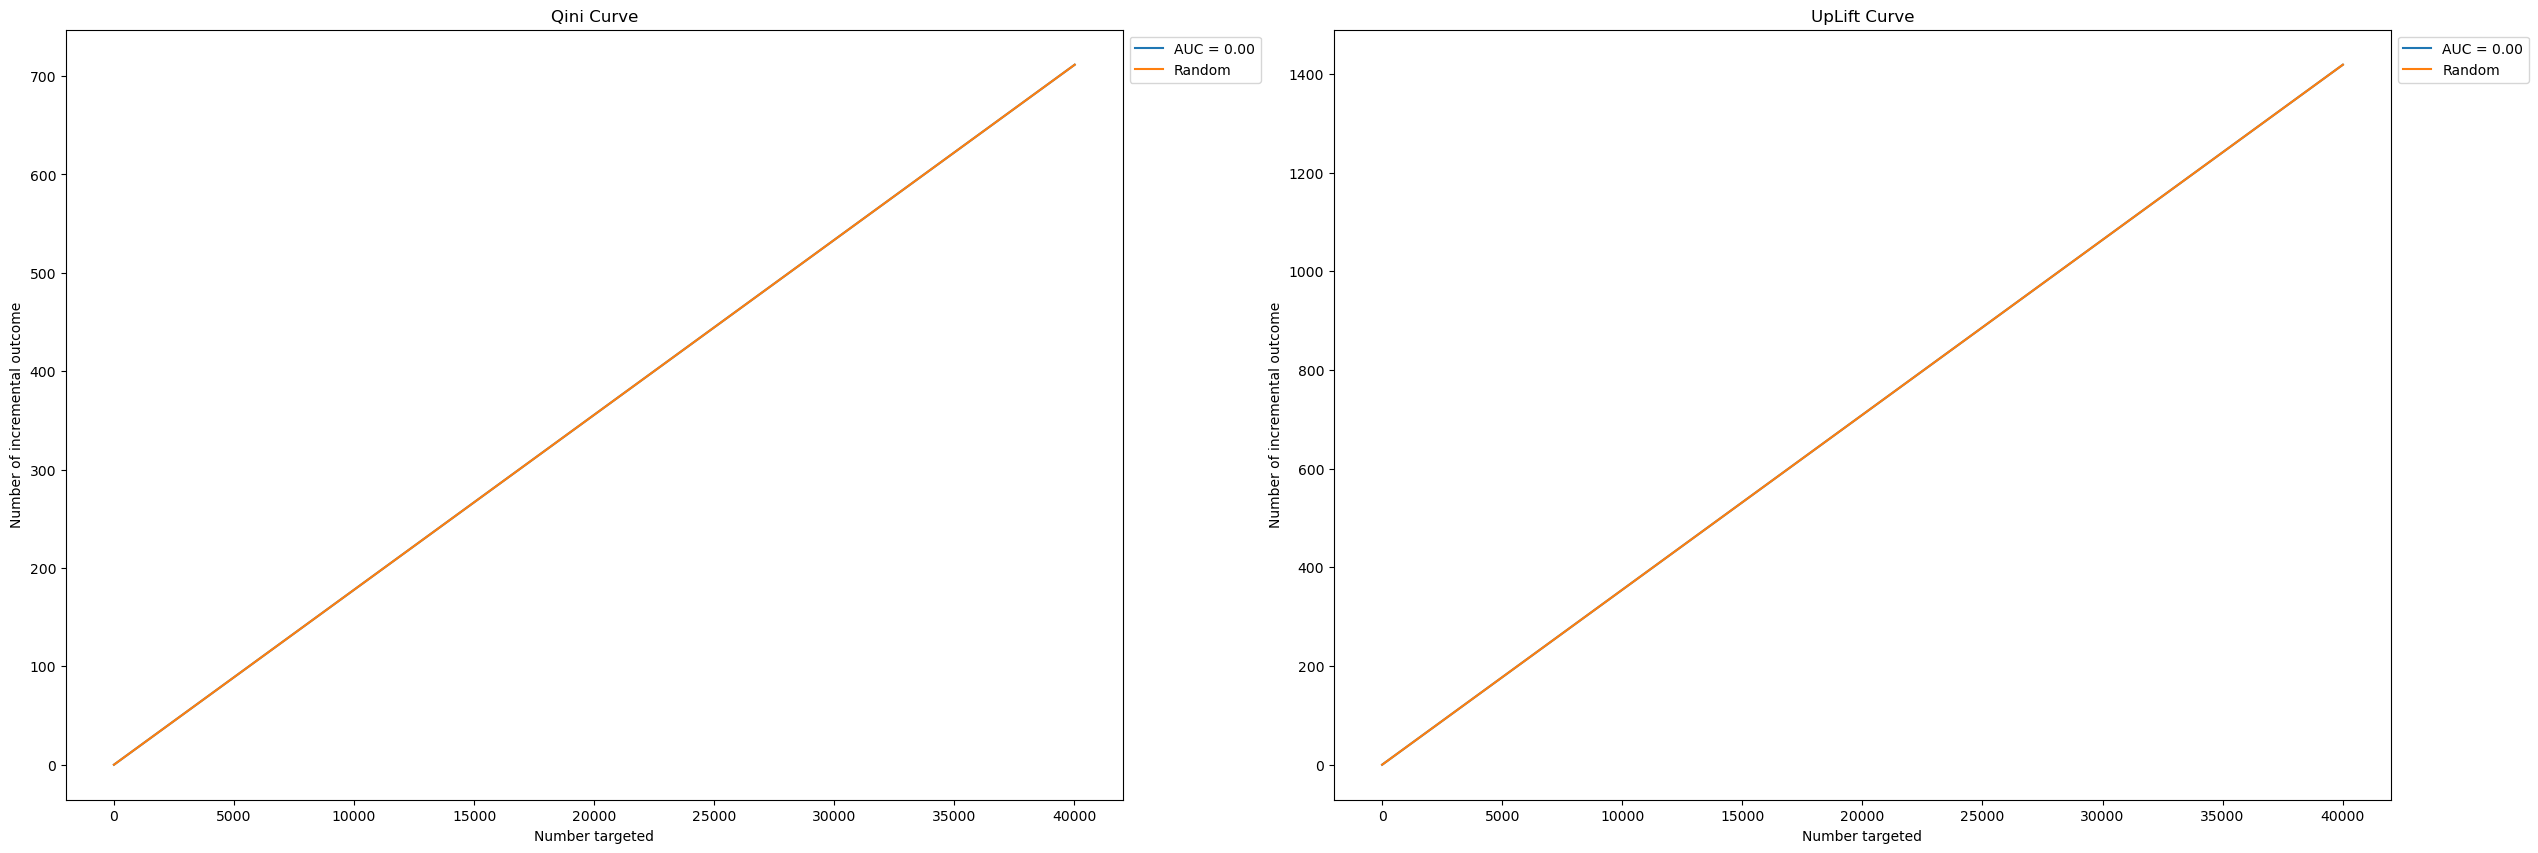

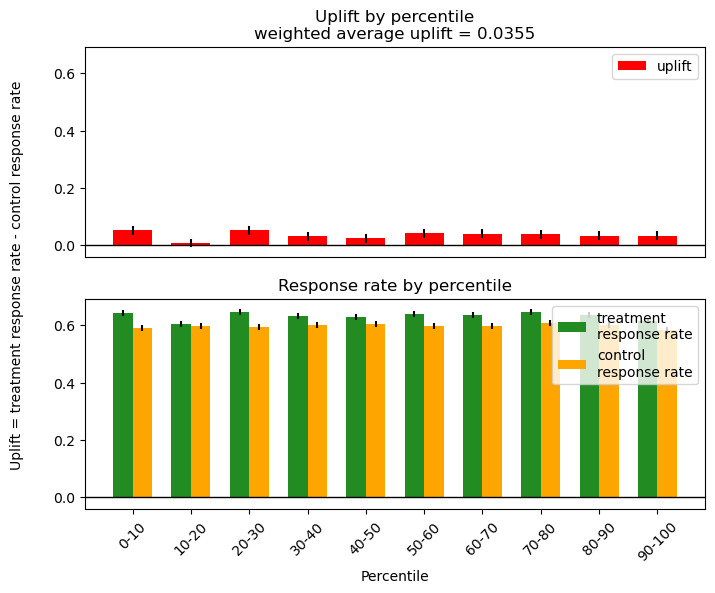

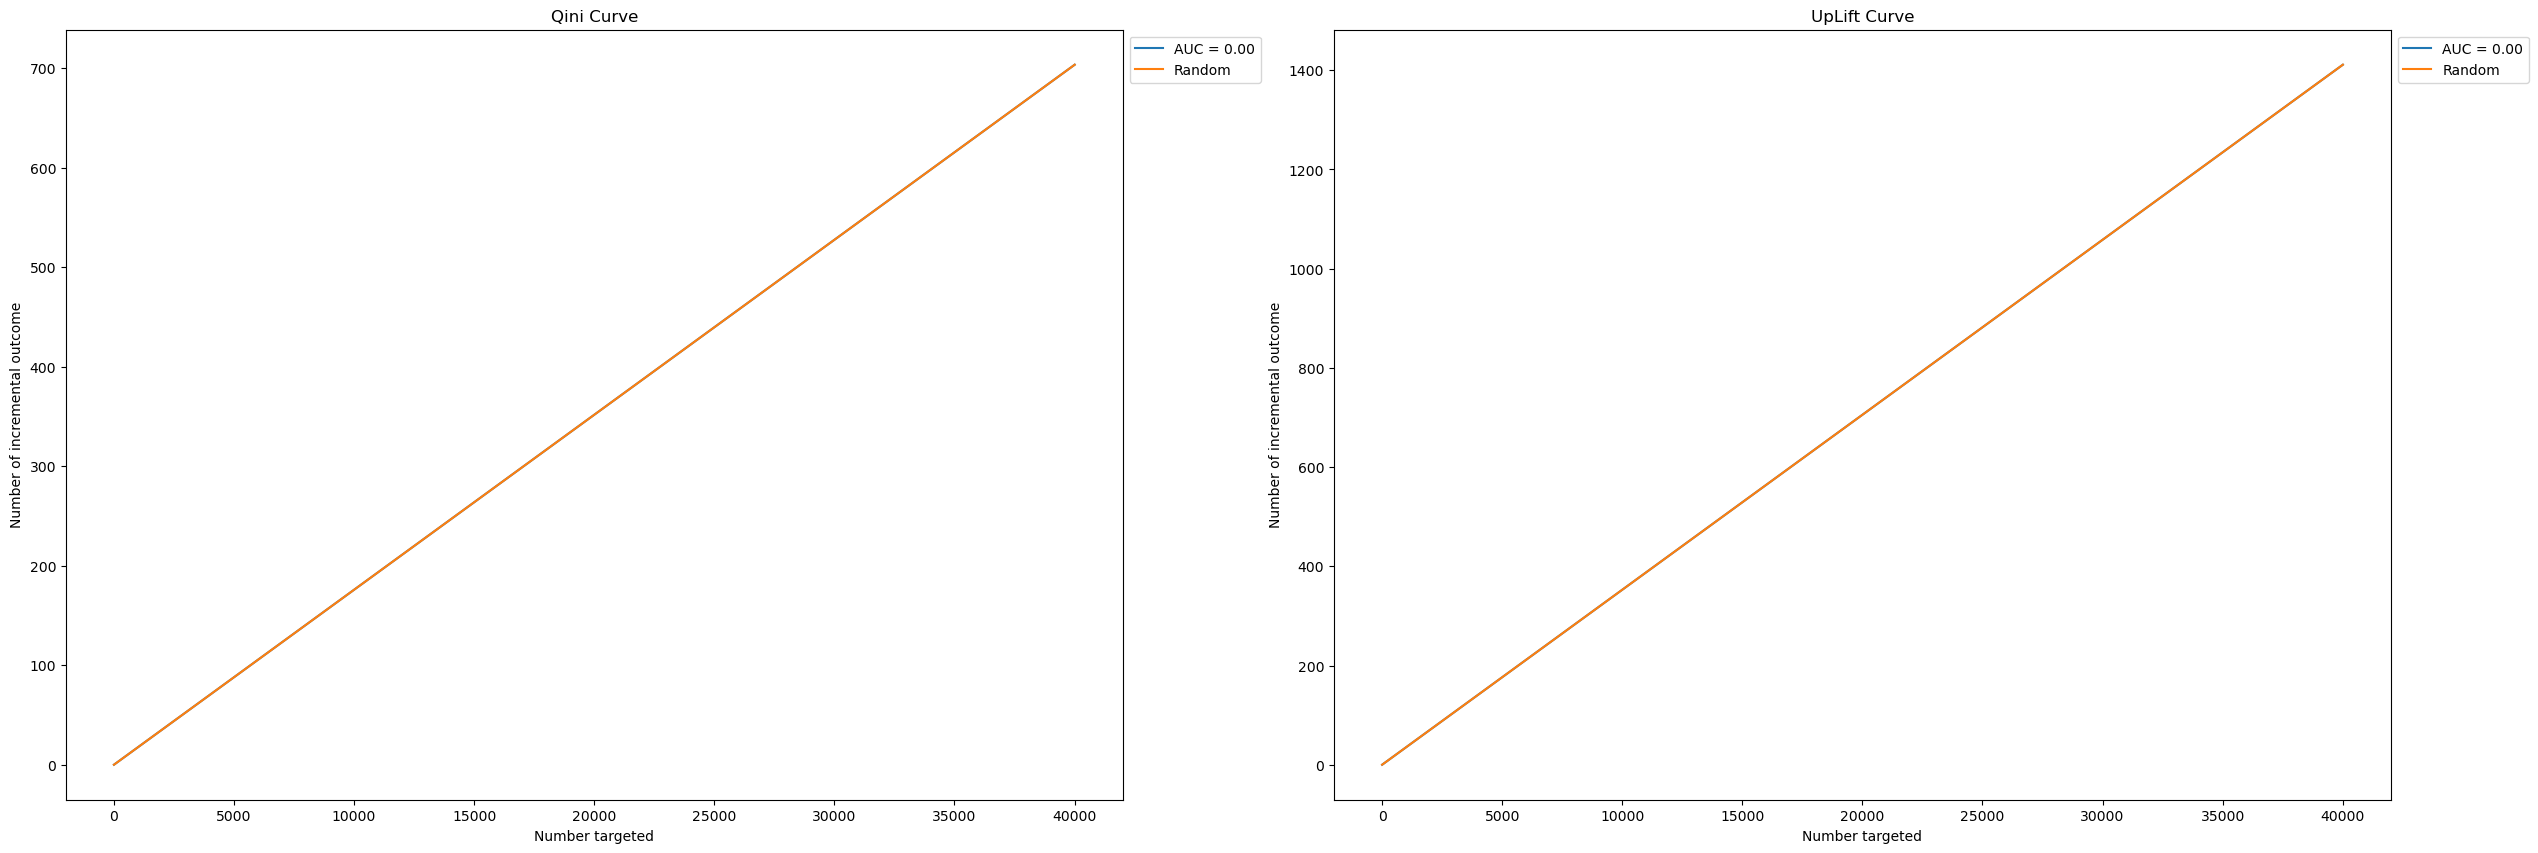

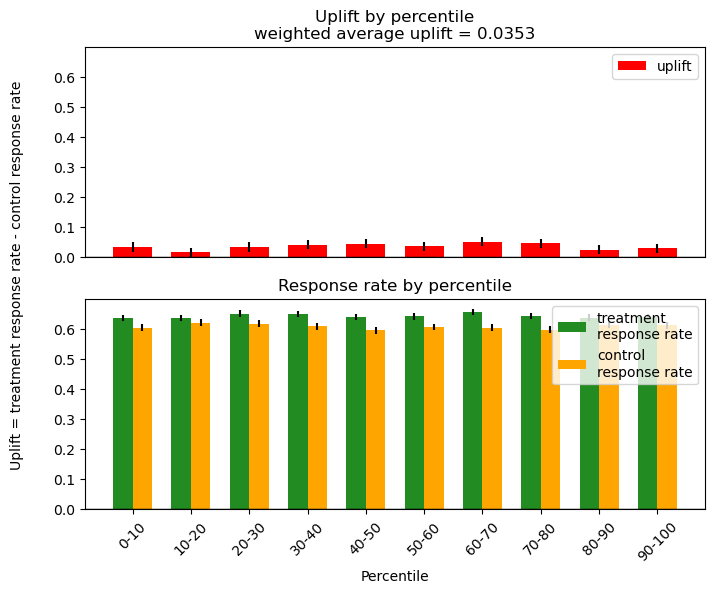

In [28]:
import copy
# Метод двух моделей
#Default data
skf = KFold(n_splits=5)
skf.get_n_splits(X, y)
metrics = {'wau':[], 'uplift_k':[]}
i = 0

for train_index, test_index in skf.split(X, y):
      gc.collect()
      X_train_, X_test_ = X[train_index], X[test_index]
      y_train_, y_test_ = y[train_index], y[test_index]
      ctbst  = copy.deepcopy(automl.best_pipeline)
      ctbst.fit(X_train_, y_train_)
      y_pred = ctbst.predict(X_test_)
      del X_train_
      del y_train_
      del X_test_
      gc.collect()
      wau = weighted_average_uplift(y_true=targ[test_index] , uplift=y_pred,
                              treatment=treat[test_index])
      uplift_overall = uplift_at_k(y_true=targ[test_index] , uplift=y_pred,
                              treatment=treat[test_index], strategy='by_group', k=0.3)
      metrics['wau'].append(wau)
      metrics['uplift_k'].append(uplift_overall)
      i += 1
      print(f'Split {i}; WAU = {wau}; UpLift 30% = {uplift_overall}')
      fig, ax = plt.subplots(1, 2, figsize = (30, 10))
      ax[0].set_title('Qini Curve')
      ax[1].set_title('UpLift Curve')
      plot_qini_curve(y_true=targ[test_index] , uplift=y_pred,
                              treatment=treat[test_index], ax = ax[0], perfect=False)
      gc.collect()
      plot_uplift_curve(y_true=targ[test_index] , uplift=y_pred,
                              treatment=treat[test_index], ax = ax[1], perfect=False)
      gc.collect()
      gc.collect()
      gc.collect()
      plt.savefig(f"Plots/Regression model Split {i}.png")

      plot_uplift_by_percentile(y_true=targ[test_index], uplift=y_pred,
                              treatment=treat[test_index], kind='bar')
      plt.savefig(f"Plots/Regression model Procentile Split {i}.png")


wau = np.round(np.mean(metrics['wau']), 4)
uplift_overall = np.round(np.mean(metrics['uplift_k']), 4)
print(f'Mean WAU = {wau}; Mean UpLift 30% = {uplift_overall}')
